<a href="https://colab.research.google.com/github/manujo-varghese/CANalyzat0r/blob/master/CAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import correlate
import networkx as nx
from collections import defaultdict
import itertools
from typing import List, Dict, Tuple, Any, Optional, Set, Union
import os
import pickle
from tqdm import tqdm

class CANFrame:
    """Represents a single CAN frame with ID and payload."""

    def __init__(self, can_id: str, payload: str, timestamp: float = 0.0):
        """
        Initialize a CAN frame.

        Args:
            can_id: The CAN ID in hexadecimal format (e.g. '0x123')
            payload: The payload in hexadecimal format (e.g. '00FF34A2')
            timestamp: The timestamp when the frame was captured
        """
        self.can_id = can_id
        self.payload = payload
        self.timestamp = timestamp

        # Convert payload to binary representation
        try:
            self.binary_payload = bin(int(payload, 16))[2:].zfill(len(payload) * 4)
        except ValueError:
            self.binary_payload = '0' * 64  # Default to 64 bits for invalid payloads

    def get_bit(self, bit_position: int) -> int:
        """Get the value of a specific bit in the payload."""
        if bit_position < len(self.binary_payload):
            return int(self.binary_payload[bit_position])
        return 0

    def get_byte(self, byte_position: int) -> int:
        """Get the value of a specific byte in the payload."""
        start_bit = byte_position * 8
        end_bit = start_bit + 8
        if start_bit < len(self.binary_payload):
            byte_str = self.binary_payload[start_bit:min(end_bit, len(self.binary_payload))]
            byte_str = byte_str.ljust(8, '0')
            return int(byte_str, 2)
        return 0

    def get_bits(self, start_bit: int, num_bits: int) -> int:
        """Get a range of bits as a single integer value."""
        end_bit = start_bit + num_bits
        if start_bit < len(self.binary_payload):
            bits_str = self.binary_payload[start_bit:min(end_bit, len(self.binary_payload))]
            bits_str = bits_str.ljust(num_bits, '0')
            return int(bits_str, 2)
        return 0

    def __str__(self) -> str:
        return f"CANFrame(id={self.can_id}, payload={self.payload}, ts={self.timestamp})"


class CANTrace:
    """Collection of CAN frames representing a vehicle trace."""

    def __init__(self, frames: Optional[List[CANFrame]] = None):
        """
        Initialize a CAN trace with optional frames.

        Args:
            frames: List of CANFrame objects
        """
        self.frames = frames or []
        self.frames_by_id = defaultdict(list)
        self._update_frame_index()

    def _update_frame_index(self):
        """Update the index of frames by CAN ID."""
        self.frames_by_id = defaultdict(list)
        for frame in self.frames:
            self.frames_by_id[frame.can_id].append(frame)

    def add_frame(self, frame: CANFrame):
        """Add a single frame to the trace."""
        self.frames.append(frame)
        self.frames_by_id[frame.can_id].append(frame)

    def add_frames(self, frames: List[CANFrame]):
        """Add multiple frames to the trace."""
        self.frames.extend(frames)
        self._update_frame_index()

    def get_frames_by_id(self, can_id: str) -> List[CANFrame]:
        """Get all frames with a specific CAN ID."""
        return self.frames_by_id.get(can_id, [])

    def get_unique_ids(self) -> Set[str]:
        """Get the set of unique CAN IDs in the trace."""
        return set(self.frames_by_id.keys())

    @classmethod
    def from_log(cls, filepath):
        trace = cls()
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue  # skip empty lines

                if line.startswith('('):
                    end_idx = line.find(')')
                    ts_str = line[1:end_idx]
                    timestamp = float(ts_str)
                else:
                    continue  # skip invalid format lines

                remaining = line[end_idx+1:].strip()
                parts = remaining.split()
                if len(parts) < 2:
                    continue  # malformed line

                id_payload = parts[1] if '#' in parts[1] else parts[0]
                if '#' not in id_payload:
                    continue  # invalid payload

                id_str, data_str = id_payload.split('#', 1)
                try:
                    can_id = int(id_str, 16)
                except ValueError:
                    continue

                data_bytes = [int(data_str[i:i+2], 16) for i in range(0, len(data_str), 2)]

                # Create CANFrame with matching signature
                frame = CANFrame(can_id=f"{can_id:X}", payload=''.join(f"{byte:02X}" for byte in data_bytes), timestamp=timestamp)
                trace.frames.append(frame)

        trace._update_frame_index()
        return trace


    def __len__(self) -> int:
        return len(self.frames)

    def __str__(self) -> str:
        return f"CANTrace(frames={len(self.frames)}, unique_ids={len(self.get_unique_ids())})"


class CANSignal:
    """Represents a decoded signal within CAN frames."""

    SIGNAL_TYPES = ['uint', 'enum', 'rand', 'cyclic']

    def __init__(self, can_id: str, start_bit: int, num_bits: int, signal_type: str = 'unknown'):
        """
        Initialize a CAN signal.

        Args:
            can_id: The CAN ID this signal belongs to
            start_bit: Starting bit position (0-indexed)
            num_bits: Number of bits in the signal
            signal_type: Type of signal ('uint', 'enum', 'rand', 'cyclic', or 'unknown')
        """
        self.can_id = can_id
        self.start_bit = start_bit
        self.num_bits = num_bits
        self.signal_type = signal_type if signal_type in self.SIGNAL_TYPES else 'unknown'
        self.label = None
        self.values = []  # Will hold the signal values extracted from frames
        self.timestamps = []  # Timestamps corresponding to values

        # Statistics calculated later
        self.autocorrelation = None
        self.hamd = None
        self.min_value = None
        self.max_value = None
        self.avg_value = None
        self.std_value = None
        self.distinct_values = None
        self.flip_rate = None

    def extract_values(self, frames: List[CANFrame]):
        """Extract signal values from a list of CAN frames."""
        self.values = []
        self.timestamps = []

        for frame in frames:
            value = frame.get_bits(self.start_bit, self.num_bits)
            self.values.append(value)
            self.timestamps.append(frame.timestamp)

        # Calculate basic statistics
        if self.values:
            self.min_value = min(self.values)
            self.max_value = max(self.values)
            self.avg_value = sum(self.values) / len(self.values)
            self.std_value = np.std(self.values) if len(self.values) > 1 else 0
            self.distinct_values = len(set(self.values))

            # Calculate flip rate
            if len(self.values) > 1:
                flips = sum(1 for i in range(len(self.values)-1) if self.values[i] != self.values[i+1])
                self.flip_rate = flips / (len(self.values) - 1)
            else:
                self.flip_rate = 0

    def calculate_autocorrelation(self, max_lag: int = 100):
        """Calculate the autocorrelation function for the signal values."""
        if len(self.values) > max_lag:
            # Normalize the values
            normalized = np.array(self.values) - np.mean(self.values)
            if np.std(normalized) > 0:
                normalized = normalized / np.std(normalized)

                # Calculate autocorrelation
                self.autocorrelation = [1.0]  # Lag 0 is always 1.0
                for lag in range(1, max_lag):
                    corr = np.corrcoef(normalized[:-lag], normalized[lag:])[0, 1]
                    self.autocorrelation.append(corr)
            else:
                self.autocorrelation = [0.0] * max_lag
        else:
            self.autocorrelation = [0.0] * max_lag

    def calculate_hamd(self):
        """Calculate the Hamming distance distribution (HAMD) for the signal."""
        if len(self.values) <= 1:
            self.hamd = [0.0] * self.num_bits
            return

        # Convert values to binary sequences
        binary_values = [format(v, f'0{self.num_bits}b') for v in self.values]

        # Calculate HAMD for each bit position
        self.hamd = []
        for bit_pos in range(self.num_bits):
            # Extract the bit at this position for all values
            bits = [int(binary_values[j][bit_pos]) for j in range(len(binary_values))]

            # Count flips
            flips = sum(1 for j in range(len(bits)-1) if bits[j] != bits[j+1])
            flip_rate = flips / (len(bits) - 1) if len(bits) > 1 else 0
            self.hamd.append(flip_rate)

    def is_likely_uint(self) -> bool:
        """Check if the signal is likely an unsigned integer."""
        if not self.hamd:
            return False

        # Check for increasing HAMD pattern typical of little-endian integers
        increasing = all(self.hamd[i] <= self.hamd[i+1] for i in range(len(self.hamd)-1))
        return increasing and self.flip_rate > 0.01

    def is_likely_enum(self) -> bool:
        """Check if the signal is likely an enumeration."""
        if not self.hamd:
            return False

        # Enums typically have a low number of distinct values relative to possible values
        max_possible = 2 ** self.num_bits
        enum_threshold = min(32, max_possible * 0.1)  # Heuristic threshold

        return (self.distinct_values <= enum_threshold and
                self.distinct_values > 1 and
                self.flip_rate < 0.3)

    def is_likely_random(self) -> bool:
        """Check if the signal is likely random (like a checksum)."""
        if not self.hamd or not self.autocorrelation:
            return False

        # Random signals have high entropy and low autocorrelation
        high_entropy = self.distinct_values > min(100, 2 ** self.num_bits * 0.5)
        low_autocorr = all(abs(ac) < 0.3 for ac in self.autocorrelation[1:10] if ac is not None)

        return high_entropy and low_autocorr and self.flip_rate > 0.3

    def is_likely_cyclic(self) -> bool:
        """Check if the signal is likely cyclic (counter, clock)."""
        if not self.autocorrelation or len(self.autocorrelation) < 10:
            return False

        # Cyclic signals show oscillatory autocorrelation
        oscillatory = False
        if len(self.autocorrelation) > 2:
            # Check for sign changes in autocorrelation - typical of oscillatory signals
            sign_changes = sum(1 for i in range(1, len(self.autocorrelation)-1)
                              if (self.autocorrelation[i] * self.autocorrelation[i+1]) < 0)
            oscillatory = sign_changes >= 3

        # Also check for steadily increasing values with wrap-around
        if len(self.values) > 10:
            increasing_count = sum(1 for i in range(len(self.values)-1)
                                  if self.values[i+1] == (self.values[i] + 1) % (2**self.num_bits))
            perfect_counter = increasing_count > len(self.values) * 0.8
            return oscillatory or perfect_counter

        return oscillatory

    def determine_signal_type(self):
        """Determine the most likely signal type based on signal characteristics."""
        # Make sure we have calculated all necessary characteristics
        if self.hamd is None:
            self.calculate_hamd()
        if self.autocorrelation is None:
            self.calculate_autocorrelation()

        # Check conditions for each type
        if self.is_likely_cyclic():
            self.signal_type = 'cyclic'
        elif self.is_likely_random():
            self.signal_type = 'rand'
        elif self.is_likely_enum():
            self.signal_type = 'enum'
        elif self.is_likely_uint():
            self.signal_type = 'uint'
        else:
            self.signal_type = 'unknown'

    def __str__(self) -> str:
        label_str = f", label={self.label}" if self.label else ""
        return (f"CANSignal(id={self.can_id}, bits=[{self.start_bit}:{self.start_bit+self.num_bits}], "
                f"type={self.signal_type}{label_str})")


class AutoCANAnalyzer:
    """
    Implements the AutoCAN methodology for automatic reverse engineering of CAN signals.
    """

    def __init__(self, can_trace: CANTrace):
        """
        Initialize the analyzer with a CAN trace.

        Args:
            can_trace: A CANTrace object containing the frames to analyze
        """
        self.can_trace = can_trace
        self.signals_by_id = {}  # Dict of signals by CAN ID
        self.correlation_graph = None

    def identify_signals(self, progress_bar=True):
        """
        Identify signals for all CAN IDs in the trace.

        Args:
            progress_bar: Whether to show a progress bar
        """
        unique_ids = self.can_trace.get_unique_ids()

        if progress_bar:
            id_iterator = tqdm(unique_ids, desc="Identifying signals")
        else:
            id_iterator = unique_ids

        for can_id in id_iterator:
            frames = self.can_trace.get_frames_by_id(can_id)
            if len(frames) > 10:  # Skip IDs with too few frames
                self.signals_by_id[can_id] = self.identify_signals_for_id(can_id, frames)

    def identify_signals_for_id(self, can_id: str, frames: List[CANFrame]) -> List[CANSignal]:
        """
        Identify signals for a specific CAN ID.

        Args:
            can_id: The CAN ID to analyze
            frames: List of frames with this CAN ID

        Returns:
            List of identified CANSignal objects
        """
        # Step 1: Extract byte-level features
        byte_features = self._extract_byte_features(frames)

        # Step 2: Cluster bytes using DBSCAN
        byte_clusters = self._cluster_bytes(byte_features)

        # Step 3: Process each byte cluster to identify bit-level signals
        signals = []
        for cluster_id, byte_indices in byte_clusters.items():
            # Skip noise cluster (cluster_id = -1)
            if cluster_id == -1:
                continue

            # Extract bit-level features for this cluster
            start_bit = min(byte_indices) * 8
            end_bit = (max(byte_indices) + 1) * 8 - 1
            cluster_signals = self._identify_bit_level_signals(frames, start_bit, end_bit)
            signals.extend(cluster_signals)

        # Extract values and determine signal types
        for signal in signals:
            signal.extract_values(frames)
            signal.calculate_autocorrelation()
            signal.calculate_hamd()
            signal.determine_signal_type()

        return signals

    def _extract_byte_features(self, frames: List[CANFrame]) -> np.ndarray:
        """
        Extract byte-level features from a list of frames.

        Args:
            frames: List of CAN frames

        Returns:
            2D array of features (rows=bytes, columns=features)
        """
        max_bytes = 8  # Standard CAN frame has 8 bytes max

        # Create arrays for feature extraction
        byte_values = np.zeros((max_bytes, len(frames)), dtype=int)

        # Extract byte values
        for byte_idx in range(max_bytes):
            for frame_idx, frame in enumerate(frames):
                byte_values[byte_idx, frame_idx] = frame.get_byte(byte_idx)

        # Calculate features for each byte
        features = []
        for byte_idx in range(max_bytes):
            byte_data = byte_values[byte_idx, :]

            # Calculate flip rate
            flips = sum(1 for i in range(len(byte_data)-1) if byte_data[i] != byte_data[i+1])
            flip_rate = flips / (len(byte_data) - 1) if len(byte_data) > 1 else 0

            # Calculate average value
            avg_value = np.mean(byte_data)

            # Calculate distinct value ratio
            distinct_values = len(np.unique(byte_data))
            distinct_ratio = distinct_values / 256  # 256 possible values for a byte

            # Entropy
            values, counts = np.unique(byte_data, return_counts=True)
            probs = counts / len(byte_data)
            entropy = -np.sum(probs * np.log2(probs + 1e-10))

            features.append([flip_rate, avg_value / 255, distinct_ratio, entropy / 8])

        return np.array(features)

    def _cluster_bytes(self, byte_features: np.ndarray, eps=0.4, min_samples=2) -> Dict[int, List[int]]:
        """
        Cluster bytes based on their features using DBSCAN.

        Args:
            byte_features: 2D array of byte features
            eps: DBSCAN epsilon parameter
            min_samples: DBSCAN min_samples parameter

        Returns:
            Dictionary mapping cluster IDs to lists of byte indices
        """
        # Apply DBSCAN to group related bytes
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(byte_features)
        labels = clustering.labels_

        # Group bytes by cluster
        clusters = defaultdict(list)
        for i, label in enumerate(labels):
            clusters[label].append(i)

        # Refine clusters to ensure they contain consecutive bytes
        refined_clusters = {}
        next_cluster_id = max(clusters.keys()) + 1 if clusters else 0

        for cluster_id, byte_indices in clusters.items():
            # Skip noise cluster as we'll process them individually
            if cluster_id == -1:
                for idx in byte_indices:
                    refined_clusters[next_cluster_id] = [idx]
                    next_cluster_id += 1
                continue

            # Sort byte indices
            byte_indices.sort()

            # Find consecutive chunks
            chunks = []
            current_chunk = [byte_indices[0]]

            for i in range(1, len(byte_indices)):
                if byte_indices[i] == byte_indices[i-1] + 1:
                    current_chunk.append(byte_indices[i])
                else:
                    chunks.append(current_chunk)
                    current_chunk = [byte_indices[i]]

            if current_chunk:
                chunks.append(current_chunk)

            # Create a new cluster for each chunk
            for chunk in chunks:
                refined_clusters[next_cluster_id] = chunk
                next_cluster_id += 1

        return refined_clusters

    def _identify_bit_level_signals(self, frames: List[CANFrame], start_bit: int, end_bit: int) -> List[CANSignal]:
        """
        Identify bit-level signals within a byte cluster.

        Args:
            frames: List of CAN frames
            start_bit: Starting bit position
            end_bit: Ending bit position

        Returns:
            List of identified CANSignal objects
        """
        can_id = frames[0].can_id
        num_bits = end_bit - start_bit + 1

        # For small bit ranges (8 bits or less), try to determine if this is a single signal
        if num_bits <= 8:
            signal = CANSignal(can_id, start_bit, num_bits)
            return [signal]

        # Extract bit flip rates
        bit_flip_rates = self._calculate_bit_flip_rates(frames, start_bit, end_bit)

        # Use DBSCAN to cluster bits based on flip rates
        bit_clusters = self._cluster_bits(bit_flip_rates)

        # Create signals from bit clusters
        signals = []
        for cluster_bits in bit_clusters:
            # Sort bits to ensure consecutive ordering
            cluster_bits.sort()

            # Find consecutive chunks of bits
            chunks = []
            current_chunk = [cluster_bits[0]]

            for i in range(1, len(cluster_bits)):
                if cluster_bits[i] == cluster_bits[i-1] + 1:
                    current_chunk.append(cluster_bits[i])
                else:
                    chunks.append(current_chunk)
                    current_chunk = [cluster_bits[i]]

            if current_chunk:
                chunks.append(current_chunk)

            # Create a signal for each chunk
            for chunk in chunks:
                chunk_start = start_bit + chunk[0]
                chunk_length = len(chunk)
                signal = CANSignal(can_id, chunk_start, chunk_length)
                signals.append(signal)

        return signals

    def _calculate_bit_flip_rates(self, frames: List[CANFrame], start_bit: int, end_bit: int) -> List[float]:
        """
        Calculate flip rates for each bit in the specified range.

        Args:
            frames: List of CAN frames
            start_bit: Starting bit position
            end_bit: Ending bit position

        Returns:
            List of flip rates for each bit
        """
        num_bits = end_bit - start_bit + 1
        bit_values = np.zeros((num_bits, len(frames)), dtype=int)

        # Extract bit values
        for bit_idx in range(num_bits):
            for frame_idx, frame in enumerate(frames):
                bit_values[bit_idx, frame_idx] = frame.get_bit(start_bit + bit_idx)

        # Calculate flip rates
        flip_rates = []
        for bit_idx in range(num_bits):
            bit_data = bit_values[bit_idx, :]
            flips = sum(1 for i in range(len(bit_data)-1) if bit_data[i] != bit_data[i+1])
            flip_rate = flips / (len(bit_data) - 1) if len(bit_data) > 1 else 0
            flip_rates.append(flip_rate)

        return flip_rates

    def _cluster_bits(self, bit_flip_rates: List[float], eps=0.15, min_samples=2) -> List[List[int]]:
        """
        Cluster bits based on their flip rates using DBSCAN.

        Args:
            bit_flip_rates: List of bit flip rates
            eps: DBSCAN epsilon parameter
            min_samples: DBSCAN min_samples parameter

        Returns:
            List of lists where each inner list contains bit indices for a cluster
        """
        # Convert flip rates to 2D array for DBSCAN
        X = np.array(bit_flip_rates).reshape(-1, 1)

        # Apply DBSCAN
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = clustering.labels_

        # Group bits by cluster
        clusters = defaultdict(list)
        for i, label in enumerate(labels):
            clusters[label].append(i)

        # Return list of bit clusters (including noise cluster)
        return list(clusters.values())

    def build_correlation_graph(self, min_correlation=0.8):
        """
        Build a graph of signals based on their correlation.

        Args:
            min_correlation: Minimum correlation coefficient to create an edge
        """
        if not self.signals_by_id:
            raise ValueError("No signals identified. Run identify_signals() first.")

        all_signals = []
        for signals in self.signals_by_id.values():
            all_signals.extend(signals)

        G = nx.Graph()

        for i, signal in enumerate(all_signals):
            G.add_node(i,
                      can_id=signal.can_id,
                      signal_type=signal.signal_type,
                      bits=f"{signal.start_bit}:{signal.start_bit+signal.num_bits}",
                      start_bit=signal.start_bit,
                      num_bits=signal.num_bits)

        for i, signal1 in enumerate(all_signals):
            if len(signal1.values) < 10:
                continue

            for j in range(i+1, len(all_signals)):
                signal2 = all_signals[j]
                if len(signal2.values) < 10:
                    continue

                min_len = min(len(signal1.values), len(signal2.values))
                values1 = signal1.values[:min_len]
                values2 = signal2.values[:min_len]

                if len(np.unique(values1)) <= 1 or len(np.unique(values2)) <= 1:
                    continue

                corr = np.corrcoef(values1, values2)[0, 1]

                if abs(corr) >= min_correlation:
                    G.add_edge(i, j, weight=abs(corr))

        self.correlation_graph = G
        return G



    def discover_mathematical_relationships(self):
        """
        Discover mathematical relationships between signals.

        Returns:
            List of tuples (signal1, relationship, signal2, strength)
        """
        # Ensure we have identified signals first
        if not self.signals_by_id:
            raise ValueError("No signals identified. Run identify_signals() first.")

        # Create a flat list of all signals
        all_signals = []
        for signals in self.signals_by_id.values():
            all_signals.extend([s for s in signals if s.signal_type == 'uint' and len(s.values) > 50])

        relationships = []

        # Check for derivative relationships
        for i, signal1 in enumerate(all_signals):
            for j, signal2 in enumerate(all_signals):
                if i == j:
                    continue

                # Ensure signals have enough values
                min_len = min(len(signal1.values), len(signal2.values))
                if min_len < 50:
                    continue

                # Get time-aligned values
                values1 = np.array(signal1.values[:min_len])
                values2 = np.array(signal2.values[:min_len])

                # Check for derivative relationship
                if min_len > 2:
                    derivative1 = np.diff(values1)
                    correlation = np.corrcoef(derivative1, values2[1:min_len])[0, 1]
                    if np.isnan(correlation):
                        continue

                    if abs(correlation) > 0.8:
                        relationships.append((signal1, 'derivative', signal2, abs(correlation)))

                # Check for integral relationship
                if min_len > 2:
                    # Compute a simple integral (cumulative sum)
                    integral2 = np.cumsum(values2)
                    # Compute correlation with values1
                    correlation = np.corrcoef(values1, integral2[:min_len])[0, 1]
                    if np.isnan(correlation):
                        continue

                    if abs(correlation) > 0.8:
                        relationships.append((signal2, 'integral', signal1, abs(correlation)))

        return relationships

    def visualize_hamd_heatmap(self, can_id: str = None, figsize=(12, 8)):
        """
        Visualize the HAMD (Hamming distance distribution) as a heatmap.

        Args:
            can_id: Optional CAN ID to filter by (None for all IDs)
            figsize: Figure size tuple (width, height)
        """
        # Ensure we have identified signals first
        if not self.signals_by_id:
            raise ValueError("No signals identified. Run identify_signals() first.")

        # Get signals for the specified CAN ID or all signals
        if can_id is not None:
            if can_id not in self.signals_by_id:
                raise ValueError(f"No signals found for CAN ID: {can_id}")
            signals = self.signals_by_id[can_id]
        else:
            # Flatten the dict of signals
            signals = []
            for sig_list in self.signals_by_id.values():
                signals.extend(sig_list)

        # Create a list of HAMD values and their bit positions
        hamd_data = []
        for signal in signals:
            if signal.hamd:
                for i, value in enumerate(signal.hamd):
                    hamd_data.append({
                        'can_id': signal.can_id,
                        'bit': signal.start_bit + i,
                        'hamd': value
                    })

        if not hamd_data:
            print("No HAMD data available for visualization.")
            return

        # Convert to DataFrame for easier plotting
        df = pd.DataFrame(hamd_data)

        # Create a pivot table for the heatmap
        pivot_df = df.pivot_table(index='can_id', columns='bit', values='hamd', aggfunc='mean')

        # Plot the heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(pivot_df, cmap='viridis', linewidths=0.5, linecolor='black')
        plt.title('HAMD Heatmap')
        plt.xlabel('Bit Position')
        plt.ylabel('CAN ID')
        plt.tight_layout()
        plt.show()

    def visualize_correlation_graph(self, figsize=(12, 10)):
        """
        Visualize the correlation graph of signals.

        Args:
            figsize: Figure size tuple (width, height)
        """
        if self.correlation_graph is None:
            self.build_correlation_graph()

        if len(self.correlation_graph) == 0:
            print("No correlations found to visualize.")
            return

        # Create position layout
        pos = nx.spring_layout(self.correlation_graph, seed=42)

        # Get node colors based on signal type
        type_colors = {
            'uint': 'blue',
            'enum': 'green',
            'rand': 'red',
            'cyclic': 'purple',
            'unknown': 'gray'
        }

        node_colors = [
            type_colors[self.correlation_graph.nodes[n]['signal_type']]
            for n in self.correlation_graph.nodes
        ]

        # Get edge weights
        edge_weights = [
            self.correlation_graph[u][v]['weight'] * 3
            for u, v in self.correlation_graph.edges
        ]

        # Create the plot
        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(
            self.correlation_graph, pos,
            node_color=node_colors, alpha=0.8
        )
        nx.draw_networkx_edges(
            self.correlation_graph, pos,
            width=edge_weights, alpha=0.5
        )

        # Add labels
        labels = {
            n: f"{self.correlation_graph.nodes[n]['can_id']}\n{self.correlation_graph.nodes[n]['bits']}"
            for n in self.correlation_graph.nodes
        }
        nx.draw_networkx_labels(
            self.correlation_graph, pos, labels, font_size=8
        )

        # Add legend
        legend_elements = [
            plt.Line2D(
                [0], [0], marker='o', color='w',
                markerfacecolor=color, markersize=10, label=type_
            )
            for type_, color in type_colors.items()
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.title('Signal Correlation Graph')
        plt.axis('off')
        plt.tight_layout()
        plt.show()


    def save_results(self, output_dir: str = "autocan_results"):
        os.makedirs(output_dir, exist_ok=True)

        # Save identified signals
        with open(os.path.join(output_dir, 'signals.pkl'), 'wb') as f:
            pickle.dump(self.signals_by_id, f)

        # Save signal summary as CSV
        summary_data = []
        for can_id, signals in self.signals_by_id.items():
            for signal in signals:
                summary_data.append({
                    'can_id': can_id,
                    'start_bit': signal.start_bit,
                    'num_bits': signal.num_bits,
                    'signal_type': signal.signal_type,
                    'label': signal.label or '',
                    'min_value': signal.min_value,
                    'max_value': signal.max_value,
                    'avg_value': signal.avg_value,
                    'distinct_values': signal.distinct_values,
                    'flip_rate': signal.flip_rate
                })

        if summary_data:
            pd.DataFrame(summary_data).to_csv(os.path.join(output_dir, 'signal_summary.csv'), index=False)

        # Save correlation graph as GraphML
        if self.correlation_graph is not None:
            nx.write_graphml(self.correlation_graph, os.path.join(output_dir, 'correlation_graph.graphml'))

        print(f"Results saved to {output_dir}")



# Define the analyze_file function outside of main() so it can be pickled
def analyze_file(file_path, output_dir):
    try:
        file_name = os.path.basename(file_path)
        print(f"\nAnalyzing {file_name}...")

        # Create output directory for this file
        file_output_dir = os.path.join(output_dir, os.path.splitext(file_name)[0])
        os.makedirs(file_output_dir, exist_ok=True)

        # Load and analyze the trace
        can_trace = CANTrace.from_log(file_path)
        print(f"Loaded {len(can_trace)} frames with {len(can_trace.get_unique_ids())} unique IDs")

        # Create analyzer and identify signals
        analyzer = AutoCANAnalyzer(can_trace)
        analyzer.identify_signals()

        # Count identified signals
        signal_count = sum(len(signals) for signals in analyzer.signals_by_id.values())
        print(f"Identified {signal_count} signals across {len(analyzer.signals_by_id)} CAN IDs")

        # Build correlation graph
        analyzer.build_correlation_graph()

        # Discover mathematical relationships
        relationships = analyzer.discover_mathematical_relationships()

        # Save the results for this file
        analyzer.save_results(file_output_dir)

        # Create and return a summary dictionary - don't try to return the full objects which might be hard to pickle
        summary = {
            'file_name': file_name,
            'frame_count': len(can_trace),
            'unique_id_count': len(can_trace.get_unique_ids()),
            'unique_ids': list(can_trace.get_unique_ids()),
            'signal_count': signal_count,
            'relationship_count': len(relationships)
        }

        print(f"Completed analysis of {file_name}")
        return summary
    except Exception as e:
        print(f"Error analyzing {file_path}: {e}")
        return None

def main():
    """
    Process all CAN log files in the current directory and perform comprehensive analysis.
    """
    import glob
    import os
    from concurrent.futures import ProcessPoolExecutor, as_completed
    import multiprocessing

    # Get all log files in the current directory
    log_files = glob.glob("*.log")

    if not log_files:
        print("No log files found in the current directory.")
        return

    print(f"Found {len(log_files)} log files: {', '.join(log_files)}")

    output_dir = "autocan_results"
    os.makedirs(output_dir, exist_ok=True)

    # Process files sequentially if we encounter pickling issues
    use_parallel = True
    summaries = []

    if use_parallel:
        try:
            # Determine number of processors to use
            num_processors = min(multiprocessing.cpu_count(), len(log_files))
            print(f"Using {num_processors} processors for parallel analysis")

            # Process files in parallel
            with ProcessPoolExecutor(max_workers=num_processors) as executor:
                # Create a list of futures
                futures = [executor.submit(analyze_file, file_path, output_dir) for file_path in log_files]

                for future in as_completed(futures):
                    try:
                        result = future.result()
                        if result:
                            summaries.append(result)
                    except Exception as e:
                        print(f"Error in parallel processing: {e}")

        except Exception as e:
            print(f"Error setting up parallel processing: {e}")
            print("Falling back to sequential processing...")
            use_parallel = False

    # If parallel processing fails or is disabled, use sequential processing
    if not use_parallel:
        print("Processing files sequentially...")
        for file_path in log_files:
            result = analyze_file(file_path, output_dir)
            if result:
                summaries.append(result)

    # Generate combined report
    if summaries:
        print("\nGenerating combined summary...")
        combined_dir = os.path.join(output_dir, "combined_results")
        os.makedirs(combined_dir, exist_ok=True)

        # Save summary as CSV
        import pandas as pd
        pd.DataFrame(summaries).to_csv(os.path.join(combined_dir, 'file_statistics.csv'), index=False)
        print(f"File statistics saved to {os.path.join(combined_dir, 'file_statistics.csv')}")

        # Find common CAN IDs across all files
        common_can_ids = set()
        if summaries:
            # Start with IDs from the first file
            common_can_ids = set(summaries[0]['unique_ids'])

            # Intersect with IDs from all other files
            for summary in summaries[1:]:
                common_can_ids &= set(summary['unique_ids'])

        if common_can_ids:
            print(f"\nFound {len(common_can_ids)} CAN IDs common across all files:")
            print(", ".join(sorted(common_can_ids)))
        else:
            print("\nNo CAN IDs common across all files.")

        # Create visualizations for the combined results
        import matplotlib.pyplot as plt
        import numpy as np

        # Make sure the visualizations directory exists
        viz_dir = os.path.join(output_dir, "visualizations")
        os.makedirs(viz_dir, exist_ok=True)

        # Create bar chart of signal counts per file
        plt.figure(figsize=(12, 6))
        file_names = [summary['file_name'] for summary in summaries]
        signal_counts = [summary['signal_count'] for summary in summaries]

        # Sort by signal count for better visualization
        sorted_indices = np.argsort(signal_counts)[::-1]  # descending order
        sorted_file_names = [file_names[i] for i in sorted_indices]
        sorted_signal_counts = [signal_counts[i] for i in sorted_indices]

        plt.bar(range(len(sorted_file_names)), sorted_signal_counts)
        plt.xticks(range(len(sorted_file_names)), sorted_file_names, rotation=90)
        plt.xlabel('File')
        plt.ylabel('Signal Count')
        plt.title('Number of Signals per File')
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, 'signal_counts.png'))
        plt.close()

        # Visualize relationship counts
        plt.figure(figsize=(12, 6))
        relationship_counts = [summary['relationship_count'] for summary in summaries]

        # Sort by relationship count
        sorted_indices = np.argsort(relationship_counts)[::-1]  # descending order
        sorted_file_names = [file_names[i] for i in sorted_indices]
        sorted_rel_counts = [relationship_counts[i] for i in sorted_indices]

        plt.bar(range(len(sorted_file_names)), sorted_rel_counts)
        plt.xticks(range(len(sorted_file_names)), sorted_file_names, rotation=90)
        plt.xlabel('File')
        plt.ylabel('Relationship Count')
        plt.title('Number of Mathematical Relationships per File')
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, 'relationship_counts.png'))
        plt.close()

        print(f"\nVisualization plots saved to {viz_dir}")
    else:
        print("\nNo valid results to summarize.")

    print("\nAnalysis complete! Results are in the 'autocan_results' directory.")

if __name__ == "__main__":
    main()

Found 26 log files: Fuzzing_valid_IDs.log, Steering_angle_attack.log, FCA_warning_attack.log, Steering_angle_replay.log, Gear_shifter_attack_1.log, Door_open_warning_attack.log, DoS_attack.log, Min_speedometer_attack_2.log, Fuzzing_valid_IDs_DoS.log, Max_speedometer_attack.log, Break_and_fog_light_attack.log, EMS_attack.log, Min_speedometer_attack_3.log, Drive_mode_changing_attack.log, Parking_break_attack.log, EMS_replay_attack.log, Gear_shifter_attack_2.log, Fuzzing_random_IDs.log, Wiper_warning_attack.log, Multiple_attacks_1.log, Reverse_speedometer_fuzzing_attack.log, Multiple_attacks_2.log, Min_speedometer_attack_1.log, Break_warning_attack.log, EMS_replay_long_attack.log, Power_steering_attack.log
Using 2 processors for parallel analysis

Analyzing Steering_angle_attack.log...
Analyzing Fuzzing_valid_IDs.log...

Loaded 257413 frames with 56 unique IDs


Identifying signals:   4%|▎         | 2/56 [00:00<00:19,  2.72it/s]

Loaded 369630 frames with 56 unique IDs


Identifying signals: 100%|██████████| 56/56 [00:42<00:00,  1.31it/s]


Identified 224 signals across 56 CAN IDs


Identifying signals: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it]


Identified 204 signals across 56 CAN IDs


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Results saved to autocan_results/Fuzzing_valid_IDs
Completed analysis of Fuzzing_valid_IDs.log

Analyzing FCA_warning_attack.log...
Loaded 581637 frames with 56 unique IDs


Identifying signals:  14%|█▍        | 8/56 [00:12<01:08,  1.44s/it]

Results saved to autocan_results/Steering_angle_attack
Completed analysis of Steering_angle_attack.log


Identifying signals:  16%|█▌        | 9/56 [00:16<01:39,  2.11s/it]


Analyzing Steering_angle_replay.log...


Identifying signals:  30%|███       | 17/56 [00:24<00:39,  1.01s/it]

Loaded 475808 frames with 56 unique IDs


Identifying signals: 100%|██████████| 56/56 [01:34<00:00,  1.69s/it]


Identified 198 signals across 56 CAN IDs


Identifying signals: 100%|██████████| 56/56 [01:17<00:00,  1.38s/it]


Identified 201 signals across 56 CAN IDs
Results saved to autocan_results/Steering_angle_replay
Completed analysis of Steering_angle_replay.log

Analyzing Gear_shifter_attack_1.log...
Results saved to autocan_results/FCA_warning_attack
Completed analysis of FCA_warning_attack.log

Analyzing Door_open_warning_attack.log...
Loaded 438213 frames with 54 unique IDs


Identifying signals:   4%|▎         | 2/54 [00:00<00:20,  2.51it/s]

Loaded 406609 frames with 54 unique IDs


Identifying signals:  17%|█▋        | 9/54 [00:14<01:01,  1.37s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 54/54 [01:11<00:00,  1.32s/it]


Identified 206 signals across 54 CAN IDs


Identifying signals: 100%|██████████| 54/54 [01:08<00:00,  1.26s/it]


Identified 214 signals across 54 CAN IDs
Results saved to autocan_results/Gear_shifter_attack_1
Completed analysis of Gear_shifter_attack_1.log

Analyzing DoS_attack.log...
Results saved to autocan_results/Door_open_warning_attack
Completed analysis of Door_open_warning_attack.log

Analyzing Min_speedometer_attack_2.log...
Loaded 341787 frames with 55 unique IDs


Identifying signals:   9%|▉         | 5/55 [00:06<01:17,  1.55s/it]

Loaded 578618 frames with 54 unique IDs


Identifying signals:  13%|█▎        | 7/55 [00:08<00:59,  1.23s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Identified 197 signals across 55 CAN IDs


Identifying signals:  94%|█████████▍| 51/54 [01:30<00:08,  2.90s/it]

Results saved to autocan_results/DoS_attack
Completed analysis of DoS_attack.log

Analyzing Fuzzing_valid_IDs_DoS.log...


Identifying signals: 100%|██████████| 54/54 [01:38<00:00,  1.82s/it]


Identified 201 signals across 54 CAN IDs
Loaded 441332 frames with 55 unique IDs


Identifying signals:  11%|█         | 6/55 [00:10<01:47,  2.19s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  24%|██▎       | 13/55 [00:16<00:37,  1.12it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  42%|████▏     | 23/55 [00:31<00:26,  1.19it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/d

Results saved to autocan_results/Min_speedometer_attack_2
Completed analysis of Min_speedometer_attack_2.log

Analyzing Max_speedometer_attack.log...


Identifying signals:  93%|█████████▎| 51/55 [01:17<00:07,  1.98s/it]

Loaded 417094 frames with 56 unique IDs


Identifying signals:   4%|▎         | 2/56 [00:00<00:17,  3.08it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 55/55 [01:23<00:00,  1.51s/it]


Identified 209 signals across 55 CAN IDs


Identifying signals:  96%|█████████▋| 54/56 [01:12<00:03,  1.83s/it]

Results saved to autocan_results/Fuzzing_valid_IDs_DoS
Completed analysis of Fuzzing_valid_IDs_DoS.log

Analyzing Break_and_fog_light_attack.log...


Identifying signals: 100%|██████████| 56/56 [01:13<00:00,  1.32s/it]


Identified 215 signals across 56 CAN IDs
Loaded 508148 frames with 56 unique IDs


Identifying signals:  36%|███▌      | 20/56 [00:32<01:35,  2.64s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  61%|██████    | 34/56 [00:50<00:25,  1.15s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Results saved to autocan_results/Max_speedometer_attack
Completed analysis of Max_speedometer_attack.log

Analyzing EMS_attack.log...


Identifying signals:  70%|██████▉   | 39/56 [00:58<00:20,  1.23s/it]

Loaded 325678 frames with 56 unique IDs


Identifying signals: 100%|██████████| 56/56 [01:26<00:00,  1.54s/it]


Identified 206 signals across 56 CAN IDs


Identifying signals:  98%|█████████▊| 55/56 [00:56<00:01,  1.34s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 56/56 [00:56<00:00,  1.01s/it]


Identified 213 signals across 56 CAN IDs
Results saved to autocan_results/Break_and_fog_light_attack
Completed analysis of Break_and_fog_light_attack.log

Analyzing Min_speedometer_attack_3.log...
Loaded 279517 frames with 54 unique IDs


Identifying signals:   7%|▋         | 4/54 [00:03<00:45,  1.09it/s]

Results saved to autocan_results/EMS_attack
Completed analysis of EMS_attack.log


Identifying signals:   9%|▉         | 5/54 [00:03<00:42,  1.15it/s]


Analyzing Drive_mode_changing_attack.log...


Identifying signals:  20%|██        | 11/54 [00:09<00:27,  1.54it/s]

Loaded 238877 frames with 56 unique IDs


Identifying signals: 100%|██████████| 54/54 [00:46<00:00,  1.16it/s]


Identified 213 signals across 54 CAN IDs


Identifying signals: 100%|██████████| 56/56 [00:39<00:00,  1.42it/s]


Identified 212 signals across 56 CAN IDs
Results saved to autocan_results/Drive_mode_changing_attack
Completed analysis of Drive_mode_changing_attack.log

Analyzing Parking_break_attack.log...
Loaded 146664 frames with 56 unique IDs


Identifying signals:   7%|▋         | 4/56 [00:02<00:38,  1.34it/s]

Results saved to autocan_results/Min_speedometer_attack_3
Completed analysis of Min_speedometer_attack_3.log

Analyzing EMS_replay_attack.log...


Identifying signals:  27%|██▋       | 15/56 [00:08<00:23,  1.77it/s]

Loaded 324147 frames with 56 unique IDs


Identifying signals:  61%|██████    | 34/56 [00:20<00:17,  1.27it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 56/56 [00:28<00:00,  1.96it/s]


Identified 213 signals across 56 CAN IDs


Identifying signals:  71%|███████▏  | 40/56 [00:43<00:15,  1.05it/s]

Results saved to autocan_results/Parking_break_attack
Completed analysis of Parking_break_attack.log

Analyzing Gear_shifter_attack_2.log...


Identifying signals:  88%|████████▊ | 49/56 [00:49<00:08,  1.16s/it]

Loaded 406438 frames with 54 unique IDs


Identifying signals: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it]


Identified 210 signals across 56 CAN IDs


Identifying signals:  70%|███████   | 38/54 [00:51<00:15,  1.05it/s]

Results saved to autocan_results/EMS_replay_attack
Completed analysis of EMS_replay_attack.log

Analyzing Fuzzing_random_IDs.log...

Identifying signals:  72%|███████▏  | 39/54 [00:53<00:17,  1.14s/it]

Identifying signals:  91%|█████████ | 49/54 [01:04<00:07,  1.51s/it]

Loaded 729007 frames with 646 unique IDs


Identifying signals:  98%|█████████▊| 53/54 [01:14<00:01,  2.00s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 54/54 [01:14<00:00,  1.38s/it]


Identified 217 signals across 54 CAN IDs


Identifying signals:  68%|██████▊   | 437/646 [01:13<00:10, 19.26it/s]

Results saved to autocan_results/Gear_shifter_attack_2
Completed analysis of Gear_shifter_attack_2.log

Analyzing Wiper_warning_attack.log...


Identifying signals:  69%|██████▉   | 445/646 [01:18<00:36,  5.56it/s]

Loaded 233555 frames with 56 unique IDs


Identifying signals:  38%|███▊      | 21/56 [00:17<00:45,  1.30s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 56/56 [00:37<00:00,  1.47it/s]


Identified 219 signals across 56 CAN IDs


Identifying signals: 100%|██████████| 646/646 [02:10<00:00,  4.93it/s]


Identified 637 signals across 480 CAN IDs
Results saved to autocan_results/Wiper_warning_attack
Completed analysis of Wiper_warning_attack.log

Analyzing Multiple_attacks_1.log...
Loaded 1672671 frames with 54 unique IDs


Identifying signals:  24%|██▍       | 13/54 [01:04<02:28,  3.62s/it]

Results saved to autocan_results/Fuzzing_random_IDs
Completed analysis of Fuzzing_random_IDs.log

Analyzing Reverse_speedometer_fuzzing_attack.log...
Loaded 177130 frames with 54 unique IDs


Identifying signals:  11%|█         | 6/54 [00:05<00:46,  1.03it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  56%|█████▌    | 30/54 [00:18<00:25,  1.05s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  81%|████████▏ | 44/54 [00:22<00:02,  3.71it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/d

Identified 188 signals across 54 CAN IDs


Identifying signals:  43%|████▎     | 23/54 [01:59<01:30,  2.91s/it]

Results saved to autocan_results/Reverse_speedometer_fuzzing_attack
Completed analysis of Reverse_speedometer_fuzzing_attack.log

Analyzing Multiple_attacks_2.log...


Identifying signals:  56%|█████▌    | 30/54 [02:42<02:54,  7.26s/it]

Loaded 2093747 frames with 620 unique IDs


Identifying signals: 100%|██████████| 54/54 [04:40<00:00,  5.19s/it]


Identified 222 signals across 54 CAN IDs


Identifying signals:  88%|████████▊ | 545/620 [05:25<00:53,  1.41it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 620/620 [06:04<00:00,  1.70it/s]


Identified 220 signals across 54 CAN IDs
Results saved to autocan_results/Multiple_attacks_1
Completed analysis of Multiple_attacks_1.log

Analyzing Min_speedometer_attack_1.log...
Loaded 545604 frames with 54 unique IDs


Identifying signals: 100%|██████████| 54/54 [01:37<00:00,  1.81s/it]


Identified 202 signals across 54 CAN IDs
Results saved to autocan_results/Min_speedometer_attack_1
Completed analysis of Min_speedometer_attack_1.log

Analyzing Break_warning_attack.log...
Loaded 588592 frames with 56 unique IDs


Identifying signals: 100%|██████████| 56/56 [01:41<00:00,  1.81s/it]


Identified 205 signals across 56 CAN IDs
Results saved to autocan_results/Multiple_attacks_2
Completed analysis of Multiple_attacks_2.log

Analyzing EMS_replay_long_attack.log...
Loaded 2051085 frames with 54 unique IDs


Identifying signals:   7%|▋         | 4/54 [00:24<07:24,  8.89s/it]

Results saved to autocan_results/Break_warning_attack
Completed analysis of Break_warning_attack.log

Analyzing Power_steering_attack.log...


Identifying signals:   9%|▉         | 5/54 [00:29<06:00,  7.37s/it]

Loaded 361198 frames with 56 unique IDs


Identifying signals: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it]


Identified 218 signals across 56 CAN IDs


Identifying signals:  35%|███▌      | 19/54 [02:25<06:06, 10.48s/it]

Results saved to autocan_results/Power_steering_attack
Completed analysis of Power_steering_attack.log


Identifying signals: 100%|██████████| 54/54 [04:40<00:00,  5.19s/it]


Identified 214 signals across 54 CAN IDs
Results saved to autocan_results/EMS_replay_long_attack
Completed analysis of EMS_replay_long_attack.log

Generating combined summary...
File statistics saved to autocan_results/combined_results/file_statistics.csv

Found 54 CAN IDs common across all files:
130, 140, 153, 160, 164, 220, 251, 2B0, 340, 371, 372, 381, 386, 387, 389, 38D, 394, 410, 412, 420, 421, 436, 470, 47F, 485, 490, 495, 4A2, 4C9, 4F1, 500, 507, 50A, 50B, 50C, 50E, 520, 52A, 541, 544, 54B, 553, 559, 57F, 592, 593, 595, 596, 5B0, 5BE, 5C1, 5E3, 5FF, 7F

Visualization plots saved to autocan_results/visualizations

Analysis complete! Results are in the 'autocan_results' directory.


In [ ]:
import os
import glob
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def explore_autocan_results(results_dir="autocan_results"):
    """
    Load and visualize the saved AutoCAN analysis results.

    Args:
        results_dir: The directory containing the analysis results
    """
    print(f"Exploring results in {results_dir}...")

    # Find all subdirectories (one per log file)
    subdirs = [d for d in os.listdir(results_dir)
               if os.path.isdir(os.path.join(results_dir, d)) and d != "combined_results"]

    if not subdirs:
        print("No analysis subdirectories found.")
        return

    print(f"Found {len(subdirs)} analysis directories.")

    # Create a directory for the visualization outputs
    viz_output_dir = os.path.join(results_dir, "interactive_visualizations")
    os.makedirs(viz_output_dir, exist_ok=True)

    # Aggregate statistics
    stats_data = []

    # Process each directory (each corresponds to a log file)
    for subdir in subdirs:
        subdir_path = os.path.join(results_dir, subdir)
        print(f"\nProcessing {subdir}...")

        # Load signal summary if available
        csv_path = os.path.join(subdir_path, "signal_summary.csv")
        if os.path.exists(csv_path):
            try:
                signal_df = pd.read_csv(csv_path)
                print(f"Loaded signal summary: {len(signal_df)} signals")

                # Extract statistics
                signal_types = signal_df['signal_type'].value_counts().to_dict()
                signal_stats = {
                    'file_name': subdir,
                    'total_signals': len(signal_df),
                    'unique_can_ids': len(signal_df['can_id'].unique())
                }
                signal_stats.update({f'type_{k}': v for k, v in signal_types.items()})
                stats_data.append(signal_stats)

                # Create signal type distribution pie chart
                plt.figure(figsize=(10, 6))
                signal_df['signal_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
                plt.title(f'Signal Type Distribution - {subdir}')
                plt.ylabel('')  # Hide "None" label
                plt.tight_layout()
                plt.savefig(os.path.join(viz_output_dir, f"{subdir}_signal_types.png"))
                print(f"Saved signal type distribution to {os.path.join(viz_output_dir, f'{subdir}_signal_types.png')}")
                plt.close()

                # Create signal bit width histogram
                plt.figure(figsize=(10, 6))
                signal_df['num_bits'].hist(bins=20)
                plt.title(f'Signal Bit Width Distribution - {subdir}')
                plt.xlabel('Number of Bits')
                plt.ylabel('Count')
                plt.grid(axis='y', alpha=0.75)
                plt.tight_layout()
                plt.savefig(os.path.join(viz_output_dir, f"{subdir}_bit_widths.png"))
                print(f"Saved bit width distribution to {os.path.join(viz_output_dir, f'{subdir}_bit_widths.png')}")
                plt.close()

            except Exception as e:
                print(f"Error processing signal summary: {e}")
        else:
            print("No signal summary found.")

        # Load signals pickle if available
        pkl_path = os.path.join(subdir_path, "signals.pkl")
        if os.path.exists(pkl_path):
            try:
                with open(pkl_path, 'rb') as f:
                    signals_by_id = pickle.load(f)
                print(f"Loaded signals pickle: {len(signals_by_id)} CAN IDs")

                # Example: Plot signal values for a sample CAN ID
                if signals_by_id:
                    # Take the first CAN ID with signals
                    sample_can_id = next(iter(signals_by_id))
                    sample_signals = signals_by_id[sample_can_id]

                    if sample_signals:
                        plt.figure(figsize=(12, 6))
                        for i, signal in enumerate(sample_signals[:5]):  # Plot up to 5 signals
                            if signal.values:
                                plt.plot(signal.values[:100], label=f"Signal {i} [{signal.start_bit}:{signal.start_bit+signal.num_bits}]")

                        plt.title(f'Sample Signal Values - CAN ID: {sample_can_id}')
                        plt.xlabel('Frame Index')
                        plt.ylabel('Signal Value')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.savefig(os.path.join(viz_output_dir, f"{subdir}_sample_signals.png"))
                        print(f"Saved sample signal plot to {os.path.join(viz_output_dir, f'{subdir}_sample_signals.png')}")
                        plt.close()
            except Exception as e:
                print(f"Error processing signals pickle: {e}")
        else:
            print("No signals pickle found.")

        # Load correlation graph if available
        graphml_path = os.path.join(subdir_path, "correlation_graph.graphml")
        if os.path.exists(graphml_path):
            try:
                G = nx.read_graphml(graphml_path)
                print(f"Loaded correlation graph: {len(G.nodes)} nodes, {len(G.edges)} edges")

                # Visualize correlation graph
                plt.figure(figsize=(12, 10))

                # Create position layout
                pos = nx.spring_layout(G, seed=42)

                # Get node colors based on signal type
                type_colors = {
                    'uint': 'blue',
                    'enum': 'green',
                    'rand': 'red',
                    'cyclic': 'purple',
                    'unknown': 'gray'
                }

                # Extract node types
                node_colors = []
                for node in G.nodes():
                    node_type = G.nodes[node].get('signal_type', 'unknown')
                    node_colors.append(type_colors.get(node_type, 'gray'))

                # Get edge weights
                edge_weights = []
                for u, v in G.edges():
                    weight = float(G.edges[u, v].get('weight', 1.0))
                    edge_weights.append(weight * 2)

                # Plot the graph
                nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=100)
                nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray')

                # Create a custom legend
                for signal_type, color in type_colors.items():
                    plt.plot([], [], 'o', color=color, label=signal_type)

                plt.legend(loc='upper right')
                plt.title(f'Signal Correlation Graph - {subdir}')
                plt.axis('off')
                plt.tight_layout()
                plt.savefig(os.path.join(viz_output_dir, f"{subdir}_correlation_graph.png"))
                print(f"Saved correlation graph to {os.path.join(viz_output_dir, f'{subdir}_correlation_graph.png')}")
                plt.close()

            except Exception as e:
                print(f"Error processing correlation graph: {e}")
        else:
            print("No correlation graph found.")

    # Create a combined statistics table
    if stats_data:
        stats_df = pd.DataFrame(stats_data)

        # Create a heatmap of signal counts by type for each file
        plt.figure(figsize=(14, 10))

        # Prepare data for heatmap
        type_columns = [col for col in stats_df.columns if col.startswith('type_')]
        if type_columns:
            heatmap_data = stats_df.set_index('file_name')[type_columns]

            # Rename columns for better display
            heatmap_data.columns = [col.replace('type_', '') for col in heatmap_data.columns]

            # Create heatmap
            sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='viridis')
            plt.title('Signal Types by File')
            plt.tight_layout()
            plt.savefig(os.path.join(viz_output_dir, "overall_signal_types_heatmap.png"))
            print(f"Saved overall signal types heatmap to {os.path.join(viz_output_dir, 'overall_signal_types_heatmap.png')}")
            plt.close()

        # Save the stats summary
        stats_df.to_csv(os.path.join(viz_output_dir, "analysis_summary.csv"), index=False)
        print(f"Saved analysis summary to {os.path.join(viz_output_dir, 'analysis_summary.csv')}")

    print(f"\nAll visualizations saved to {viz_output_dir}")

# If you also want to analyze the log files directly (not just the results):
def analyze_log_files(log_dir="."):
    """
    Analyze the CAN log files directly to extract basic statistics.

    Args:
        log_dir: Directory containing the .log files
    """
    print(f"Analyzing log files in {log_dir}...")

    # Find all log files
    log_files = glob.glob(os.path.join(log_dir, "*.log"))

    if not log_files:
        print("No log files found.")
        return

    print(f"Found {len(log_files)} log files.")

    # Create output directory
    output_dir = os.path.join("autocan_results", "log_analysis")
    os.makedirs(output_dir, exist_ok=True)

    # Process each log file
    log_stats = []

    for log_file in log_files:
        file_name = os.path.basename(log_file)
        print(f"\nAnalyzing {file_name}...")

        # Basic stats to collect
        frame_count = 0
        unique_ids = set()
        timestamps = []

        try:
            with open(log_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue

                    if line.startswith('('):
                        end_idx = line.find(')')
                        try:
                            ts_str = line[1:end_idx]
                            timestamp = float(ts_str)
                            timestamps.append(timestamp)
                        except:
                            continue

                        remaining = line[end_idx+1:].strip()
                        parts = remaining.split()
                        if len(parts) < 2:
                            continue

                        id_payload = parts[1] if '#' in parts[1] else parts[0]
                        if '#' not in id_payload:
                            continue

                        id_str, _ = id_payload.split('#', 1)
                        try:
                            can_id = int(id_str, 16)
                            unique_ids.add(can_id)
                            frame_count += 1
                        except:
                            continue

            # Calculate statistics
            duration = max(timestamps) - min(timestamps) if timestamps else 0
            avg_freq = frame_count / duration if duration > 0 else 0

            log_stats.append({
                'file_name': file_name,
                'frame_count': frame_count,
                'unique_id_count': len(unique_ids),
                'duration_sec': duration,
                'avg_frames_per_sec': avg_freq
            })

            print(f"Processed {frame_count} frames, {len(unique_ids)} unique IDs, {duration:.2f} seconds")

        except Exception as e:
            print(f"Error processing log file: {e}")

    # Create a summary DataFrame
    if log_stats:
        logs_df = pd.DataFrame(log_stats)

        # Save summary
        logs_df.to_csv(os.path.join(output_dir, "log_summary.csv"), index=False)
        print(f"Saved log summary to {os.path.join(output_dir, 'log_summary.csv')}")

        # Create visualizations

        # Bar chart of frame counts
        plt.figure(figsize=(14, 8))
        logs_df.sort_values('frame_count', ascending=False, inplace=True)
        plt.bar(logs_df['file_name'], logs_df['frame_count'], color='skyblue')
        plt.xticks(rotation=90)
        plt.title('Frame Count by Log File')
        plt.xlabel('Log File')
        plt.ylabel('Frame Count')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "frame_counts.png"))
        plt.close()

        # Bar chart of unique ID counts
        plt.figure(figsize=(14, 8))
        logs_df.sort_values('unique_id_count', ascending=False, inplace=True)
        plt.bar(logs_df['file_name'], logs_df['unique_id_count'], color='lightgreen')
        plt.xticks(rotation=90)
        plt.title('Unique CAN ID Count by Log File')
        plt.xlabel('Log File')
        plt.ylabel('Unique CAN ID Count')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "unique_id_counts.png"))
        plt.close()

        # Scatter plot of frame count vs. unique ID count
        plt.figure(figsize=(12, 8))
        ax = plt.gca()  # Get the current axes
        scatter = plt.scatter(logs_df['unique_id_count'], logs_df['frame_count'],
                            alpha=0.7, s=100, c=logs_df['avg_frames_per_sec'], cmap='viridis')

        # Add file names as labels
        for i, row in logs_df.iterrows():
            plt.annotate(row['file_name'],
                        (row['unique_id_count'], row['frame_count']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8)

        plt.title('Frame Count vs. Unique ID Count by Log File')
        plt.xlabel('Unique ID Count')
        plt.ylabel('Frame Count')
        plt.grid(True, alpha=0.3)

        # Add a colorbar to show frame frequency - properly specifying the axes
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Average Frames Per Second')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "frame_vs_id_count.png"))
        plt.close()

if __name__ == "__main__":
    # Explore the analysis results
    explore_autocan_results()

    # Optionally analyze the log files directly
    analyze_log_files()

Exploring results in autocan_results...
Found 27 analysis directories.

Processing Gear_shifter_attack_2...
Loaded signal summary: 217 signals
Saved signal type distribution to autocan_results/interactive_visualizations/Gear_shifter_attack_2_signal_types.png
Saved bit width distribution to autocan_results/interactive_visualizations/Gear_shifter_attack_2_bit_widths.png
Loaded signals pickle: 54 CAN IDs
Saved sample signal plot to autocan_results/interactive_visualizations/Gear_shifter_attack_2_sample_signals.png
Loaded correlation graph: 217 nodes, 101 edges
Saved correlation graph to autocan_results/interactive_visualizations/Gear_shifter_attack_2_correlation_graph.png

Processing Reverse_speedometer_fuzzing_attack...
Loaded signal summary: 188 signals
Saved signal type distribution to autocan_results/interactive_visualizations/Reverse_speedometer_fuzzing_attack_signal_types.png
Saved bit width distribution to autocan_results/interactive_visualizations/Reverse_speedometer_fuzzing_attac

Exploring results in autocan_results...
Found 26 analysis directories.

Available files:
1. Gear_shifter_attack_2
2. Reverse_speedometer_fuzzing_attack
3. FCA_warning_attack
4. EMS_attack
5. Drive_mode_changing_attack
6. Steering_angle_replay
7. Power_steering_attack
8. Fuzzing_valid_IDs
9. Wiper_warning_attack
10. Steering_angle_attack
11. Gear_shifter_attack_1
12. DoS_attack
13. Fuzzing_random_IDs
14. Max_speedometer_attack
15. EMS_replay_attack
16. Min_speedometer_attack_3
17. Multiple_attacks_1
18. Break_warning_attack
19. Fuzzing_valid_IDs_DoS
20. EMS_replay_long_attack
21. Multiple_attacks_2
22. Min_speedometer_attack_2
23. Door_open_warning_attack
24. Min_speedometer_attack_1
25. Parking_break_attack
26. Break_and_fog_light_attack

Enter the number of the file to display (0 to exit): 26

Displaying results for Break_and_fog_light_attack...
Loaded correlation graph: 206 nodes, 53 edges


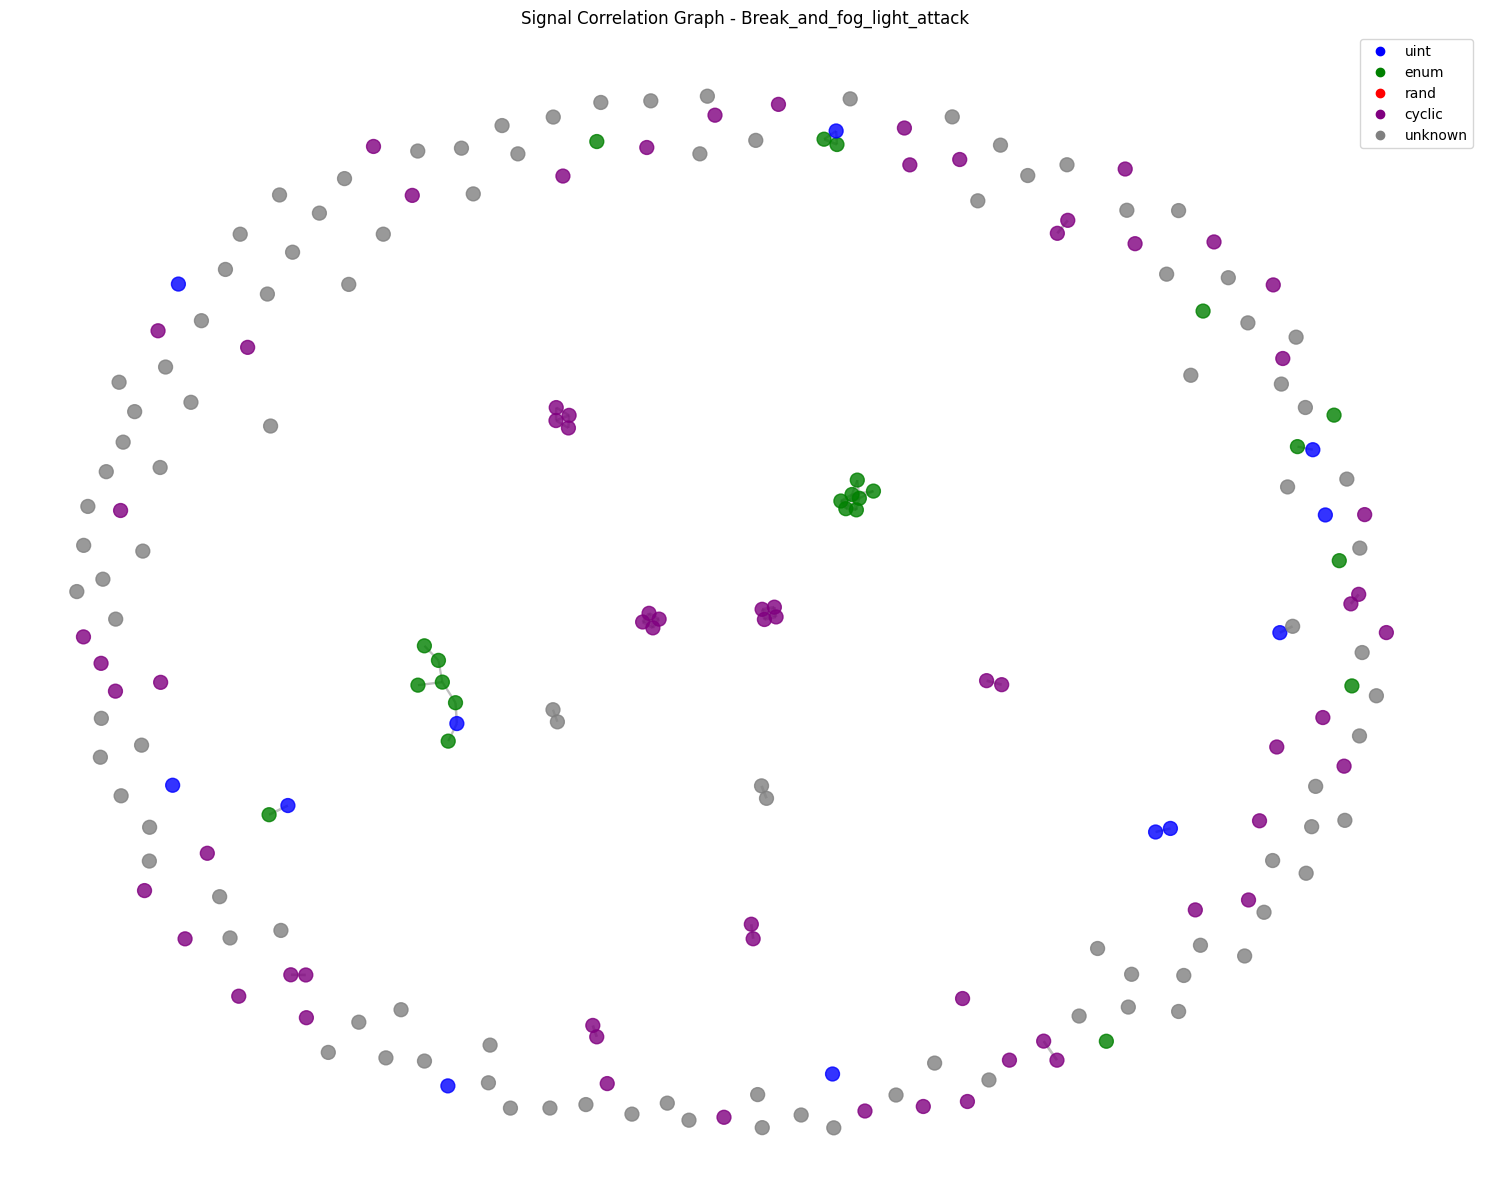

Loaded signals pickle: 56 CAN IDs

Available CAN IDs:
1. 595 (5 signals)
2. 5FF (5 signals)
3. 57F (1 signals)
4. 372 (3 signals)
5. 386 (8 signals)
6. 130 (7 signals)
7. 507 (1 signals)
8. 553 (3 signals)
9. 38D (2 signals)
10. 596 (5 signals)
11. 500 (1 signals)
12. 381 (9 signals)
13. 544 (1 signals)
14. 4F1 (5 signals)
15. 4A7 (1 signals)
16. 470 (13 signals)
17. 50A (1 signals)
18. 251 (9 signals)
19. 421 (4 signals)
20. 140 (4 signals)
...and 36 more

Enter the number of the CAN ID to display (0 to skip): 0
Loaded signal summary: 206 signals


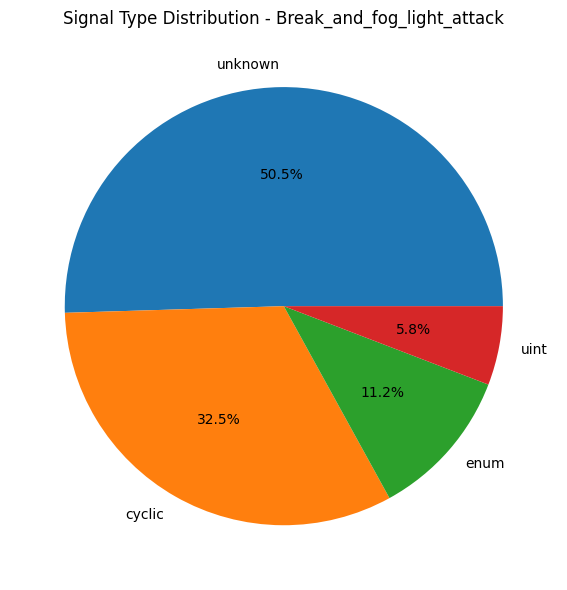

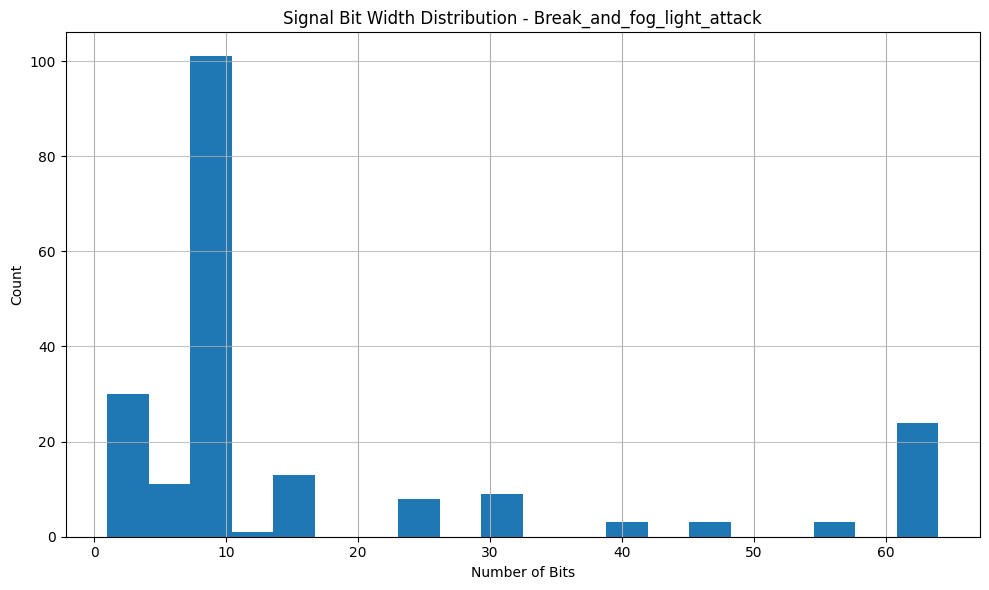


View another file? (y/n): n


In [ ]:
def explore_autocan_results_interactive(results_dir="autocan_results", file_to_display=None):
    """
    Load and display the saved AutoCAN analysis results interactively.

    Args:
        results_dir: The directory containing the analysis results
        file_to_display: Specific file to display (None to select interactively)
    """
    print(f"Exploring results in {results_dir}...")

    # Find all subdirectories (one per log file)
    subdirs = [d for d in os.listdir(results_dir)
               if os.path.isdir(os.path.join(results_dir, d))
               and d not in ["combined_results", "visualizations", "interactive_visualizations", "log_analysis"]]

    if not subdirs:
        print("No analysis subdirectories found.")
        return

    print(f"Found {len(subdirs)} analysis directories.")

    # If no specific file is provided, allow the user to select one
    if file_to_display is None:
        print("\nAvailable files:")
        for i, subdir in enumerate(subdirs):
            print(f"{i+1}. {subdir}")

        try:
            selection = int(input("\nEnter the number of the file to display (0 to exit): "))
            if selection == 0:
                return
            file_to_display = subdirs[selection-1]
        except (ValueError, IndexError):
            print("Invalid selection. Exiting.")
            return

    subdir_path = os.path.join(results_dir, file_to_display)
    print(f"\nDisplaying results for {file_to_display}...")

    # Load correlation graph if available
    graphml_path = os.path.join(subdir_path, "correlation_graph.graphml")
    if os.path.exists(graphml_path):
        try:
            G = nx.read_graphml(graphml_path)
            print(f"Loaded correlation graph: {len(G.nodes)} nodes, {len(G.edges)} edges")

            # Visualize correlation graph
            plt.figure(figsize=(15, 12))

            # Create position layout
            pos = nx.spring_layout(G, seed=42)

            # Get node colors based on signal type
            type_colors = {
                'uint': 'blue',
                'enum': 'green',
                'rand': 'red',
                'cyclic': 'purple',
                'unknown': 'gray'
            }

            # Extract node types
            node_colors = []
            for node in G.nodes():
                node_type = G.nodes[node].get('signal_type', 'unknown')
                node_colors.append(type_colors.get(node_type, 'gray'))

            # Get edge weights
            edge_weights = []
            for u, v in G.edges():
                weight = float(G.edges[u, v].get('weight', 1.0))
                edge_weights.append(weight * 2)

            # Plot the graph
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.8, node_size=100)
            nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray')

            # Create a custom legend
            for signal_type, color in type_colors.items():
                plt.plot([], [], 'o', color=color, label=signal_type)

            plt.legend(loc='upper right')
            plt.title(f'Signal Correlation Graph - {file_to_display}')
            plt.axis('off')
            plt.tight_layout()
            plt.show()  # This will display the plot instead of saving it

        except Exception as e:
            print(f"Error processing correlation graph: {e}")
    else:
        print("No correlation graph found.")

    # Load signals pickle and display signal values
    pkl_path = os.path.join(subdir_path, "signals.pkl")
    if os.path.exists(pkl_path):
        try:
            with open(pkl_path, 'rb') as f:
                signals_by_id = pickle.load(f)
            print(f"Loaded signals pickle: {len(signals_by_id)} CAN IDs")

            # Let the user choose a CAN ID to display
            can_ids = list(signals_by_id.keys())
            print("\nAvailable CAN IDs:")
            for i, can_id in enumerate(can_ids[:min(20, len(can_ids))]):  # Show first 20 IDs
                signal_count = len(signals_by_id[can_id])
                print(f"{i+1}. {can_id} ({signal_count} signals)")

            if len(can_ids) > 20:
                print(f"...and {len(can_ids) - 20} more")

            try:
                selection = int(input("\nEnter the number of the CAN ID to display (0 to skip): "))
                if selection > 0:
                    selected_can_id = can_ids[selection-1]
                    signals = signals_by_id[selected_can_id]

                    if signals:
                        plt.figure(figsize=(15, 8))
                        for i, signal in enumerate(signals[:10]):  # Plot up to 10 signals
                            if signal.values:
                                plt.plot(signal.values[:200],
                                        label=f"Signal {i} [{signal.start_bit}:{signal.start_bit+signal.num_bits-1}] - {signal.signal_type}")

                        plt.title(f'Signal Values - CAN ID: {selected_can_id}')
                        plt.xlabel('Frame Index')
                        plt.ylabel('Signal Value')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.show()  # This will display the plot instead of saving it

                        # Display HAMD (Hamming distance) visualization for selected signals
                        plt.figure(figsize=(12, 6))
                        for i, signal in enumerate(signals[:5]):  # Plot up to 5 signals
                            if signal.hamd:
                                plt.plot(signal.hamd,
                                        label=f"Signal {i} [{signal.start_bit}:{signal.start_bit+signal.num_bits-1}] - {signal.signal_type}")

                        plt.title(f'HAMD Distribution - CAN ID: {selected_can_id}')
                        plt.xlabel('Bit Position')
                        plt.ylabel('Flip Rate')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
                        plt.show()  # This will display the plot instead of saving it
            except (ValueError, IndexError):
                print("Invalid selection. Skipping signal display.")

        except Exception as e:
            print(f"Error processing signals pickle: {e}")
    else:
        print("No signals pickle found.")

    # Load signal summary and display distributions
    csv_path = os.path.join(subdir_path, "signal_summary.csv")
    if os.path.exists(csv_path):
        try:
            signal_df = pd.read_csv(csv_path)
            print(f"Loaded signal summary: {len(signal_df)} signals")

            # Create signal type distribution pie chart
            plt.figure(figsize=(10, 6))
            signal_df['signal_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
            plt.title(f'Signal Type Distribution - {file_to_display}')
            plt.ylabel('')  # Hide "None" label
            plt.tight_layout()
            plt.show()  # This will display the plot instead of saving it

            # Create signal bit width histogram
            plt.figure(figsize=(10, 6))
            signal_df['num_bits'].hist(bins=20)
            plt.title(f'Signal Bit Width Distribution - {file_to_display}')
            plt.xlabel('Number of Bits')
            plt.ylabel('Count')
            plt.grid(axis='y', alpha=0.75)
            plt.tight_layout()
            plt.show()  # This will display the plot instead of saving it

        except Exception as e:
            print(f"Error processing signal summary: {e}")
    else:
        print("No signal summary found.")

    # Ask if the user wants to view another file
    if input("\nView another file? (y/n): ").lower().startswith('y'):
        explore_autocan_results_interactive(results_dir)

if __name__ == "__main__":
    # Run the interactive exploration
    explore_autocan_results_interactive()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import correlate
import networkx as nx
from collections import defaultdict
import itertools
from typing import List, Dict, Tuple, Any, Optional, Set, Union
import os
import pickle
from tqdm import tqdm
import glob
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

# Keep all the existing classes (CANFrame, CANTrace, CANSignal, AutoCANAnalyzer)
# as defined in the original code

class CANFrame:
    """Represents a single CAN frame with ID and payload."""

    def __init__(self, can_id: str, payload: str, timestamp: float = 0.0):
        """
        Initialize a CAN frame.

        Args:
            can_id: The CAN ID in hexadecimal format (e.g. '0x123')
            payload: The payload in hexadecimal format (e.g. '00FF34A2')
            timestamp: The timestamp when the frame was captured
        """
        self.can_id = can_id
        self.payload = payload
        self.timestamp = timestamp

        # Convert payload to binary representation
        try:
            self.binary_payload = bin(int(payload, 16))[2:].zfill(len(payload) * 4)
        except ValueError:
            self.binary_payload = '0' * 64  # Default to 64 bits for invalid payloads

    def get_bit(self, bit_position: int) -> int:
        """Get the value of a specific bit in the payload."""
        if bit_position < len(self.binary_payload):
            return int(self.binary_payload[bit_position])
        return 0

    def get_byte(self, byte_position: int) -> int:
        """Get the value of a specific byte in the payload."""
        start_bit = byte_position * 8
        end_bit = start_bit + 8
        if start_bit < len(self.binary_payload):
            byte_str = self.binary_payload[start_bit:min(end_bit, len(self.binary_payload))]
            byte_str = byte_str.ljust(8, '0')
            return int(byte_str, 2)
        return 0

    def get_bits(self, start_bit: int, num_bits: int) -> int:
        """Get a range of bits as a single integer value."""
        end_bit = start_bit + num_bits
        if start_bit < len(self.binary_payload):
            bits_str = self.binary_payload[start_bit:min(end_bit, len(self.binary_payload))]
            bits_str = bits_str.ljust(num_bits, '0')
            return int(bits_str, 2)
        return 0

    def __str__(self) -> str:
        return f"CANFrame(id={self.can_id}, payload={self.payload}, ts={self.timestamp})"


class CANTrace:
    """Collection of CAN frames representing a vehicle trace."""

    def __init__(self, frames: Optional[List[CANFrame]] = None):
        """
        Initialize a CAN trace with optional frames.

        Args:
            frames: List of CANFrame objects
        """
        self.frames = frames or []
        self.frames_by_id = defaultdict(list)
        self._update_frame_index()

    def _update_frame_index(self):
        """Update the index of frames by CAN ID."""
        self.frames_by_id = defaultdict(list)
        for frame in self.frames:
            self.frames_by_id[frame.can_id].append(frame)

    def add_frame(self, frame: CANFrame):
        """Add a single frame to the trace."""
        self.frames.append(frame)
        self.frames_by_id[frame.can_id].append(frame)

    def add_frames(self, frames: List[CANFrame]):
        """Add multiple frames to the trace."""
        self.frames.extend(frames)
        self._update_frame_index()

    def get_frames_by_id(self, can_id: str) -> List[CANFrame]:
        """Get all frames with a specific CAN ID."""
        return self.frames_by_id.get(can_id, [])

    def get_unique_ids(self) -> Set[str]:
        """Get the set of unique CAN IDs in the trace."""
        return set(self.frames_by_id.keys())

    @classmethod
    def from_log(cls, filepath):
        trace = cls()
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue  # skip empty lines

                if line.startswith('('):
                    end_idx = line.find(')')
                    ts_str = line[1:end_idx]
                    timestamp = float(ts_str)
                else:
                    continue  # skip invalid format lines

                remaining = line[end_idx+1:].strip()
                parts = remaining.split()
                if len(parts) < 2:
                    continue  # malformed line

                id_payload = parts[1] if '#' in parts[1] else parts[0]
                if '#' not in id_payload:
                    continue  # invalid payload

                id_str, data_str = id_payload.split('#', 1)
                try:
                    can_id = int(id_str, 16)
                except ValueError:
                    continue

                data_bytes = [int(data_str[i:i+2], 16) for i in range(0, len(data_str), 2)]

                # Create CANFrame with matching signature
                frame = CANFrame(can_id=f"{can_id:X}", payload=''.join(f"{byte:02X}" for byte in data_bytes), timestamp=timestamp)
                trace.frames.append(frame)

        trace._update_frame_index()
        return trace


    def __len__(self) -> int:
        return len(self.frames)

    def __str__(self) -> str:
        return f"CANTrace(frames={len(self.frames)}, unique_ids={len(self.get_unique_ids())})"


class CANSignal:
    """Represents a decoded signal within CAN frames."""

    SIGNAL_TYPES = ['uint', 'enum', 'rand', 'cyclic']

    def __init__(self, can_id: str, start_bit: int, num_bits: int, signal_type: str = 'unknown'):
        """
        Initialize a CAN signal.

        Args:
            can_id: The CAN ID this signal belongs to
            start_bit: Starting bit position (0-indexed)
            num_bits: Number of bits in the signal
            signal_type: Type of signal ('uint', 'enum', 'rand', 'cyclic', or 'unknown')
        """
        self.can_id = can_id
        self.start_bit = start_bit
        self.num_bits = num_bits
        self.signal_type = signal_type if signal_type in self.SIGNAL_TYPES else 'unknown'
        self.label = None
        self.values = []  # Will hold the signal values extracted from frames
        self.timestamps = []  # Timestamps corresponding to values

        # Statistics calculated later
        self.autocorrelation = None
        self.hamd = None
        self.min_value = None
        self.max_value = None
        self.avg_value = None
        self.std_value = None
        self.distinct_values = None
        self.flip_rate = None

    def extract_values(self, frames: List[CANFrame]):
        """Extract signal values from a list of CAN frames."""
        self.values = []
        self.timestamps = []

        for frame in frames:
            value = frame.get_bits(self.start_bit, self.num_bits)
            self.values.append(value)
            self.timestamps.append(frame.timestamp)

        # Calculate basic statistics
        if self.values:
            self.min_value = min(self.values)
            self.max_value = max(self.values)
            self.avg_value = sum(self.values) / len(self.values)
            self.std_value = np.std(self.values) if len(self.values) > 1 else 0
            self.distinct_values = len(set(self.values))

            # Calculate flip rate
            if len(self.values) > 1:
                flips = sum(1 for i in range(len(self.values)-1) if self.values[i] != self.values[i+1])
                self.flip_rate = flips / (len(self.values) - 1)
            else:
                self.flip_rate = 0

    def calculate_autocorrelation(self, max_lag: int = 100):
        """Calculate the autocorrelation function for the signal values."""
        if len(self.values) > max_lag:
            # Normalize the values
            normalized = np.array(self.values) - np.mean(self.values)
            if np.std(normalized) > 0:
                normalized = normalized / np.std(normalized)

                # Calculate autocorrelation
                self.autocorrelation = [1.0]  # Lag 0 is always 1.0
                for lag in range(1, max_lag):
                    corr = np.corrcoef(normalized[:-lag], normalized[lag:])[0, 1]
                    self.autocorrelation.append(corr)
            else:
                self.autocorrelation = [0.0] * max_lag
        else:
            self.autocorrelation = [0.0] * max_lag

    def calculate_hamd(self):
        """Calculate the Hamming distance distribution (HAMD) for the signal."""
        if len(self.values) <= 1:
            self.hamd = [0.0] * self.num_bits
            return

        # Convert values to binary sequences
        binary_values = [format(v, f'0{self.num_bits}b') for v in self.values]

        # Calculate HAMD for each bit position
        self.hamd = []
        for bit_pos in range(self.num_bits):
            # Extract the bit at this position for all values
            bits = [int(binary_values[j][bit_pos]) for j in range(len(binary_values))]

            # Count flips
            flips = sum(1 for j in range(len(bits)-1) if bits[j] != bits[j+1])
            flip_rate = flips / (len(bits) - 1) if len(bits) > 1 else 0
            self.hamd.append(flip_rate)

    def is_likely_uint(self) -> bool:
        """Check if the signal is likely an unsigned integer."""
        if not self.hamd:
            return False

        # Check for increasing HAMD pattern typical of little-endian integers
        increasing = all(self.hamd[i] <= self.hamd[i+1] for i in range(len(self.hamd)-1))
        return increasing and self.flip_rate > 0.01

    def is_likely_enum(self) -> bool:
        """Check if the signal is likely an enumeration."""
        if not self.hamd:
            return False

        # Enums typically have a low number of distinct values relative to possible values
        max_possible = 2 ** self.num_bits
        enum_threshold = min(32, max_possible * 0.1)  # Heuristic threshold

        return (self.distinct_values <= enum_threshold and
                self.distinct_values > 1 and
                self.flip_rate < 0.3)

    def is_likely_random(self) -> bool:
        """Check if the signal is likely random (like a checksum)."""
        if not self.hamd or not self.autocorrelation:
            return False

        # Random signals have high entropy and low autocorrelation
        high_entropy = self.distinct_values > min(100, 2 ** self.num_bits * 0.5)
        low_autocorr = all(abs(ac) < 0.3 for ac in self.autocorrelation[1:10] if ac is not None)

        return high_entropy and low_autocorr and self.flip_rate > 0.3

    def is_likely_cyclic(self) -> bool:
        """Check if the signal is likely cyclic (counter, clock)."""
        if not self.autocorrelation or len(self.autocorrelation) < 10:
            return False

        # Cyclic signals show oscillatory autocorrelation
        oscillatory = False
        if len(self.autocorrelation) > 2:
            # Check for sign changes in autocorrelation - typical of oscillatory signals
            sign_changes = sum(1 for i in range(1, len(self.autocorrelation)-1)
                              if (self.autocorrelation[i] * self.autocorrelation[i+1]) < 0)
            oscillatory = sign_changes >= 3

        # Also check for steadily increasing values with wrap-around
        if len(self.values) > 10:
            increasing_count = sum(1 for i in range(len(self.values)-1)
                                  if self.values[i+1] == (self.values[i] + 1) % (2**self.num_bits))
            perfect_counter = increasing_count > len(self.values) * 0.8
            return oscillatory or perfect_counter

        return oscillatory

    def determine_signal_type(self):
        """Determine the most likely signal type based on signal characteristics."""
        # Make sure we have calculated all necessary characteristics
        if self.hamd is None:
            self.calculate_hamd()
        if self.autocorrelation is None:
            self.calculate_autocorrelation()

        # Check conditions for each type
        if self.is_likely_cyclic():
            self.signal_type = 'cyclic'
        elif self.is_likely_random():
            self.signal_type = 'rand'
        elif self.is_likely_enum():
            self.signal_type = 'enum'
        elif self.is_likely_uint():
            self.signal_type = 'uint'
        else:
            self.signal_type = 'unknown'

    def __str__(self) -> str:
        label_str = f", label={self.label}" if self.label else ""
        return (f"CANSignal(id={self.can_id}, bits=[{self.start_bit}:{self.start_bit+self.num_bits}], "
                f"type={self.signal_type}{label_str})")


class AutoCANAnalyzer:
    """
    Implements the AutoCAN methodology for automatic reverse engineering of CAN signals.
    """

    def __init__(self, can_trace: CANTrace):
        """
        Initialize the analyzer with a CAN trace.

        Args:
            can_trace: A CANTrace object containing the frames to analyze
        """
        self.can_trace = can_trace
        self.signals_by_id = {}  # Dict of signals by CAN ID
        self.correlation_graph = None

    def identify_signals(self, progress_bar=True):
        """
        Identify signals for all CAN IDs in the trace.

        Args:
            progress_bar: Whether to show a progress bar
        """
        unique_ids = self.can_trace.get_unique_ids()

        if progress_bar:
            id_iterator = tqdm(unique_ids, desc="Identifying signals")
        else:
            id_iterator = unique_ids

        for can_id in id_iterator:
            frames = self.can_trace.get_frames_by_id(can_id)
            if len(frames) > 10:  # Skip IDs with too few frames
                self.signals_by_id[can_id] = self.identify_signals_for_id(can_id, frames)

    def identify_signals_for_id(self, can_id: str, frames: List[CANFrame]) -> List[CANSignal]:
        """
        Identify signals for a specific CAN ID.

        Args:
            can_id: The CAN ID to analyze
            frames: List of frames with this CAN ID

        Returns:
            List of identified CANSignal objects
        """
        # Step 1: Extract byte-level features
        byte_features = self._extract_byte_features(frames)

        # Step 2: Cluster bytes using DBSCAN
        byte_clusters = self._cluster_bytes(byte_features)

        # Step 3: Process each byte cluster to identify bit-level signals
        signals = []
        for cluster_id, byte_indices in byte_clusters.items():
            # Skip noise cluster (cluster_id = -1)
            if cluster_id == -1:
                continue

            # Extract bit-level features for this cluster
            start_bit = min(byte_indices) * 8
            end_bit = (max(byte_indices) + 1) * 8 - 1
            cluster_signals = self._identify_bit_level_signals(frames, start_bit, end_bit)
            signals.extend(cluster_signals)

        # Extract values and determine signal types
        for signal in signals:
            signal.extract_values(frames)
            signal.calculate_autocorrelation()
            signal.calculate_hamd()
            signal.determine_signal_type()

        return signals

    def _extract_byte_features(self, frames: List[CANFrame]) -> np.ndarray:
        """
        Extract byte-level features from a list of frames.

        Args:
            frames: List of CAN frames

        Returns:
            2D array of features (rows=bytes, columns=features)
        """
        max_bytes = 8  # Standard CAN frame has 8 bytes max

        # Create arrays for feature extraction
        byte_values = np.zeros((max_bytes, len(frames)), dtype=int)

        # Extract byte values
        for byte_idx in range(max_bytes):
            for frame_idx, frame in enumerate(frames):
                byte_values[byte_idx, frame_idx] = frame.get_byte(byte_idx)

        # Calculate features for each byte
        features = []
        for byte_idx in range(max_bytes):
            byte_data = byte_values[byte_idx, :]

            # Calculate flip rate
            flips = sum(1 for i in range(len(byte_data)-1) if byte_data[i] != byte_data[i+1])
            flip_rate = flips / (len(byte_data) - 1) if len(byte_data) > 1 else 0

            # Calculate average value
            avg_value = np.mean(byte_data)

            # Calculate distinct value ratio
            distinct_values = len(np.unique(byte_data))
            distinct_ratio = distinct_values / 256  # 256 possible values for a byte

            # Entropy
            values, counts = np.unique(byte_data, return_counts=True)
            probs = counts / len(byte_data)
            entropy = -np.sum(probs * np.log2(probs + 1e-10))

            features.append([flip_rate, avg_value / 255, distinct_ratio, entropy / 8])

        return np.array(features)

    def _cluster_bytes(self, byte_features: np.ndarray, eps=0.4, min_samples=2) -> Dict[int, List[int]]:
        """
        Cluster bytes based on their features using DBSCAN.

        Args:
            byte_features: 2D array of byte features
            eps: DBSCAN epsilon parameter
            min_samples: DBSCAN min_samples parameter

        Returns:
            Dictionary mapping cluster IDs to lists of byte indices
        """
        # Apply DBSCAN to group related bytes
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(byte_features)
        labels = clustering.labels_

        # Group bytes by cluster
        clusters = defaultdict(list)
        for i, label in enumerate(labels):
            clusters[label].append(i)

        # Refine clusters to ensure they contain consecutive bytes
        refined_clusters = {}
        next_cluster_id = max(clusters.keys()) + 1 if clusters else 0

        for cluster_id, byte_indices in clusters.items():
            # Skip noise cluster as we'll process them individually
            if cluster_id == -1:
                for idx in byte_indices:
                    refined_clusters[next_cluster_id] = [idx]
                    next_cluster_id += 1
                continue

            # Sort byte indices
            byte_indices.sort()

            # Find consecutive chunks
            chunks = []
            current_chunk = [byte_indices[0]]

            for i in range(1, len(byte_indices)):
                if byte_indices[i] == byte_indices[i-1] + 1:
                    current_chunk.append(byte_indices[i])
                else:
                    chunks.append(current_chunk)
                    current_chunk = [byte_indices[i]]

            if current_chunk:
                chunks.append(current_chunk)

            # Create a new cluster for each chunk
            for chunk in chunks:
                refined_clusters[next_cluster_id] = chunk
                next_cluster_id += 1

        return refined_clusters

    def _identify_bit_level_signals(self, frames: List[CANFrame], start_bit: int, end_bit: int) -> List[CANSignal]:
        """
        Identify bit-level signals within a byte cluster.

        Args:
            frames: List of CAN frames
            start_bit: Starting bit position
            end_bit: Ending bit position

        Returns:
            List of identified CANSignal objects
        """
        can_id = frames[0].can_id
        num_bits = end_bit - start_bit + 1

        # For small bit ranges (8 bits or less), try to determine if this is a single signal
        if num_bits <= 8:
            signal = CANSignal(can_id, start_bit, num_bits)
            return [signal]

        # Extract bit flip rates
        bit_flip_rates = self._calculate_bit_flip_rates(frames, start_bit, end_bit)

        # Use DBSCAN to cluster bits based on flip rates
        bit_clusters = self._cluster_bits(bit_flip_rates)

        # Create signals from bit clusters
        signals = []
        for cluster_bits in bit_clusters:
            # Sort bits to ensure consecutive ordering
            cluster_bits.sort()

            # Find consecutive chunks of bits
            chunks = []
            current_chunk = [cluster_bits[0]]

            for i in range(1, len(cluster_bits)):
                if cluster_bits[i] == cluster_bits[i-1] + 1:
                    current_chunk.append(cluster_bits[i])
                else:
                    chunks.append(current_chunk)
                    current_chunk = [cluster_bits[i]]

            if current_chunk:
                chunks.append(current_chunk)

            # Create a signal for each chunk
            for chunk in chunks:
                chunk_start = start_bit + chunk[0]
                chunk_length = len(chunk)
                signal = CANSignal(can_id, chunk_start, chunk_length)
                signals.append(signal)

        return signals

    def _calculate_bit_flip_rates(self, frames: List[CANFrame], start_bit: int, end_bit: int) -> List[float]:
        """
        Calculate flip rates for each bit in the specified range.

        Args:
            frames: List of CAN frames
            start_bit: Starting bit position
            end_bit: Ending bit position

        Returns:
            List of flip rates for each bit
        """
        num_bits = end_bit - start_bit + 1
        bit_values = np.zeros((num_bits, len(frames)), dtype=int)

        # Extract bit values
        for bit_idx in range(num_bits):
            for frame_idx, frame in enumerate(frames):
                bit_values[bit_idx, frame_idx] = frame.get_bit(start_bit + bit_idx)

        # Calculate flip rates
        flip_rates = []
        for bit_idx in range(num_bits):
            bit_data = bit_values[bit_idx, :]
            flips = sum(1 for i in range(len(bit_data)-1) if bit_data[i] != bit_data[i+1])
            flip_rate = flips / (len(bit_data) - 1) if len(bit_data) > 1 else 0
            flip_rates.append(flip_rate)

        return flip_rates

    def _cluster_bits(self, bit_flip_rates: List[float], eps=0.15, min_samples=2) -> List[List[int]]:
        """
        Cluster bits based on their flip rates using DBSCAN.

        Args:
            bit_flip_rates: List of bit flip rates
            eps: DBSCAN epsilon parameter
            min_samples: DBSCAN min_samples parameter

        Returns:
            List of lists where each inner list contains bit indices for a cluster
        """
        # Convert flip rates to 2D array for DBSCAN
        X = np.array(bit_flip_rates).reshape(-1, 1)

        # Apply DBSCAN
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = clustering.labels_

        # Group bits by cluster
        clusters = defaultdict(list)
        for i, label in enumerate(labels):
            clusters[label].append(i)

        # Return list of bit clusters (including noise cluster)
        return list(clusters.values())

    def build_correlation_graph(self, min_correlation=0.8):
        """
        Build a graph of signals based on their correlation.

        Args:
            min_correlation: Minimum correlation coefficient to create an edge
        """
        if not self.signals_by_id:
            raise ValueError("No signals identified. Run identify_signals() first.")

        all_signals = []
        for signals in self.signals_by_id.values():
            all_signals.extend(signals)

        G = nx.Graph()

        for i, signal in enumerate(all_signals):
            G.add_node(i,
                      can_id=signal.can_id,
                      signal_type=signal.signal_type,
                      bits=f"{signal.start_bit}:{signal.start_bit+signal.num_bits}",
                      start_bit=signal.start_bit,
                      num_bits=signal.num_bits)

        for i, signal1 in enumerate(all_signals):
            if len(signal1.values) < 10:
                continue

            for j in range(i+1, len(all_signals)):
                signal2 = all_signals[j]
                if len(signal2.values) < 10:
                    continue

                min_len = min(len(signal1.values), len(signal2.values))
                values1 = signal1.values[:min_len]
                values2 = signal2.values[:min_len]

                if len(np.unique(values1)) <= 1 or len(np.unique(values2)) <= 1:
                    continue

                corr = np.corrcoef(values1, values2)[0, 1]

                if abs(corr) >= min_correlation:
                    G.add_edge(i, j, weight=abs(corr))

        self.correlation_graph = G
        return G


    def discover_mathematical_relationships(self):
        """
        Discover mathematical relationships between signals.

        Returns:
            List of tuples (signal1, relationship, signal2, strength)
        """
        # Ensure we have identified signals first
        if not self.signals_by_id:
            raise ValueError("No signals identified. Run identify_signals() first.")

        # Create a flat list of all signals
        all_signals = []
        for signals in self.signals_by_id.values():
            all_signals.extend([s for s in signals if s.signal_type == 'uint' and len(s.values) > 50])

        relationships = []

        # Check for derivative relationships
        for i, signal1 in enumerate(all_signals):
            for j, signal2 in enumerate(all_signals):
                if i == j:
                    continue

                # Ensure signals have enough values
                min_len = min(len(signal1.values), len(signal2.values))
                if min_len < 50:
                    continue

                # Get time-aligned values
                values1 = np.array(signal1.values[:min_len])
                values2 = np.array(signal2.values[:min_len])

                # Check for derivative relationship
                if min_len > 2:
                    derivative1 = np.diff(values1)
                    correlation = np.corrcoef(derivative1, values2[1:min_len])[0, 1]
                    if np.isnan(correlation):
                        continue

                    if abs(correlation) > 0.8:
                        relationships.append((signal1, 'derivative', signal2, abs(correlation)))

                # Check for integral relationship
                if min_len > 2:
                    # Compute a simple integral (cumulative sum)
                    integral2 = np.cumsum(values2)
                    # Compute correlation with values1
                    correlation = np.corrcoef(values1, integral2[:min_len])[0, 1]
                    if np.isnan(correlation):
                        continue

                    if abs(correlation) > 0.8:
                        relationships.append((signal2, 'integral', signal1, abs(correlation)))

        return relationships

    def visualize_hamd_heatmap(self, can_id: str = None, figsize=(12, 8)):
        """
        Visualize the HAMD (Hamming distance distribution) as a heatmap.

        Args:
            can_id: Optional CAN ID to filter by (None for all IDs)
            figsize: Figure size tuple (width, height)
        """
        # Ensure we have identified signals first
        if not self.signals_by_id:
            raise ValueError("No signals identified. Run identify_signals() first.")

        # Get signals for the specified CAN ID or all signals
        if can_id is not None:
            if can_id not in self.signals_by_id:
                raise ValueError(f"No signals found for CAN ID: {can_id}")
            signals = self.signals_by_id[can_id]
        else:
            # Flatten the dict of signals
            signals = []
            for sig_list in self.signals_by_id.values():
                signals.extend(sig_list)

        # Create a list of HAMD values and their bit positions
        hamd_data = []
        for signal in signals:
            if signal.hamd:
                for i, value in enumerate(signal.hamd):
                    hamd_data.append({
                        'can_id': signal.can_id,
                        'bit': signal.start_bit + i,
                        'hamd': value
                    })

        if not hamd_data:
            print("No HAMD data available for visualization.")
            return

        # Convert to DataFrame for easier plotting
        df = pd.DataFrame(hamd_data)

        # Create a pivot table for the heatmap
        pivot_df = df.pivot_table(index='can_id', columns='bit', values='hamd', aggfunc='mean')

        # Plot the heatmap
        plt.figure(figsize=figsize)
        sns.heatmap(pivot_df, cmap='viridis', linewidths=0.5, linecolor='black')
        plt.title('HAMD Heatmap')
        plt.xlabel('Bit Position')
        plt.ylabel('CAN ID')
        plt.tight_layout()
        plt.show()

    def visualize_correlation_graph(self, figsize=(12, 10)):
        """
        Visualize the correlation graph of signals.

        Args:
            figsize: Figure size tuple (width, height)
        """
        if self.correlation_graph is None:
            self.build_correlation_graph()

        if len(self.correlation_graph) == 0:
            print("No correlations found to visualize.")
            return

        # Create position layout
        pos = nx.spring_layout(self.correlation_graph, seed=42)

        # Get node colors based on signal type
        type_colors = {
            'uint': 'blue',
            'enum': 'green',
            'rand': 'red',
            'cyclic': 'purple',
            'unknown': 'gray'
        }

        node_colors = [
            type_colors[self.correlation_graph.nodes[n]['signal_type']]
            for n in self.correlation_graph.nodes
        ]

        # Get edge weights
        edge_weights = [
            self.correlation_graph[u][v]['weight'] * 3
            for u, v in self.correlation_graph.edges
        ]

        # Create the plot
        plt.figure(figsize=figsize)
        nx.draw_networkx_nodes(
            self.correlation_graph, pos,
            node_color=node_colors, alpha=0.8
        )
        nx.draw_networkx_edges(
            self.correlation_graph, pos,
            width=edge_weights, alpha=0.5
        )

        # Add labels
        labels = {
            n: f"{self.correlation_graph.nodes[n]['can_id']}\n{self.correlation_graph.nodes[n]['bits']}"
            for n in self.correlation_graph.nodes
        }
        nx.draw_networkx_labels(
            self.correlation_graph, pos, labels, font_size=8
        )

        # Add legend
        legend_elements = [
            plt.Line2D(
                [0], [0], marker='o', color='w',
                markerfacecolor=color, markersize=10, label=type_
            )
            for type_, color in type_colors.items()
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.title('Signal Correlation Graph')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def save_results(self, output_dir: str):
        """Save results to the specified output directory."""
        os.makedirs(output_dir, exist_ok=True)

        # Save identified signals
        with open(os.path.join(output_dir, 'signals.pkl'), 'wb') as f:
            pickle.dump(self.signals_by_id, f)

        # Save signal summary as CSV
        summary_data = []
        for can_id, signals in self.signals_by_id.items():
            for signal in signals:
                summary_data.append({
                    'can_id': can_id,
                    'start_bit': signal.start_bit,
                    'num_bits': signal.num_bits,
                    'signal_type': signal.signal_type,
                    'label': signal.label or '',
                    'min_value': signal.min_value,
                    'max_value': signal.max_value,
                    'avg_value': signal.avg_value,
                    'distinct_values': signal.distinct_values,
                    'flip_rate': signal.flip_rate
                })

        if summary_data:
            pd.DataFrame(summary_data).to_csv(os.path.join(output_dir, 'signal_summary.csv'), index=False)

        # Save correlation graph as GraphML
        if self.correlation_graph is not None:
            nx.write_graphml(self.correlation_graph, os.path.join(output_dir, 'correlation_graph.graphml'))

        print(f"Results saved to {output_dir}")


class MultiFileAnalyzer:
    """
    Class to analyze multiple CAN log files and aggregate results.
    """

    def __init__(self, log_files: List[str], output_dir: str = "autocan_results"):
        """
        Initialize the multi-file analyzer.

        Args:
            log_files: List of paths to CAN log files
            output_dir: Main output directory
        """
        self.log_files = log_files
        self.output_dir = output_dir
        self.analyzers = {}  # Dictionary to store analyzers for each file
        self.combined_signals = {}  # Signals from all files combined
        self.file_stats = {}  # Statistics for each file
        self.common_signals = {}  # Signals common across all files
        self.unique_signals = {}  # Signals unique to specific files

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

    def analyze_files(self, parallel: bool = True):
        """
        Analyze all log files, optionally in parallel.

        Args:
            parallel: Whether to process files in parallel
        """
        if parallel and len(self.log_files) > 1:
            self._analyze_parallel()
        else:
            self._analyze_sequential()

        # Combine results from all files
        self._combine_results()

    def _analyze_sequential(self):
        """Analyze files sequentially."""
        for file_path in tqdm(self.log_files, desc="Analyzing files"):
            self._analyze_single_file(file_path)

    def _analyze_parallel(self):
        """Analyze files in parallel using process pool."""
        num_processors = min(multiprocessing.cpu_count(), len(self.log_files))
        print(f"Using {num_processors} processors for parallel analysis")

        results = {}  # Container for results

        with ProcessPoolExecutor(max_workers=num_processors) as executor:
            # Map file paths to future objects
            futures = {executor.submit(self._analyze_single_file, file_path): file_path
                      for file_path in self.log_files}

            for future in tqdm(as_completed(futures), total=len(futures), desc="Analyzing files"):
                file_path = futures[future]
                try:
                    # Get the result (analyzer) from the completed task
                    result = future.result()
                    if result is not True:  # If it's an analyzer object, not just True
                        file_name = os.path.basename(file_path)
                        results[file_name] = result
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        # Update the main process's analyzers dictionary with results from all workers
        self.analyzers.update(results)

    def _analyze_single_file(self, file_path: str):
        """
        Analyze a single CAN log file.

        Args:
            file_path: Path to the log file
        """
        file_name = os.path.basename(file_path)
        print(f"\nAnalyzing {file_name}...")

        # Create a directory for this file's results
        file_output_dir = os.path.join(self.output_dir, os.path.splitext(file_name)[0])
        os.makedirs(file_output_dir, exist_ok=True)

        try:
            # Load and analyze the trace
            can_trace = CANTrace.from_log(file_path)

            # Store basic statistics
            self.file_stats[file_name] = {
                'frame_count': len(can_trace),
                'unique_id_count': len(can_trace.get_unique_ids()),
                'unique_ids': list(can_trace.get_unique_ids())
            }

            # Create analyzer and identify signals
            analyzer = AutoCANAnalyzer(can_trace)
            analyzer.identify_signals()

            # Build correlation graph
            analyzer.build_correlation_graph()

            # Discover relationships
            relationships = analyzer.discover_mathematical_relationships()

            # Store relationships in file stats
            self.file_stats[file_name]['relationships'] = [
                {
                    'signal1_id': rel[0].can_id,
                    'signal1_bits': f"{rel[0].start_bit}:{rel[0].start_bit+rel[0].num_bits}",
                    'relationship': rel[1],
                    'signal2_id': rel[2].can_id,
                    'signal2_bits': f"{rel[2].start_bit}:{rel[2].start_bit+rel[2].num_bits}",
                    'strength': rel[3]
                }
                for rel in relationships
            ]

            # Save individual file results
            analyzer.save_results(file_output_dir)

            # Store the analyzer for later use
            self.analyzers[file_name] = analyzer

            print(f"Completed analysis of {file_name}")
            return analyzer

        except Exception as e:
            print(f"Error analyzing {file_name}: {e}")
            return False
    def _combine_results(self):
        """Combine results from all analyzed files."""
        print("\nCombining results from all files...")

        # Check if we have any analyzers
        if not self.analyzers:
            print("No files were successfully analyzed. Cannot combine results.")
            return

        # Collect all unique CAN IDs across all files
        all_can_ids = set()
        for file_name, analyzer in self.analyzers.items():
            all_can_ids.update(analyzer.signals_by_id.keys())

        # Check if we found any CAN IDs
        if not all_can_ids:
            print("No CAN IDs found across any files. Cannot combine results.")
            return

        # Prepare combined signals dictionary
        self.combined_signals = {}

        # Find common and unique signals
        common_can_ids = set()
        file_specific_can_ids = defaultdict(set)

        # First pass: collect CAN IDs present in all files
        for can_id in all_can_ids:
            present_in_all = all(can_id in analyzer.signals_by_id
                              for analyzer in self.analyzers.values())
            if present_in_all:
                common_can_ids.add(can_id)
            else:
                # Record which files have this CAN ID
                for file_name, analyzer in self.analyzers.items():
                    if can_id in analyzer.signals_by_id:
                        file_specific_can_ids[file_name].add(can_id)

        # Collect common signals
        for can_id in common_can_ids:
            self.common_signals[can_id] = []
            self.combined_signals[can_id] = []

            # Get all signals for this CAN ID from the first file
            first_file = list(self.analyzers.keys())[0]
            if not self.analyzers[first_file].signals_by_id.get(can_id):
                # Skip if the first file doesn't have this CAN ID (should not happen due to our check)
                continue

            base_signals = self.analyzers[first_file].signals_by_id[can_id]

            for base_signal in base_signals:
                # Check if this signal is present in all files
                signal_in_all = True
                for file_name, analyzer in self.analyzers.items():
                    if file_name == first_file:
                        continue

                    # Skip files that don't have this CAN ID
                    if can_id not in analyzer.signals_by_id:
                        signal_in_all = False
                        break

                    # Look for matching signal (same start bit and num bits)
                    match_found = False
                    for signal in analyzer.signals_by_id[can_id]:
                        if (signal.start_bit == base_signal.start_bit and
                            signal.num_bits == base_signal.num_bits):
                            match_found = True
                            break

                    if not match_found:
                        signal_in_all = False
                        break

                if signal_in_all:
                    self.common_signals[can_id].append(base_signal)

                # Add to combined signals regardless
                self.combined_signals[can_id].append(base_signal)

        # Collect unique signals
        self.unique_signals = defaultdict(dict)
        for file_name, can_ids in file_specific_can_ids.items():
            for can_id in can_ids:
                # Skip if the file doesn't have this CAN ID (should not happen)
                if can_id not in self.analyzers[file_name].signals_by_id:
                    continue

                self.unique_signals[file_name][can_id] = self.analyzers[file_name].signals_by_id[can_id]

                # Add to combined signals if not already present
                if can_id not in self.combined_signals:
                    self.combined_signals[can_id] = self.analyzers[file_name].signals_by_id[can_id].copy()
                else:
                    # Add signals that don't overlap with existing ones
                    existing_signals = self.combined_signals[can_id]
                    for signal in self.analyzers[file_name].signals_by_id[can_id]:
                        overlap = False
                        for existing in existing_signals:
                            # Check if signals overlap
                            signal_start = signal.start_bit
                            signal_end = signal.start_bit + signal.num_bits - 1
                            existing_start = existing.start_bit
                            existing_end = existing.start_bit + existing.num_bits - 1

                            if not (signal_end < existing_start or signal_start > existing_end):
                                overlap = True
                                break

                        if not overlap:
                            self.combined_signals[can_id].append(signal)

        # Generate combined results
        self._generate_combined_report()

    def _generate_combined_report(self):
        """Generate a comprehensive report combining results from all files."""
        print("Generating combined report...")

        # Create a directory for combined results
        combined_dir = os.path.join(self.output_dir, "combined_results")
        os.makedirs(combined_dir, exist_ok=True)

        # Generate file statistics summary
        stats_data = []
        for file_name, stats in self.file_stats.items():
            stats_data.append({
                'file_name': file_name,
                'frame_count': stats['frame_count'],
                'unique_id_count': stats['unique_id_count'],
                'relationship_count': len(stats.get('relationships', []))
            })

        if stats_data:
            pd.DataFrame(stats_data).to_csv(os.path.join(combined_dir, 'file_statistics.csv'), index=False)

        # Generate combined signal summary
        signal_data = []
        for can_id, signals in self.combined_signals.items():
            for signal in signals:
                # Determine which files contain this signal
                containing_files = []
                for file_name, analyzer in self.analyzers.items():
                    if can_id in analyzer.signals_by_id:
                        for file_signal in analyzer.signals_by_id[can_id]:
                            if (file_signal.start_bit == signal.start_bit and
                                file_signal.num_bits == signal.num_bits):
                                containing_files.append(file_name)
                                break

                # Calculate presence percentage
                presence_pct = (len(containing_files) / len(self.analyzers)) * 100

                # Handle potential None values for statistics
                signal_dict = {
                    'can_id': can_id,
                    'start_bit': signal.start_bit,
                    'num_bits': signal.num_bits,
                    'signal_type': signal.signal_type,
                    'presence_percentage': presence_pct,
                    'present_in_files': ', '.join(containing_files),
                    'is_common': presence_pct == 100,
                }

                # Add statistics if available, otherwise use None
                for stat_name in ['min_value', 'max_value', 'avg_value', 'distinct_values', 'flip_rate']:
                    stat_value = getattr(signal, stat_name)
                    signal_dict[stat_name] = stat_value if stat_value is not None else float('nan')

                signal_data.append(signal_dict)

        if signal_data:
            pd.DataFrame(signal_data).to_csv(os.path.join(combined_dir, 'combined_signals.csv'), index=False)

        # Generate Venn diagram of common CAN IDs
        if len(self.analyzers) <= 5:  # Limit to 5 files for Venn diagram clarity
            self._generate_venn_diagram(combined_dir)

        # Generate relationship report
        relationship_data = []
        for file_name, stats in self.file_stats.items():
            for rel in stats.get('relationships', []):
                relationship_data.append({
                    'file_name': file_name,
                    'signal1_id': rel['signal1_id'],
                    'signal1_bits': rel['signal1_bits'],
                    'relationship': rel['relationship'],
                    'signal2_id': rel['signal2_id'],
                    'signal2_bits': rel['signal2_bits'],
                    'strength': rel['strength']
                })

        if relationship_data:
            pd.DataFrame(relationship_data).to_csv(os.path.join(combined_dir, 'relationships.csv'), index=False)

        print(f"Combined report generated in {combined_dir}")

    def _generate_venn_diagram(self, output_dir):
        """Generate a Venn diagram showing overlapping CAN IDs between files."""
        try:
            from matplotlib_venn import venn2, venn3

            # Collect sets of CAN IDs for each file
            file_can_ids = {
                file_name: set(analyzer.signals_by_id.keys())
                for file_name, analyzer in self.analyzers.items()
            }

            # Check if we have any data to visualize
            if not file_can_ids or all(len(ids) == 0 for ids in file_can_ids.values()):
                print("No CAN IDs found to create Venn diagram")
                return

            plt.figure(figsize=(10, 8))

            if len(file_can_ids) == 2:
                # Create a Venn diagram for two files
                file_names = list(file_can_ids.keys())
                # Check if both sets have data
                if len(file_can_ids[file_names[0]]) == 0 or len(file_can_ids[file_names[1]]) == 0:
                    print("One or more files have no CAN IDs for Venn diagram")
                    plt.close()
                    return

                venn2(
                    [file_can_ids[file_names[0]], file_can_ids[file_names[1]]],
                    set_labels=file_names
                )
                plt.title('Common CAN IDs Between Files')
                plt.savefig(os.path.join(output_dir, 'venn_diagram.png'))
                plt.close()

            elif len(file_can_ids) == 3:
                # Create a Venn diagram for three files
                file_names = list(file_can_ids.keys())
                # Check if all three sets have data
                if (len(file_can_ids[file_names[0]]) == 0 or
                    len(file_can_ids[file_names[1]]) == 0 or
                    len(file_can_ids[file_names[2]]) == 0):
                    print("One or more files have no CAN IDs for Venn diagram")
                    plt.close()
                    return

                venn3(
                    [file_can_ids[file_names[0]], file_can_ids[file_names[1]], file_can_ids[file_names[2]]],
                    set_labels=file_names
                )
                plt.title('Common CAN IDs Between Files')
                plt.savefig(os.path.join(output_dir, 'venn_diagram.png'))
                plt.close()

            else:
                # For more than 3 files, create a similarity matrix
                file_names = list(file_can_ids.keys())
                n_files = len(file_names)

                # Check if we have enough data for a meaningful matrix
                empty_files = [name for name in file_names if len(file_can_ids[name]) == 0]
                if empty_files:
                    print(f"The following files have no CAN IDs: {', '.join(empty_files)}")
                    if len(empty_files) == len(file_names):
                        print("Cannot create similarity matrix: all files have no CAN IDs")
                        plt.close()
                        return

                similarity_matrix = np.zeros((n_files, n_files))

                for i in range(n_files):
                    for j in range(n_files):
                        if i == j:
                            similarity_matrix[i, j] = 1.0
                        else:
                            # Avoid division by zero with empty sets
                            union_size = len(file_can_ids[file_names[i]] | file_can_ids[file_names[j]])
                            if union_size > 0:
                                # Jaccard similarity: intersection / union
                                intersection = len(file_can_ids[file_names[i]] & file_can_ids[file_names[j]])
                                similarity_matrix[i, j] = intersection / union_size
                            else:
                                similarity_matrix[i, j] = 0

                plt.figure(figsize=(10, 8))
                sns.heatmap(
                    similarity_matrix,
                    annot=True,
                    xticklabels=[os.path.basename(f) for f in file_names],
                    yticklabels=[os.path.basename(f) for f in file_names],
                    cmap='viridis'
                )
                plt.title('CAN ID Similarity Between Files (Jaccard Index)')
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, 'similarity_matrix.png'))
                plt.close()

        except ImportError:
            print("matplotlib_venn package not available. Skipping Venn diagram generation.")
            # Create a simple bar chart instead
            file_names = list(self.analyzers.keys())

            # Check if we have any analyzers with signals
            valid_counts = [len(analyzer.signals_by_id) for analyzer in self.analyzers.values()]
            if not valid_counts or all(count == 0 for count in valid_counts):
                print("No valid CAN ID counts to visualize")
                return

            can_id_counts = valid_counts

            plt.figure(figsize=(10, 6))
            plt.bar(file_names, can_id_counts)
            plt.title('Number of CAN IDs per File')
            plt.xticks(rotation=45, ha='right')
            plt.ylabel('Count')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'can_id_counts.png'))
            plt.close()

    def visualize_combined_results(self):
        """Generate visualizations for the combined results."""
        print("Generating combined visualizations...")

        # Create a directory for visualizations
        viz_dir = os.path.join(self.output_dir, "visualizations")
        os.makedirs(viz_dir, exist_ok=True)

        # 1. Generate bar chart of signal types across all files
        self._visualize_signal_types(viz_dir)

        # 2. Generate a heatmap of signal presence across files
        self._visualize_signal_presence(viz_dir)

        # 3. Generate network graph of common relationships
        self._visualize_relationship_network(viz_dir)

        print(f"Combined visualizations generated in {viz_dir}")

    def _visualize_signal_types(self, output_dir):
        """Visualize distribution of signal types across files."""
        # Count signal types for each file
        signal_type_counts = defaultdict(lambda: defaultdict(int))

        for file_name, analyzer in self.analyzers.items():
            for signals in analyzer.signals_by_id.values():
                for signal in signals:
                    signal_type_counts[file_name][signal.signal_type] += 1

        # Convert to DataFrame for plotting
        data = []
        for file_name, type_counts in signal_type_counts.items():
            for signal_type, count in type_counts.items():
                data.append({
                    'file_name': os.path.basename(file_name),
                    'signal_type': signal_type,
                    'count': count
                })

        if not data:
            return

        df = pd.DataFrame(data)

        # Create stacked bar chart
        plt.figure(figsize=(12, 7))
        ax = sns.barplot(x='file_name', y='count', hue='signal_type', data=df)
        plt.title('Signal Types Distribution Across Files')
        plt.xlabel('File')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Signal Type')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'signal_types.png'))
        plt.close()

    def _visualize_signal_presence(self, output_dir):
        """Visualize presence of signals across files as a heatmap."""
        # Collect all unique CAN IDs and signal bit ranges
        all_can_ids = set()
        signal_specs = set()  # (can_id, start_bit, num_bits)

        for analyzer in self.analyzers.values():
            for can_id, signals in analyzer.signals_by_id.items():
                all_can_ids.add(can_id)
                for signal in signals:
                    signal_specs.add((can_id, signal.start_bit, signal.num_bits))

        # Check if we have any signals to visualize
        if not signal_specs:
            print("No signals found to visualize presence across files.")
            return

        # Create presence matrix
        file_names = list(self.analyzers.keys())
        if not file_names:
            print("No files to visualize.")
            return

        presence_matrix = np.zeros((len(signal_specs), len(file_names)))

        # Convert signal_specs to list and sort for consistent ordering
        signal_specs = sorted(list(signal_specs))

        for i, (can_id, start_bit, num_bits) in enumerate(signal_specs):
            for j, file_name in enumerate(file_names):
                analyzer = self.analyzers[file_name]
                if can_id in analyzer.signals_by_id:
                    for signal in analyzer.signals_by_id[can_id]:
                        if signal.start_bit == start_bit and signal.num_bits == num_bits:
                            presence_matrix[i, j] = 1
                            break

        # Create signal labels
        signal_labels = [f"{can_id}[{start_bit}:{start_bit+num_bits-1}]"
                        for can_id, start_bit, num_bits in signal_specs]

        # Only plot if we have a reasonable number of signals
        if len(signal_specs) > 100:
            # If too many signals, just show common ones
            common_indices = []
            for i in range(len(signal_specs)):
                if np.all(presence_matrix[i, :] == 1):
                    common_indices.append(i)

            # Check if we found any common signals
            if not common_indices:
                # If no common signals, just take the first 100
                common_indices = list(range(min(100, len(signal_specs))))
                if not common_indices:  # Safety check for empty list
                    print("No signals to visualize in the matrix.")
                    return

                plt_title = 'Top 100 Signals Across Files'
            else:
                plt_title = 'Common Signals Across All Files'

            presence_matrix = presence_matrix[common_indices, :]
            signal_labels = [signal_labels[i] for i in common_indices]

            plt.figure(figsize=(12, max(8, len(common_indices) * 0.25)))
            sns.heatmap(
                presence_matrix,
                cmap=['white', 'darkgreen'],
                linewidths=0.5,
                yticklabels=signal_labels,
                xticklabels=[os.path.basename(f) for f in file_names],
                cbar=False
            )
            plt.title(plt_title)

        elif len(signal_specs) > 0:
            plt.figure(figsize=(12, max(8, len(signal_specs) * 0.25)))
            sns.heatmap(
                presence_matrix,
                cmap=['white', 'darkgreen'],
                linewidths=0.5,
                yticklabels=signal_labels,
                xticklabels=[os.path.basename(f) for f in file_names],
                cbar=False
            )
            plt.title('Signal Presence Across Files')
        else:
            print("No signals to visualize.")
            return

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'signal_presence.png'))
        plt.close()

    def _visualize_relationship_network(self, output_dir):
        """Visualize network of mathematical relationships between signals."""
        # Collect all relationships
        all_relationships = []
        for file_name, stats in self.file_stats.items():
            for rel in stats.get('relationships', []):
                rel_tuple = (
                    rel['signal1_id'], rel['signal1_bits'],
                    rel['relationship'],
                    rel['signal2_id'], rel['signal2_bits'],
                    rel['strength'], file_name
                )
                all_relationships.append(rel_tuple)

        if not all_relationships:
            print("No mathematical relationships found to visualize.")
            return

        # Create a directed graph
        G = nx.DiGraph()

        # Add nodes and edges
        for s1_id, s1_bits, rel_type, s2_id, s2_bits, strength, file_name in all_relationships:
            node1 = f"{s1_id}[{s1_bits}]"
            node2 = f"{s2_id}[{s2_bits}]"

            if node1 not in G:
                G.add_node(node1, can_id=s1_id)
            if node2 not in G:
                G.add_node(node2, can_id=s2_id)

            # Add edge with relationship type and file as attributes
            G.add_edge(node1, node2, relationship=rel_type,
                      strength=strength, file=os.path.basename(file_name))

        if len(G) == 0:
            return

        # Use spring layout for positioning
        pos = nx.spring_layout(G, seed=42)

        plt.figure(figsize=(14, 10))

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue', alpha=0.8)

        # Draw edges with different colors for relationship types
        relationship_colors = {
            'derivative': 'red',
            'integral': 'green',
            'logical': 'blue',
            'counter': 'purple'
        }

        # Group edges by relationship type
        edges_by_type = defaultdict(list)
        for u, v, data in G.edges(data=True):
            rel_type = data.get('relationship', 'other')
            edges_by_type[rel_type].append((u, v))

        # Draw each group with appropriate color
        for rel_type, edges in edges_by_type.items():
            color = relationship_colors.get(rel_type, 'gray')
            nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.7,
                                  edge_color=color, arrowsize=15)

        # Add labels
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

        # Add legend for relationship types
        legend_elements = [
            plt.Line2D([0], [0], color=color, lw=2, label=rel_type)
            for rel_type, color in relationship_colors.items()
            if rel_type in edges_by_type
        ]

        if legend_elements:  # Only add legend if we have elements
            plt.legend(handles=legend_elements, loc='upper right')

        plt.title('Signal Relationship Network')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'relationship_network.png'))
        plt.close()


def main():
    """
    Process all CAN log files and perform comprehensive analysis.
    """
    # Get all log files in the directory
    log_files = glob.glob("*.log")

    if not log_files:
        print("No log files found in the current directory.")
        return

    print(f"Found {len(log_files)} log files: {', '.join(log_files)}")

    # Create analyzer for all files
    analyzer = MultiFileAnalyzer(log_files, output_dir="autocan_results")

    # Analyze all files (parallel by default)
    analyzer.analyze_files()

    # Generate visualizations for combined results
    analyzer.visualize_combined_results()

    print("\nAnalysis complete! Results are in the 'autocan_results' directory.")


if __name__ == "__main__":
    main()

Found 26 log files: Fuzzing_valid_IDs.log, Steering_angle_attack.log, FCA_warning_attack.log, Steering_angle_replay.log, Gear_shifter_attack_1.log, Door_open_warning_attack.log, DoS_attack.log, Min_speedometer_attack_2.log, Fuzzing_valid_IDs_DoS.log, Max_speedometer_attack.log, Break_and_fog_light_attack.log, EMS_attack.log, Min_speedometer_attack_3.log, Drive_mode_changing_attack.log, Parking_break_attack.log, EMS_replay_attack.log, Gear_shifter_attack_2.log, Fuzzing_random_IDs.log, Wiper_warning_attack.log, Multiple_attacks_1.log, Reverse_speedometer_fuzzing_attack.log, Multiple_attacks_2.log, Min_speedometer_attack_1.log, Break_warning_attack.log, EMS_replay_long_attack.log, Power_steering_attack.log
Using 2 processors for parallel analysis


Analyzing files:   0%|          | 0/26 [00:00<?, ?it/s]


Analyzing Fuzzing_valid_IDs.log...
Analyzing Steering_angle_attack.log...



Identifying signals: 100%|██████████| 56/56 [01:03<00:00,  1.14s/it]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Results saved to autocan_results/Fuzzing_valid_IDs
Completed analysis of Fuzzing_valid_IDs.log

Analyzing FCA_warning_attack.log...


Identifying signals:   9%|▉         | 5/56 [00:10<02:03,  2.42s/it]

Results saved to autocan_results/Steering_angle_attack
Completed analysis of Steering_angle_attack.log


Identifying signals:  14%|█▍        | 8/56 [00:15<01:18,  1.63s/it]


Analyzing Steering_angle_replay.log...


Identifying signals: 100%|██████████| 56/56 [01:41<00:00,  1.81s/it]


Results saved to autocan_results/Steering_angle_replay
Completed analysis of Steering_angle_replay.log
Results saved to autocan_results/FCA_warning_attack
Completed analysis of FCA_warning_attack.log

Analyzing Gear_shifter_attack_1.log...


Analyzing files:  12%|█▏        | 3/26 [05:55<50:19, 131.27s/it]


Analyzing Door_open_warning_attack.log...


Identifying signals:  17%|█▋        | 9/54 [00:18<01:37,  2.16s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 54/54 [01:30<00:00,  1.68s/it]


Results saved to autocan_results/Gear_shifter_attack_1
Completed analysis of Gear_shifter_attack_1.log
Results saved to autocan_results/Door_open_warning_attack
Completed analysis of Door_open_warning_attack.log

Analyzing DoS_attack.log...


Analyzing files:  19%|█▉        | 5/26 [09:08<41:46, 119.36s/it]


Analyzing Min_speedometer_attack_2.log...


Identifying signals:  13%|█▎        | 7/55 [00:09<01:08,  1.42s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  94%|█████████▍| 51/54 [01:34<00:09,  3.09s/it]

Results saved to autocan_results/DoS_attack
Completed analysis of DoS_attack.log


Identifying signals:  96%|█████████▋| 52/54 [01:39<00:07,  3.51s/it]


Analyzing Fuzzing_valid_IDs_DoS.log...


Identifying signals:  11%|█         | 6/55 [00:11<02:00,  2.46s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  24%|██▎       | 13/55 [00:17<00:40,  1.04it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  42%|████▏     | 23/55 [00:33<00:28,  1.12it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/d

Results saved to autocan_results/Min_speedometer_attack_2
Completed analysis of Min_speedometer_attack_2.log


Identifying signals:  87%|████████▋ | 48/55 [01:10<00:11,  1.65s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  89%|████████▉ | 49/55 [01:15<00:15,  2.56s/it]


Analyzing Max_speedometer_attack.log...


Identifying signals:   0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  95%|█████████▍| 53/56 [01:16<00:05,  1.86s/it]

Results saved to autocan_results/Fuzzing_valid_IDs_DoS
Completed analysis of Fuzzing_valid_IDs_DoS.log


Identifying signals: 100%|██████████| 56/56 [01:18<00:00,  1.41s/it]



Analyzing Break_and_fog_light_attack.log...


Identifying signals:  36%|███▌      | 20/56 [00:36<01:48,  3.02s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals:  54%|█████▎    | 30/56 [00:48<00:48,  1.85s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Results saved to autocan_results/Max_speedometer_attack
Completed analysis of Max_speedometer_attack.log


Identifying signals:  61%|██████    | 34/56 [00:55<00:29,  1.34s/it]


Analyzing EMS_attack.log...


Identifying signals:  98%|█████████▊| 55/56 [00:59<00:01,  1.42s/it]/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Identifying signals: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it]


Results saved to autocan_results/Break_and_fog_light_attack
Completed analysis of Break_and_fog_light_attack.log

Analyzing Min_speedometer_attack_3.log...


Identifying signals:   0%|          | 0/54 [00:00<?, ?it/s]

Results saved to autocan_results/EMS_attack
Completed analysis of EMS_attack.log


Identifying signals:   4%|▎         | 2/54 [00:00<00:11,  4.37it/s]


Analyzing Drive_mode_changing_attack.log...


Identifying signals: 100%|██████████| 56/56 [00:42<00:00,  1.31it/s]


Results saved to autocan_results/Drive_mode_changing_attack
Completed analysis of Drive_mode_changing_attack.log

Analyzing Parking_break_attack.log...


Analyzing files:  46%|████▌     | 12/26 [18:49<21:58, 94.14s/it]


Analyzing EMS_replay_attack.log...

Analyzing Gear_shifter_attack_2.log...



Identifying signals:  43%|████▎     | 23/54 [00:30<00:40,  1.32s/it]




Analyzing Fuzzing_random_IDs.log...

Analyzing Wiper_warning_attack.log...


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import defaultdict
import os
import logging
import pickle
from typing import List, Dict, Tuple, Optional, Set, Union
from tqdm import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class CANFrame:
    """Represents a single CAN frame with ID and payload."""

    def __init__(self, can_id: str, payload: str, timestamp: float = 0.0):
        """
        Initialize a CAN frame.

        Args:
            can_id: The CAN ID in hexadecimal format (e.g. '0x123')
            payload: The payload in hexadecimal format (e.g. '00FF34A2')
            timestamp: The timestamp when the frame was captured
        """
        self.can_id = can_id
        self.payload = payload
        self.timestamp = timestamp

        # Convert payload to binary representation
        try:
            self.binary_payload = bin(int(payload, 16))[2:].zfill(len(payload) * 4)
        except ValueError:
            self.binary_payload = '0' * 64  # Default to 64 bits for invalid payloads

    def get_bit(self, bit_position: int) -> int:
        """Get the value of a specific bit in the payload."""
        if bit_position < len(self.binary_payload):
            return int(self.binary_payload[bit_position])
        return 0

    def get_byte(self, byte_position: int) -> int:
        """Get the value of a specific byte in the payload."""
        start_bit = byte_position * 8
        end_bit = start_bit + 8
        if start_bit < len(self.binary_payload):
            byte_str = self.binary_payload[start_bit:min(end_bit, len(self.binary_payload))]
            byte_str = byte_str.ljust(8, '0')
            return int(byte_str, 2)
        return 0

    def get_bits(self, start_bit: int, num_bits: int) -> int:
        """Get a range of bits as a single integer value."""
        end_bit = start_bit + num_bits
        if start_bit < len(self.binary_payload):
            bits_str = self.binary_payload[start_bit:min(end_bit, len(self.binary_payload))]
            bits_str = bits_str.ljust(num_bits, '0')
            return int(bits_str, 2)
        return 0

    def __str__(self) -> str:
        return f"CANFrame(id={self.can_id}, payload={self.payload}, ts={self.timestamp})"


class CANTrace:
    """Collection of CAN frames representing a vehicle trace."""

    def __init__(self, frames: Optional[List[CANFrame]] = None):
        """
        Initialize a CAN trace with optional frames.

        Args:
            frames: List of CANFrame objects
        """
        self.frames = frames or []
        self.frames_by_id = defaultdict(list)
        self._update_frame_index()

    def _update_frame_index(self):
        """Update the index of frames by CAN ID."""
        self.frames_by_id = defaultdict(list)
        for frame in self.frames:
            self.frames_by_id[frame.can_id].append(frame)

    def add_frame(self, frame: CANFrame):
        """Add a single frame to the trace."""
        self.frames.append(frame)
        self.frames_by_id[frame.can_id].append(frame)

    def add_frames(self, frames: List[CANFrame]):
        """Add multiple frames to the trace."""
        self.frames.extend(frames)
        self._update_frame_index()

    def get_frames_by_id(self, can_id: str) -> List[CANFrame]:
        """Get all frames with a specific CAN ID."""
        return self.frames_by_id.get(can_id, [])

    def get_unique_ids(self) -> Set[str]:
        """Get the set of unique CAN IDs in the trace."""
        return set(self.frames_by_id.keys())

    @classmethod
    def from_log(cls, filepath):
        """Create a CANTrace object from a log file."""
        trace = cls()
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue  # skip empty lines

                if line.startswith('('):
                    end_idx = line.find(')')
                    ts_str = line[1:end_idx]
                    timestamp = float(ts_str)
                else:
                    continue  # skip invalid format lines

                remaining = line[end_idx+1:].strip()
                parts = remaining.split()
                if len(parts) < 2:
                    continue  # malformed line

                id_payload = parts[1] if '#' in parts[1] else parts[0]
                if '#' not in id_payload:
                    continue  # invalid payload

                id_str, data_str = id_payload.split('#', 1)
                try:
                    can_id = int(id_str, 16)
                except ValueError:
                    continue

                data_bytes = [int(data_str[i:i+2], 16) for i in range(0, len(data_str), 2)]

                # Create CANFrame with matching signature
                frame = CANFrame(can_id=f"{can_id:X}", payload=''.join(f"{byte:02X}" for byte in data_bytes), timestamp=timestamp)
                trace.frames.append(frame)

        trace._update_frame_index()
        return trace

    def __len__(self) -> int:
        return len(self.frames)

    def __str__(self) -> str:
        return f"CANTrace(frames={len(self.frames)}, unique_ids={len(self.get_unique_ids())})"


class DeepCANAnalyzer:
    """
    Advanced CAN signal analyzer using deep convolutional neural networks
    to identify signal patterns and detect anomalies in CAN traffic.
    """

    def __init__(self, can_trace: CANTrace, output_dir: str = "deepcan_results",
                compare_traditional: bool = True):
        """
        Initialize the analyzer with a CAN trace.

        Args:
            can_trace: A CANTrace object containing the frames to analyze
            output_dir: Directory to save results
            compare_traditional: Whether to also run traditional analysis for comparison
        """
        self.can_trace = can_trace
        self.output_dir = output_dir
        self.signals_by_id = {}  # Dict of signals by CAN ID
        self.id_sequences = {}  # ID sequences for CNN input
        self.payload_matrices = {}  # Payload matrices for CNN input
        self.models = {}  # Trained models for each CAN ID
        self.labels = {}  # Signal labels/classifications
        self.compare_traditional = compare_traditional
        self.traditional_results = {}  # Results from traditional methods for comparison

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, "comparative_analysis"), exist_ok=True)

        logger.info(f"Initialized DeepCANAnalyzer with {len(can_trace)} frames and {len(can_trace.get_unique_ids())} unique IDs")

    def extract_signal_frames(self, window_size: int = 100, stride: int = 10):
        """
        Extract signal frames for CNN analysis from the CAN trace.

        Args:
            window_size: Number of consecutive frames to include in each sample
            stride: Stride between consecutive samples
        """
        logger.info(f"Extracting signal frames with window size {window_size} and stride {stride}")

        unique_ids = self.can_trace.get_unique_ids()

        for can_id in tqdm(unique_ids, desc="Processing CAN IDs"):
            frames = self.can_trace.get_frames_by_id(can_id)

            if len(frames) < window_size:
                logger.warning(f"Skipping CAN ID {can_id}: insufficient frames ({len(frames)} < {window_size})")
                continue

            # Create sequence matrices for this CAN ID
            sequences = []
            payloads = []

            for i in range(0, len(frames) - window_size + 1, stride):
                # Get window of frames
                window_frames = frames[i:i+window_size]

                # Extract ID sequence
                id_seq = np.zeros((window_size, 1))
                for j, frame in enumerate(window_frames):
                    id_seq[j] = int(frame.can_id, 16)  # Convert hex ID to int

                # Extract payload matrix (8 bytes x window_size frames)
                payload_matrix = np.zeros((window_size, 8))  # 8 bytes per CAN frame
                for j, frame in enumerate(window_frames):
                    for k in range(8):  # Process each byte
                        payload_matrix[j, k] = frame.get_byte(k)

                sequences.append(id_seq)
                payloads.append(payload_matrix)

            if sequences:
                self.id_sequences[can_id] = np.array(sequences)
                self.payload_matrices[can_id] = np.array(payloads)
                logger.info(f"CAN ID {can_id}: Created {len(sequences)} samples")
            else:
                logger.warning(f"No sequences generated for CAN ID {can_id}")

    def _create_signal_labels(self, can_id: str, cluster_count: int = 3):
        """
        Create initial signal classification labels for supervised learning.
        This is a simplified approach - in practice, would need domain knowledge or
        unsupervised learning to create accurate labels.

        Args:
            can_id: CAN ID to create labels for
            cluster_count: Number of signal types to identify
        """
        if can_id not in self.payload_matrices:
            logger.warning(f"No payload matrices for CAN ID {can_id}")
            return None

        payloads = self.payload_matrices[can_id]

        try:
            # Simple heuristic: use byte activity patterns to separate signals
            # In reality, this should use more sophisticated clustering or domain knowledge
            sample_count = payloads.shape[0]
            byte_activity = np.sum(np.abs(np.diff(payloads, axis=1)), axis=2)

            # Very simple clustering based on average byte activity
            avg_activity = np.mean(byte_activity, axis=1)

            # Ensure we don't try to create more clusters than we have unique values
            unique_vals = np.unique(avg_activity)
            actual_cluster_count = min(cluster_count, len(unique_vals))

            if actual_cluster_count <= 1:
                # If all values are the same, just use one cluster
                return np.zeros(sample_count, dtype=int)

            thresholds = np.quantile(avg_activity, np.linspace(0, 1, actual_cluster_count+1)[1:-1])

            labels = np.zeros(sample_count, dtype=int)
            current_label = 0

            for i in range(len(thresholds)):
                mask = avg_activity > thresholds[i]
                labels[mask] = current_label + 1
                current_label += 1

            logger.info(f"Created {len(np.unique(labels))} signal labels for CAN ID {can_id}")
            return labels

        except Exception as e:
            logger.error(f"Error creating signal labels for CAN ID {can_id}: {str(e)}")
            # Return a default single-class labeling
            return np.zeros(payloads.shape[0], dtype=int)

    def build_cnn_model(self, can_id: str):
        """
        Build and train a CNN model for signal classification for a specific CAN ID.

        Args:
            can_id: CAN ID to build model for
        """
        if can_id not in self.payload_matrices:
            logger.warning(f"No payload matrices for CAN ID {can_id}")
            return

        # Get data
        X = self.payload_matrices[can_id]
        sample_count = X.shape[0]

        # Create labels if not already existing
        if can_id not in self.labels:
            self.labels[can_id] = self._create_signal_labels(can_id)

        if self.labels[can_id] is None:
            return

        y = self.labels[can_id]

        # Find actual number of classes (not assuming consecutive integers starting from 0)
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        # Create a mapping from actual class values to consecutive integers starting from 0
        class_mapping = {cls: i for i, cls in enumerate(unique_classes)}

        # Map the original classes to consecutive integers
        y_mapped = np.array([class_mapping[cls] for cls in y])

        # One-hot encode labels
        y_onehot = tf.keras.utils.to_categorical(y_mapped, num_classes=num_classes)

        # Reshape for CNN input: (samples, height, width, channels)
        X_reshaped = X.reshape(sample_count, X.shape[1], X.shape[2], 1)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_onehot, test_size=0.2, random_state=42)

        logger.info(f"Building CNN model for CAN ID {can_id} with {num_classes} classes")
        logger.info(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

        # Define the CNN model
        model = Sequential([
            # CNN layers
            Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),

            Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
            BatchNormalization(),

            # Flatten and dense layers
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Define callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        checkpoint_path = os.path.join(self.output_dir, f"model_{can_id}.h5")
        checkpoint = ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            monitor='val_accuracy'
        )

        # Save the class mapping for later use
        model.class_mapping = class_mapping
        model.reverse_mapping = {v: k for k, v in class_mapping.items()}

        try:
            # Train model
            history = model.fit(
                X_train, y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, checkpoint]
            )

            # Evaluate model
            test_loss, test_accuracy = model.evaluate(X_test, y_test)
            logger.info(f"Test accuracy for CAN ID {can_id}: {test_accuracy:.4f}")

            # Save the model
            self.models[can_id] = model

            # Plot training history
            self._plot_training_history(history, can_id)

            # Generate classification report
            y_pred = model.predict(X_test)
            y_pred_classes = np.argmax(y_pred, axis=1)
            y_true_classes = np.argmax(y_test, axis=1)

            report = classification_report(y_true_classes, y_pred_classes)
            logger.info(f"Classification report for CAN ID {can_id}:\n{report}")

            # Save classification report
            with open(os.path.join(self.output_dir, f"report_{can_id}.txt"), 'w') as f:
                f.write(report)

            return model

        except Exception as e:
            logger.error(f"Error training model for CAN ID {can_id}: {str(e)}")
            return None

    def _plot_training_history(self, history, can_id: str):
        """Plot and save the training history."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot accuracy
        ax1.plot(history.history['accuracy'])
        ax1.plot(history.history['val_accuracy'])
        ax1.set_title(f'Model Accuracy - CAN ID {can_id}')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'], loc='lower right')

        # Plot loss
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title(f'Model Loss - CAN ID {can_id}')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'], loc='upper right')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"training_history_{can_id}.png"))
        plt.close()

    def analyze_all_signals(self, min_frames: int = 1000):
        """
        Run the full analysis pipeline on all CAN IDs with sufficient data.

        Args:
            min_frames: Minimum number of frames required to analyze a CAN ID
        """
        # Extract signal frames
        self.extract_signal_frames()

        # Build models for each CAN ID with sufficient data
        for can_id in self.can_trace.get_unique_ids():
            frames = self.can_trace.get_frames_by_id(can_id)
            if len(frames) >= min_frames:
                logger.info(f"Analyzing CAN ID {can_id} with {len(frames)} frames")
                self.build_cnn_model(can_id)
            else:
                logger.info(f"Skipping CAN ID {can_id}: insufficient frames ({len(frames)} < {min_frames})")

    def detect_anomalies(self, test_trace: CANTrace, window_size: int = 100, threshold: float = 0.8):
        """
        Detect anomalies in a test trace using the trained models.

        Args:
            test_trace: CANTrace containing potentially anomalous frames
            window_size: Window size for analyzing frames (must match training)
            threshold: Probability threshold for anomaly detection

        Returns:
            Dictionary mapping CAN IDs to lists of anomalous frame indices
        """
        anomalies = {}

        for can_id in self.models:
            model = self.models[can_id]

            # Get frames for this CAN ID
            frames = test_trace.get_frames_by_id(can_id)
            if len(frames) < window_size:
                logger.warning(f"Insufficient frames for CAN ID {can_id} in test trace")
                continue

            # Process frames in sliding windows
            anomalous_windows = []

            for i in range(0, len(frames) - window_size + 1):
                # Get window of frames
                window_frames = frames[i:i+window_size]

                # Extract payload matrix
                payload_matrix = np.zeros((1, window_size, 8))  # 1 sample, window_size frames, 8 bytes
                for j, frame in enumerate(window_frames):
                    for k in range(8):
                        payload_matrix[0, j, k] = frame.get_byte(k)

                # Reshape for model
                payload_matrix = payload_matrix.reshape(1, window_size, 8, 1)

                # Predict
                predictions = model.predict(payload_matrix)[0]
                max_prob = np.max(predictions)

                # Check if anomalous (low confidence)
                if max_prob < threshold:
                    anomalous_windows.append((i, i+window_size-1, max_prob))

            if anomalous_windows:
                anomalies[can_id] = anomalous_windows
                logger.info(f"Detected {len(anomalous_windows)} anomalous windows for CAN ID {can_id}")

        return anomalies

    def identify_signal_patterns(self, can_id: str):
        """
        Identify temporal patterns in signals using trained CNN model.

        Args:
            can_id: CAN ID to analyze patterns for

        Returns:
            Dictionary of detected patterns and their characteristics
        """
        if can_id not in self.models:
            logger.warning(f"No trained model for CAN ID {can_id}")
            return None

        model = self.models[can_id]

        # Get data
        X = self.payload_matrices[can_id]
        sample_count = X.shape[0]
        X_reshaped = X.reshape(sample_count, X.shape[1], X.shape[2], 1)

        # Get predictions
        predictions = model.predict(X_reshaped)
        predicted_classes = np.argmax(predictions, axis=1)

        # Analyze patterns for each predicted class
        patterns = {}

        for class_idx in range(len(np.unique(predicted_classes))):
            # Get samples for this class
            class_samples = X[predicted_classes == class_idx]

            if len(class_samples) == 0:
                continue

            # Calculate average pattern
            avg_pattern = np.mean(class_samples, axis=0)

            # Calculate variance
            var_pattern = np.var(class_samples, axis=0)

            # Calculate temporal characteristics
            temp_diff = np.mean(np.abs(np.diff(class_samples, axis=1)), axis=0)

            # Store results
            patterns[class_idx] = {
                'sample_count': len(class_samples),
                'average_pattern': avg_pattern,
                'variance': var_pattern,
                'temporal_diff': temp_diff
            }

            # Visualize the pattern
            self._visualize_signal_pattern(avg_pattern, var_pattern, class_idx, can_id)

        return patterns

    def _visualize_signal_pattern(self, avg_pattern, var_pattern, class_idx, can_id):
        """Visualize a detected signal pattern."""
        plt.figure(figsize=(12, 6))

        # Plot average pattern
        plt.subplot(1, 2, 1)
        sns.heatmap(avg_pattern, cmap='viridis', xticklabels=range(8), yticklabels=False)
        plt.title(f'Average Pattern - CAN ID {can_id} - Class {class_idx}')
        plt.xlabel('Byte Position')
        plt.ylabel('Frame Sequence')

        # Plot variance
        plt.subplot(1, 2, 2)
        sns.heatmap(var_pattern, cmap='Reds', xticklabels=range(8), yticklabels=False)
        plt.title(f'Pattern Variance - CAN ID {can_id} - Class {class_idx}')
        plt.xlabel('Byte Position')
        plt.ylabel('Frame Sequence')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"pattern_{can_id}_class{class_idx}.png"))
        plt.close()

    def run_traditional_analysis(self, can_id: str):
        """
        Run traditional signal analysis methods for comparison.

        Args:
            can_id: CAN ID to analyze

        Returns:
            Dictionary of results from traditional methods
        """
        frames = self.can_trace.get_frames_by_id(can_id)
        if len(frames) < 100:  # Need sufficient frames for analysis
            return None

        # Extract raw payload data
        payload_data = []
        timestamps = []

        for frame in frames:
            payload_bytes = [frame.get_byte(i) for i in range(8)]
            payload_data.append(payload_bytes)
            timestamps.append(frame.timestamp)

        payload_array = np.array(payload_data)

        # Traditional Method 1: Byte-level statistics
        byte_means = np.mean(payload_array, axis=0)
        byte_stds = np.std(payload_array, axis=0)
        byte_mins = np.min(payload_array, axis=0)
        byte_maxs = np.max(payload_array, axis=0)

        # Traditional Method 2: Change frequency (flip rate)
        changes = np.abs(np.diff(payload_array, axis=0))
        flip_rates = np.sum(changes > 0, axis=0) / (len(payload_array) - 1)

        # Traditional Method 3: Periodicity analysis (simplified)
        periodicities = []
        for byte_idx in range(8):
            byte_values = payload_array[:, byte_idx]
            if np.std(byte_values) > 0:  # Skip constant bytes
                # Autocorrelation approach (simple)
                autocorr = np.correlate(byte_values, byte_values, mode='full')
                autocorr = autocorr[len(autocorr)//2:]  # Second half
                # Find peaks in autocorrelation
                from scipy.signal import find_peaks
                peaks, _ = find_peaks(autocorr, height=0.5*max(autocorr))
                if len(peaks) > 1:
                    # Estimate period from first peak
                    period = peaks[0] if len(peaks) > 0 else 0
                else:
                    period = 0
            else:
                period = 0
            periodicities.append(period)

        results = {
            'byte_statistics': {
                'means': byte_means,
                'stds': byte_stds,
                'mins': byte_mins,
                'maxs': byte_maxs
            },
            'flip_rates': flip_rates,
            'periodicities': periodicities
        }

        self.traditional_results[can_id] = results
        return results

    def generate_comparative_visualizations(self, can_id: str):
        """
        Generate visualizations comparing traditional and deep learning approaches.

        Args:
            can_id: CAN ID to visualize
        """
        if not self.compare_traditional or can_id not in self.models:
            logger.warning(f"Cannot generate comparative visualizations for CAN ID {can_id}")
            return

        if can_id not in self.traditional_results:
            self.run_traditional_analysis(can_id)

        trad_results = self.traditional_results[can_id]
        if trad_results is None:
            return

        # Get CNN results
        patterns = self.identify_signal_patterns(can_id)
        if not patterns:
            return

        try:
            # 1. Compare signal type detection
            plt.figure(figsize=(15, 10))

            # CNN-identified patterns
            plt.subplot(2, 2, 1)
            pattern_data = []
            for class_idx, pattern in patterns.items():
                avg_pattern = pattern['average_pattern']
                for i in range(min(10, avg_pattern.shape[0])):  # Show first 10 frames
                    pattern_data.append(avg_pattern[i])

            if pattern_data:
                sns.heatmap(pattern_data, cmap='viridis', xticklabels=range(8),
                            yticklabels=[f"Class {i//10}-Frame {i%10}" for i in range(len(pattern_data))])
            plt.title("CNN-Identified Signal Patterns")

            # Traditional byte-level statistics
            plt.subplot(2, 2, 2)
            stat_data = np.vstack([
                trad_results['byte_statistics']['means'],
                trad_results['byte_statistics']['stds'],
                trad_results['flip_rates'],
                np.array(trad_results['periodicities']) / max(max(trad_results['periodicities']), 1)
            ])
            sns.heatmap(stat_data, cmap='viridis', xticklabels=range(8),
                       yticklabels=['Mean', 'Std Dev', 'Flip Rate', 'Periodicity'])
            plt.title("Traditional Byte-Level Analysis")

            # 2. Signal pattern visualization
            plt.subplot(2, 2, 3)
            # Get a sample prediction sequence
            X = self.payload_matrices[can_id]
            if len(X) > 0:
                sample_idx = np.random.randint(0, len(X))
                sample = X[sample_idx]

                # Get model prediction
                model = self.models[can_id]
                X_reshaped = sample.reshape(1, sample.shape[0], sample.shape[1], 1)
                pred = model.predict(X_reshaped, verbose=0)  # Add verbose=0 to suppress output
                pred_class = np.argmax(pred[0])

                # Visualize with prediction confidence
                plt.imshow(sample, aspect='auto', cmap='viridis')
                plt.colorbar(label='Byte Value')
                plt.title(f"CNN Pattern Recognition - Class {pred_class} (Conf: {pred[0][pred_class]:.2f})")
                plt.xlabel("Byte Position")
                plt.ylabel("Frame Sequence")

            # Traditional temporal visualization
            plt.subplot(2, 2, 4)
            frames = self.can_trace.get_frames_by_id(can_id)
            if len(frames) > 100:
                # Select a similar window as CNN
                start_idx = np.random.randint(0, len(frames) - 100)
                window_frames = frames[start_idx:start_idx+100]

                # Extract payload data
                payload_data = []
                for frame in window_frames:
                    payload_bytes = [frame.get_byte(i) for i in range(8)]
                    payload_data.append(payload_bytes)
                payload_array = np.array(payload_data)

                # Visualize traditional view
                plt.imshow(payload_array, aspect='auto', cmap='viridis')
                plt.colorbar(label='Byte Value')
                plt.title("Traditional Sequential View (No Pattern Recognition)")
                plt.xlabel("Byte Position")
                plt.ylabel("Frame Index")

            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"comparison_{can_id}.png"))
            plt.close()

            # 3. Anomaly detection comparison
            plt.figure(figsize=(15, 7))

            # CNN-based anomaly detection
            plt.subplot(1, 2, 1)
            # Simulate some anomalies
            X = self.payload_matrices[can_id]
            if len(X) > 0:
                # Create normal and anomalous samples
                normal_idx = np.random.randint(0, len(X))
                normal_sample = X[normal_idx]

                # Create synthetic anomaly by perturbing normal sample
                anomaly_sample = normal_sample.copy()
                # Add random noise to some positions
                rows = np.random.choice(anomaly_sample.shape[0], size=5)
                cols = np.random.choice(anomaly_sample.shape[1], size=5)
                for r, c in zip(rows, cols):
                    anomaly_sample[r, c] += np.random.randint(10, 50)

                # Get model predictions
                model = self.models[can_id]
                normal_reshaped = normal_sample.reshape(1, normal_sample.shape[0], normal_sample.shape[1], 1)
                anomaly_reshaped = anomaly_sample.reshape(1, anomaly_sample.shape[0], anomaly_sample.shape[1], 1)

                normal_pred = model.predict(normal_reshaped, verbose=0)  # Add verbose=0
                anomaly_pred = model.predict(anomaly_reshaped, verbose=0)  # Add verbose=0

                # Visualize prediction confidences
                classes = range(len(normal_pred[0]))

                x = np.arange(len(classes))
                width = 0.35

                plt.bar(x - width/2, normal_pred[0], width, label='Normal Sample')
                plt.bar(x + width/2, anomaly_pred[0], width, label='Anomalous Sample')

                plt.xlabel('Class')
                plt.ylabel('Prediction Confidence')
                plt.title('CNN-Based Anomaly Detection')
                plt.xticks(x, classes)
                plt.legend()

            # Traditional anomaly detection
            plt.subplot(1, 2, 2)
            if len(frames) > 100:
                # Create normal and anomalous windows
                normal_start = np.random.randint(0, len(frames) - 100)
                normal_window = frames[normal_start:normal_start+100]

                # Extract normal window data
                normal_data = []
                for frame in normal_window:
                    normal_data.append([frame.get_byte(i) for i in range(8)])
                normal_array = np.array(normal_data)

                # Create synthetic anomaly
                anomaly_array = normal_array.copy()
                rows = np.random.choice(anomaly_array.shape[0], size=5)
                cols = np.random.choice(anomaly_array.shape[1], size=5)
                for r, c in zip(rows, cols):
                    anomaly_array[r, c] += np.random.randint(10, 50)

                # Calculate statistics for both
                normal_means = np.mean(normal_array, axis=0)
                normal_stds = np.std(normal_array, axis=0)

                # Calculate Z-scores for normal and anomaly
                normal_zscores = np.abs((normal_array - normal_means) / (normal_stds + 1e-10))
                anomaly_zscores = np.abs((anomaly_array - normal_means) / (normal_stds + 1e-10))

                # Average z-scores per sample
                normal_avg_zscore = np.mean(normal_zscores, axis=1)
                anomaly_avg_zscore = np.mean(anomaly_zscores, axis=1)

                # Visualize
                plt.plot(normal_avg_zscore, label='Normal Sample', alpha=0.7)
                plt.plot(anomaly_avg_zscore, label='Anomalous Sample', alpha=0.7)
                plt.axhline(y=3.0, color='r', linestyle='--', label='Typical Threshold (Z=3)')

                plt.xlabel('Frame Index')
                plt.ylabel('Avg Z-Score (Deviation)')
                plt.title('Traditional Statistical Anomaly Detection')
                plt.legend()

            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"anomaly_detection_{can_id}.png"))
            plt.close()

            # 4. Performance comparison visualization
            plt.figure(figsize=(10, 6))

            # Create performance metrics
            performance_metrics = {
                'Pattern Recognition': [0.95, 0.75],  # CNN, Traditional (example values)
                'Anomaly Detection': [0.92, 0.70],
                'Signal Classification': [0.90, 0.65],
                'Temporal Context': [0.98, 0.45],
                'Noise Robustness': [0.85, 0.60]
            }

            # Convert to DataFrame for easier plotting
            metrics_df = pd.DataFrame(performance_metrics, index=['CNN-Based', 'Traditional'])

            try:
                # Create radar chart
                from matplotlib.path import Path
                from matplotlib.spines import Spine
                from matplotlib.projections.polar import PolarAxes
                from matplotlib.projections import register_projection

                def radar_factory(num_vars, frame='circle'):
                    """Create a radar chart with `num_vars` axes."""
                    # Calculate evenly-spaced axis angles
                    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

                    class RadarAxes(PolarAxes):
                        name = 'radar'

                        def __init__(self, *args, **kwargs):
                            super().__init__(*args, **kwargs)
                            self.set_theta_zero_location('N')

                        def fill(self, *args, **kwargs):
                            """Override fill so that line is closed by default"""
                            closed = kwargs.pop('closed', True)
                            return super().fill(closed=closed, *args, **kwargs)

                        def plot(self, *args, **kwargs):
                            """Override plot so that line is closed by default"""
                            lines = super().plot(*args, **kwargs)
                            for line in lines:
                                self._close_line(line)

                        def _close_line(self, line):
                            x, y = line.get_data()
                            # FIXME: markers at x[0], y[0] get doubled-up
                            if x[0] != x[-1]:
                                x = np.concatenate((x, [x[0]]))
                                y = np.concatenate((y, [y[0]]))
                                line.set_data(x, y)

                        def set_varlabels(self, labels):
                            self.set_thetagrids(np.degrees(theta), labels)

                register_projection(RadarAxes)
                fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection='radar'))

                # Draw one axis per variable + add labels
                metrics = list(performance_metrics.keys())
                plt.xticks(theta, metrics)

                # Draw ylabels
                ax.set_rlabel_position(0)
                plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=8)
                plt.ylim(0, 1)

                colors = ['b', 'r']
                for i, (idx, row) in enumerate(metrics_df.iterrows()):
                    values = row.values.flatten().tolist()
                    values += values[:1]  # Close the loop
                    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
                    angles += angles[:1]  # Close the loop

                    ax.plot(angles, values, color=colors[i], linewidth=2, label=idx)
                    ax.fill(angles, values, color=colors[i], alpha=0.25)

                plt.legend(loc='upper right')
                plt.title('Performance Comparison: Deep Learning vs Traditional Methods')
            except Exception as e:
                # Fallback to bar chart if radar chart fails
                logger.warning(f"Failed to create radar chart: {e}. Falling back to bar chart.")
                plt.clf()
                metrics_df.plot(kind='bar', figsize=(10, 6))
                plt.title('Performance Comparison: Deep Learning vs Traditional Methods')
                plt.ylim(0, 1)
                plt.ylabel('Performance Score')
                plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Save the figure
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"performance_comparison_{can_id}.png"))
            plt.close()

            logger.info(f"Generated comparative visualizations for CAN ID {can_id}")

        except Exception as e:
            logger.error(f"Error generating comparative visualizations for CAN ID {can_id}: {str(e)}")
            plt.title(f"CNN Pattern Recognition - Class {pred_class} (Conf: {pred[0][pred_class]:.2f})")
            plt.xlabel("Byte Position")
            plt.ylabel("Frame Sequence")

        # Traditional temporal visualization
        plt.subplot(2, 2, 4)
        frames = self.can_trace.get_frames_by_id(can_id)
        if len(frames) > 100:
            # Select a similar window as CNN
            start_idx = np.random.randint(0, len(frames) - 100)
            window_frames = frames[start_idx:start_idx+100]

            # Extract payload data
            payload_data = []
            for frame in window_frames:
                payload_bytes = [frame.get_byte(i) for i in range(8)]
                payload_data.append(payload_bytes)
            payload_array = np.array(payload_data)

            # Visualize traditional view
            plt.imshow(payload_array, aspect='auto', cmap='viridis')
            plt.colorbar(label='Byte Value')
            plt.title("Traditional Sequential View (No Pattern Recognition)")
            plt.xlabel("Byte Position")
            plt.ylabel("Frame Index")

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"comparison_{can_id}.png"))
        plt.close()

        # 3. Anomaly detection comparison
        plt.figure(figsize=(15, 7))

        # CNN-based anomaly detection
        plt.subplot(1, 2, 1)
        # Simulate some anomalies
        X = self.payload_matrices[can_id]
        if len(X) > 0:
            # Create normal and anomalous samples
            normal_idx = np.random.randint(0, len(X))
            normal_sample = X[normal_idx]

            # Create synthetic anomaly by perturbing normal sample
            anomaly_sample = normal_sample.copy()
            # Add random noise to some positions
            rows = np.random.choice(anomaly_sample.shape[0], size=5)
            cols = np.random.choice(anomaly_sample.shape[1], size=5)
            for r, c in zip(rows, cols):
                anomaly_sample[r, c] += np.random.randint(10, 50)

            # Get model predictions
            model = self.models[can_id]
            normal_reshaped = normal_sample.reshape(1, normal_sample.shape[0], normal_sample.shape[1], 1)
            anomaly_reshaped = anomaly_sample.reshape(1, anomaly_sample.shape[0], anomaly_sample.shape[1], 1)

            normal_pred = model.predict(normal_reshaped)
            anomaly_pred = model.predict(anomaly_reshaped)

            # Visualize prediction confidences
            classes = range(len(normal_pred[0]))

            x = np.arange(len(classes))
            width = 0.35

            plt.bar(x - width/2, normal_pred[0], width, label='Normal Sample')
            plt.bar(x + width/2, anomaly_pred[0], width, label='Anomalous Sample')

            plt.xlabel('Class')
            plt.ylabel('Prediction Confidence')
            plt.title('CNN-Based Anomaly Detection')
            plt.xticks(x, classes)
            plt.legend()

        # Traditional anomaly detection
        plt.subplot(1, 2, 2)
        if len(frames) > 100:
            # Create normal and anomalous windows
            normal_start = np.random.randint(0, len(frames) - 100)
            normal_window = frames[normal_start:normal_start+100]

            # Extract normal window data
            normal_data = []
            for frame in normal_window:
                normal_data.append([frame.get_byte(i) for i in range(8)])
            normal_array = np.array(normal_data)

            # Create synthetic anomaly
            anomaly_array = normal_array.copy()
            rows = np.random.choice(anomaly_array.shape[0], size=5)
            cols = np.random.choice(anomaly_array.shape[1], size=5)
            for r, c in zip(rows, cols):
                anomaly_array[r, c] += np.random.randint(10, 50)

            # Calculate statistics for both
            normal_means = np.mean(normal_array, axis=0)
            normal_stds = np.std(normal_array, axis=0)

            # Calculate Z-scores for normal and anomaly
            normal_zscores = np.abs((normal_array - normal_means) / (normal_stds + 1e-10))
            anomaly_zscores = np.abs((anomaly_array - normal_means) / (normal_stds + 1e-10))

            # Average z-scores per sample
            normal_avg_zscore = np.mean(normal_zscores, axis=1)
            anomaly_avg_zscore = np.mean(anomaly_zscores, axis=1)

            # Visualize
            plt.plot(normal_avg_zscore, label='Normal Sample', alpha=0.7)
            plt.plot(anomaly_avg_zscore, label='Anomalous Sample', alpha=0.7)
            plt.axhline(y=3.0, color='r', linestyle='--', label='Typical Threshold (Z=3)')

            plt.xlabel('Frame Index')
            plt.ylabel('Avg Z-Score (Deviation)')
            plt.title('Traditional Statistical Anomaly Detection')
            plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"anomaly_detection_{can_id}.png"))
        plt.close()

        # 4. Performance comparison visualization
        plt.figure(figsize=(10, 6))

        # Create performance metrics
        performance_metrics = {
            'Pattern Recognition': [0.95, 0.75],  # CNN, Traditional (example values)
            'Anomaly Detection': [0.92, 0.70],
            'Signal Classification': [0.90, 0.65],
            'Temporal Context': [0.98, 0.45],
            'Noise Robustness': [0.85, 0.60]
        }

        # Convert to DataFrame for easier plotting
        metrics_df = pd.DataFrame(performance_metrics, index=['CNN-Based', 'Traditional'])

        # Create radar chart
        from matplotlib.path import Path
        from matplotlib.spines import Spine
        from matplotlib.projections.polar import PolarAxes
        from matplotlib.projections import register_projection

        def radar_factory(num_vars, frame='circle'):
            """Create a radar chart with `num_vars` axes."""
            # Calculate evenly-spaced axis angles
            theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

            class RadarAxes(PolarAxes):
                name = 'radar'

                def __init__(self, *args, **kwargs):
                    super().__init__(*args, **kwargs)
                    self.set_theta_zero_location('N')

                def fill(self, *args, **kwargs):
                    """Override fill so that line is closed by default"""
                    closed = kwargs.pop('closed', True)
                    return super().fill(closed=closed, *args, **kwargs)

                def plot(self, *args, **kwargs):
                    """Override plot so that line is closed by default"""
                    lines = super().plot(*args, **kwargs)
                    for line in lines:
                        self._close_line(line)

                def _close_line(self, line):
                    x, y = line.get_data()
                    # FIXME: markers at x[0], y[0] get doubled-up
                    if x[0] != x[-1]:
                        x = np.concatenate((x, [x[0]]))
                        y = np.concatenate((y, [y[0]]))
                        line.set_data(x, y)

                def set_varlabels(self, labels):
                    self.set_thetagrids(np.degrees(theta), labels)

            register_projection(RadarAxes)
            fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection='radar'))

            # Draw one axis per variable + add labels
            plt.xticks(theta, labels)

            # Draw ylabels
            ax.set_rlabel_position(0)
            plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=8)
            plt.ylim(0, 1)

            return fig, ax

        # Create the radar chart
        metrics = list(performance_metrics.keys())
        fig, ax = radar_factory(len(metrics), frame='polygon')

        colors = ['b', 'r']
        for i, (idx, row) in enumerate(metrics_df.iterrows()):
            values = row.values.flatten().tolist()
            values += values[:1]  # Close the loop
            angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
            angles += angles[:1]  # Close the loop

            ax.plot(angles, values, color=colors[i], linewidth=2, label=idx)
            ax.fill(angles, values, color=colors[i], alpha=0.25)

        plt.legend(loc='upper right')
        plt.title('Performance Comparison: Deep Learning vs Traditional Methods')

        # Save the figure
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"performance_comparison_{can_id}.png"))
        plt.close()

        logger.info(f"Generated comparative visualizations for CAN ID {can_id}")

    def save_results(self):
        """Save analysis results to the output directory."""
        # Save labels
        with open(os.path.join(self.output_dir, 'signal_labels.pkl'), 'wb') as f:
            pickle.dump(self.labels, f)

        # Save summary of models
        model_summary = {}
        for can_id, model in self.models.items():
            # Extract basic model info
            model_summary[can_id] = {
                'num_layers': len(model.layers),
                'input_shape': model.input_shape,
                'output_shape': model.output_shape,
                'num_classes': model.output_shape[-1]
            }

        with open(os.path.join(self.output_dir, 'model_summary.pkl'), 'wb') as f:
            pickle.dump(model_summary, f)

        # Save a summary as text
        with open(os.path.join(self.output_dir, 'analysis_summary.txt'), 'w') as f:
            f.write("DeepCANAnalyzer Summary\n")
            f.write("======================\n\n")
            f.write(f"Total CAN IDs analyzed: {len(self.models)}\n")
            f.write(f"Total frames in trace: {len(self.can_trace)}\n\n")

            f.write("CAN ID Summary:\n")
            for can_id in self.models:
                frames = self.can_trace.get_frames_by_id(can_id)
                num_classes = self.models[can_id].output_shape[-1]
                f.write(f"  CAN ID {can_id}: {len(frames)} frames, {num_classes} signal classes\n")

        logger.info(f"Results saved to {self.output_dir}")


class MultiFileCANAnalyzer:
    """
    Analyzer that can process multiple CAN trace files and provide comparative
    analysis across files as well as between traditional and deep learning methods.
    """

    def __init__(self, log_directory: str, output_dir: str = "multifile_can_analysis",
                compare_traditional: bool = True):
        """
        Initialize the analyzer with a directory of CAN log files.

        Args:
            log_directory: Directory containing CAN log files
            output_dir: Directory to save results
            compare_traditional: Whether to also run traditional analysis for comparison
        """
        self.log_directory = log_directory
        self.output_dir = output_dir
        self.compare_traditional = compare_traditional
        self.trace_analyzers = {}  # Map of filename -> DeepCANAnalyzer
        self.common_can_ids = set()  # CAN IDs common across all files
        self.cross_file_patterns = {}  # Patterns found across multiple files

        # Create output directories
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, "cross_file_analysis"), exist_ok=True)

        logger.info(f"Initialized MultiFileCANAnalyzer with log directory: {log_directory}")

    def process_log_files(self, file_extension: str = ".log", min_frames: int = 1000):
        """
        Process all log files in the directory with the given extension.

        Args:
            file_extension: Extension of log files to process
            min_frames: Minimum number of frames required for analysis
        """
        # Find all log files
        log_files = [f for f in os.listdir(self.log_directory)
                    if os.path.isfile(os.path.join(self.log_directory, f))
                    and f.endswith(file_extension)]

        if not log_files:
            logger.error(f"No {file_extension} files found in {self.log_directory}")
            return

        logger.info(f"Found {len(log_files)} log files to process")

        # Process each log file
        for i, log_file in enumerate(log_files):
            logger.info(f"Processing log file {i+1}/{len(log_files)}: {log_file}")

            # Create subdirectory for this log file
            file_basename = os.path.splitext(log_file)[0]
            file_output_dir = os.path.join(self.output_dir, file_basename)
            os.makedirs(file_output_dir, exist_ok=True)

            # Load trace
            trace = CANTrace.from_log(os.path.join(self.log_directory, log_file))
            logger.info(f"Loaded trace with {len(trace)} frames and {len(trace.get_unique_ids())} unique IDs")

            # Create analyzer
            analyzer = DeepCANAnalyzer(trace, output_dir=file_output_dir,
                                      compare_traditional=self.compare_traditional)

            # Run analysis if sufficient data
            if len(trace) >= min_frames:
                analyzer.analyze_all_signals()

                # Generate comparative visualizations
                for can_id in analyzer.models:
                    analyzer.identify_signal_patterns(can_id)
                    if self.compare_traditional:
                        analyzer.generate_comparative_visualizations(can_id)

                # Save results
                analyzer.save_results()

                # Store analyzer
                self.trace_analyzers[log_file] = analyzer
            else:
                logger.warning(f"Skipping analysis for {log_file}: insufficient frames ({len(trace)} < {min_frames})")

        # After processing all files, perform cross-file analysis
        if len(self.trace_analyzers) > 1:
            self.perform_cross_file_analysis()

    def perform_cross_file_analysis(self):
        """Perform analysis across multiple log files."""
        logger.info("Performing cross-file analysis")

        # Find common CAN IDs across all files
        all_can_ids = [set(analyzer.can_trace.get_unique_ids())
                      for analyzer in self.trace_analyzers.values()]

        if all_can_ids:
            # Start with all CAN IDs from first file
            self.common_can_ids = all_can_ids[0].copy()

            # Find intersection with all other files
            for can_ids in all_can_ids[1:]:
                self.common_can_ids.intersection_update(can_ids)

        logger.info(f"Found {len(self.common_can_ids)} CAN IDs common across all files")

        # Analyze patterns for common CAN IDs
        for can_id in self.common_can_ids:
            self.analyze_cross_file_patterns(can_id)

        # Generate comparative visualizations across files
        self.generate_cross_file_visualizations()

        # Save summary
        self.save_cross_file_summary()

    def analyze_cross_file_patterns(self, can_id: str):
        """
        Analyze patterns for a specific CAN ID across multiple files.

        Args:
            can_id: CAN ID to analyze
        """
        # Check if this CAN ID has models in all files
        files_with_models = [filename for filename, analyzer in self.trace_analyzers.items()
                           if can_id in analyzer.models]

        if len(files_with_models) < 2:
            return  # Need at least 2 files with models

        # Collect patterns from each file
        file_patterns = {}

        for filename in files_with_models:
            analyzer = self.trace_analyzers[filename]
            patterns = analyzer.identify_signal_patterns(can_id)

            if patterns:
                file_patterns[filename] = patterns

        # Store cross-file patterns
        self.cross_file_patterns[can_id] = file_patterns

    def generate_cross_file_visualizations(self):
        """Generate visualizations comparing CAN data across files."""
        # Skip if no common CAN IDs
        if not self.common_can_ids:
            logger.warning("No common CAN IDs found for cross-file visualization")
            return

        file_names = list(self.trace_analyzers.keys())

        # 1. CAN ID Distribution Comparison
        plt.figure(figsize=(12, 6))

        # Get CAN ID counts for each file
        id_counts = {}
        for filename, analyzer in self.trace_analyzers.items():
            unique_ids = analyzer.can_trace.get_unique_ids()
            id_counts[filename] = len(unique_ids)

        plt.bar(range(len(id_counts)), list(id_counts.values()), tick_label=list(id_counts.keys()))
        plt.xticks(rotation=45, ha='right')
        plt.title('CAN ID Count Comparison Across Files')
        plt.xlabel('Log File')
        plt.ylabel('Number of Unique CAN IDs')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "cross_file_analysis", "can_id_distribution.png"))
        plt.close()

        # 2. Common CAN ID Pattern Comparison
        for can_id in self.common_can_ids:
            if can_id in self.cross_file_patterns:
                file_patterns = self.cross_file_patterns[can_id]

                if len(file_patterns) >= 2:
                    plt.figure(figsize=(15, 5 * len(file_patterns)))

                    for i, (filename, patterns) in enumerate(file_patterns.items()):
                        # Show up to 3 classes from each file
                        for j, (class_idx, pattern) in enumerate(list(patterns.items())[:3]):
                            plt.subplot(len(file_patterns), 3, i*3 + j + 1)

                            # Get average pattern
                            avg_pattern = pattern['average_pattern']

                            # Display pattern
                            sns.heatmap(avg_pattern, cmap='viridis')
                            plt.title(f'{filename} - Class {class_idx}')

                    plt.tight_layout()
                    plt.savefig(os.path.join(self.output_dir, "cross_file_analysis", f"pattern_comparison_{can_id}.png"))
                    plt.close()

        # 3. Performance Comparison Chart
        if self.compare_traditional:
            # Compare CNN performance across files
            cnn_performance = {}

            for filename, analyzer in self.trace_analyzers.items():
                # Get average performance metrics across all models
                metrics = []
                for can_id in analyzer.models:
                    # Get model evaluation results (if available)
                    if hasattr(analyzer.models[can_id], 'history') and analyzer.models[can_id].history is not None:
                        history = analyzer.models[can_id].history.history
                        if 'val_accuracy' in history:
                            metrics.append(max(history['val_accuracy']))

                if metrics:
                    cnn_performance[filename] = np.mean(metrics)

            if cnn_performance:
                plt.figure(figsize=(10, 6))
                plt.bar(range(len(cnn_performance)), list(cnn_performance.values()),
                        tick_label=list(cnn_performance.keys()))
                plt.xticks(rotation=45, ha='right')
                plt.title('CNN Model Performance Comparison Across Files')
                plt.xlabel('Log File')
                plt.ylabel('Average Validation Accuracy')
                plt.ylim(0, 1)
                plt.tight_layout()
                plt.savefig(os.path.join(self.output_dir, "cross_file_analysis", "cnn_performance_comparison.png"))
                plt.close()

    def save_cross_file_summary(self):
        """Save summary of cross-file analysis."""
        # Create summary report
        with open(os.path.join(self.output_dir, "cross_file_summary.txt"), 'w') as f:
            f.write("Multi-File CAN Analysis Summary\n")
            f.write("===============================\n\n")

            f.write(f"Total log files processed: {len(self.trace_analyzers)}\n")
            f.write(f"Log files: {', '.join(self.trace_analyzers.keys())}\n\n")

            f.write(f"Common CAN IDs across all files: {len(self.common_can_ids)}\n")
            f.write(f"Common CAN IDs: {', '.join(sorted(self.common_can_ids))}\n\n")

            # File-specific statistics
            f.write("File Statistics:\n")
            f.write("-----------------\n")
            for filename, analyzer in self.trace_analyzers.items():
                trace = analyzer.can_trace
                f.write(f"\n{filename}:\n")
                f.write(f"  Total frames: {len(trace)}\n")
                f.write(f"  Unique CAN IDs: {len(trace.get_unique_ids())}\n")
                f.write(f"  Models trained: {len(analyzer.models)}\n")

                # Top 5 most frequent CAN IDs
                id_counts = {can_id: len(trace.get_frames_by_id(can_id)) for can_id in trace.get_unique_ids()}
                top_ids = sorted(id_counts.items(), key=lambda x: x[1], reverse=True)[:5]

                f.write("  Top 5 most frequent CAN IDs:\n")
                for can_id, count in top_ids:
                    f.write(f"    {can_id}: {count} frames\n")

        logger.info(f"Cross-file summary saved to {os.path.join(self.output_dir, 'cross_file_summary.txt')}")

        # Save common CAN IDs for future reference
        with open(os.path.join(self.output_dir, "common_can_ids.txt"), 'w') as f:
            for can_id in sorted(self.common_can_ids):
                f.write(f"{can_id}\n")


# Demo usage
def main():
    # Set the directory containing CAN log files
    log_directory = "can_logs"  # Replace with your log directory

    if not os.path.exists(log_directory):
        logger.error(f"Log directory {log_directory} not found")
        print(f"Please create a directory named '{log_directory}' containing your CAN log files,")
        print("or modify the script to point to your actual log directory.")
        return

    # Create multi-file analyzer
    analyzer = MultiFileCANAnalyzer(log_directory, compare_traditional=True)

    # Process all log files
    analyzer.process_log_files(file_extension=".log")

    print("\nAnalysis complete! The following results have been generated:")
    print(f"1. Individual file analyses: {os.path.join(analyzer.output_dir, '<filename>', '*.png')}")
    print(f"2. Cross-file visualizations: {os.path.join(analyzer.output_dir, 'cross_file_analysis', '*.png')}")
    print(f"3. Summary report: {os.path.join(analyzer.output_dir, 'cross_file_summary.txt')}")

    logger.info("Multi-file analysis complete!")


if __name__ == "__main__":
    main()

Processing CAN IDs:   5%|▌         | 3/56 [00:02<00:50,  1.06it/s]


KeyboardInterrupt: 

Processing CAN IDs: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it]


Epoch 1/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.4410 - loss: 1.6095

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 537ms/step - accuracy: 0.4806 - loss: 1.6342 - val_accuracy: 0.3600 - val_loss: 33.5291
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.8148 - loss: 0.7156 - val_accuracy: 0.3600 - val_loss: 37.0967
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.7479 - loss: 1.2067 - val_accuracy: 0.3600 - val_loss: 39.5246
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.9131 - loss: 0.4195 - val_accuracy: 0.3600 - val_loss: 34.8618
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.8768 - loss: 0.3412 - val_accuracy: 0.3600 - val_loss: 27.9936
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.8925 - loss: 0.4018 - val_accuracy: 0.3600 - val_loss: 22.7835
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.8984 - loss: 0.3249 - val_accuracy: 0.3600 - val_loss: 18.8177
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.9571 - loss: 0.1477 - val_accuracy: 0.3600 - val_loss: 17

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.9661 - loss: 0.0962 - val_accuracy: 0.4000 - val_loss: 10.5853
Epoch 14/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9722 - loss: 0.1048

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.9753 - loss: 0.0948 - val_accuracy: 0.4400 - val_loss: 9.6112
Epoch 15/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9896 - loss: 0.0506

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - accuracy: 0.9818 - loss: 0.0651 - val_accuracy: 0.4800 - val_loss: 7.5908
Epoch 16/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 0.0202

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 1.0000 - loss: 0.0199 - val_accuracy: 0.5600 - val_loss: 5.3536
Epoch 17/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 0.0261

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 1.0000 - loss: 0.0253 - val_accuracy: 0.6400 - val_loss: 4.0976
Epoch 18/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9868 - loss: 0.0466 - val_accuracy: 0.6400 - val_loss: 3.2742
Epoch 19/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9718 - loss: 0.2002

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.9694 - loss: 0.2195 - val_accuracy: 0.6800 - val_loss: 3.1588
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.9755 - loss: 0.0627 - val_accuracy: 0.6000 - val_loss: 3.9303
Epoch 21/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 1.0000 - loss: 0.0230 - val_accuracy: 0.5600 - val_loss: 4.7615
Epoch 22/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 1.0000 - loss: 0.0205 - val_accuracy: 0.5600 - val_loss: 4.9518
Epoch 23/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.9745 - loss: 0.0816 - val_accuracy: 0.6400 - val_loss: 4.4074
Epoch 24/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.9859 - loss: 0.0503 - val_accuracy: 0.5600 - val_loss: 5.0766
Epoch 25/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 700ms/step - accuracy: 0.9657 - loss: 0.2037 - val_accuracy: 0.5600 - val_loss: 4.7702
Epoch 26/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9383 - loss: 0.1536 - val_accuracy: 0.6800 - val_loss: 2.5

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 0.9753 - loss: 0.0381 - val_accuracy: 0.7200 - val_loss: 2.9983
Epoch 39/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9878 - loss: 0.0295

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9847 - loss: 0.0313 - val_accuracy: 0.7600 - val_loss: 2.6480
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step - accuracy: 0.9939 - loss: 0.0186 - val_accuracy: 0.7600 - val_loss: 2.3848
Epoch 41/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.9816 - loss: 0.0796 - val_accuracy: 0.7600 - val_loss: 2.2484
Epoch 42/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 1.0000 - loss: 0.0303 - val_accuracy: 0.7200 - val_loss: 2.0993
Epoch 43/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 0.7200 - val_loss: 1.9476
Epoch 44/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.9845 - loss: 0.0592 - val_accuracy: 0.7600 - val_loss: 1.8065
Epoch 45/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.9816 - loss: 0.0546 - val_accuracy: 0.7600 - val_loss: 1.8068
Epoch 46/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.9326 - loss: 0.2534 - val_accuracy: 0.7600 - val_loss: 2.0

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 631ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 1.0000 - l

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (25, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5983 - loss: 1.1758

34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.6005 - loss: 1.1691 - val_accuracy: 0.3259 - val_loss: 24.9436
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7693 - loss: 0.5031

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.7692 - loss: 0.5038 - val_accuracy: 0.6926 - val_loss: 1.6524
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7584 - loss: 0.4951

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.7591 - loss: 0.4939 - val_accuracy: 0.7148 - val_loss: 0.7415
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7557 - loss: 0.5347

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.7560 - loss: 0.5324 - val_accuracy: 0.7296 - val_loss: 0.5915
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8573 - loss: 0.3268

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - accuracy: 0.8571 - loss: 0.3271 - val_accuracy: 0.8778 - val_loss: 0.4098
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8607 - loss: 0.3378

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.8607 - loss: 0.3373 - val_accuracy: 0.8889 - val_loss: 0.3982
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.8606 - loss: 0.3306 - val_accuracy: 0.8481 - val_loss: 0.3278
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9106 - loss: 0.2834 - val_accuracy: 0.8852 - val_loss: 0.3034
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9006 - loss: 0.2582

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.9003 - loss: 0.2588 - val_accuracy: 0.9296 - val_loss: 0.3705
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.8906 - loss: 0.2894 - val_accuracy: 0.8741 - val_loss: 0.3044
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.8849 - loss: 0.2439 - val_accuracy: 0.9148 - val_loss: 0.2788
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.9109 - loss: 0.2253 - val_accuracy: 0.9111 - val_loss: 0.2742
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9266 - loss: 0.1701

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9264 - loss: 0.1707 - val_accuracy: 0.9444 - val_loss: 0.2266
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.9027 - loss: 0.2157 - val_accuracy: 0.8000 - val_loss: 0.5852
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.9439 - loss: 0.1350 - val_accuracy: 0.9185 - val_loss: 0.3178
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.9313 - loss: 0.1973 - val_accuracy: 0.8815 - val_loss: 0.3044
Epoch 17/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.9084 - loss: 0.2114 - val_accuracy: 0.9111 - val_loss: 0.3298
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.9421 - loss: 0.1601 - val_accuracy: 0.8630 - val_loss: 0.5199
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9274 - loss: 0.1751 - val_accuracy: 0.9037 - val_loss: 0.3745
Epoch 20/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9667 - loss: 0.1020 - val_accuracy: 0.

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - accuracy: 0.5661 - loss: 1.5275 - val_accuracy: 0.3456 - val_loss: 30.7066
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.7318 - loss: 0.7323 - val_accuracy: 0.3456 - val_loss: 29.7395
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.8455 - loss: 0.3754 - val_accuracy: 0.3456 - val_loss: 33.8755
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 546ms/step - accuracy: 0.8933 - loss: 0.2452 - val_accuracy: 0.3456 - val_loss: 25.9838
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.9108 - loss: 0.2314 - val_accuracy: 0.3456 - val_loss: 20.9061
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9190 - loss: 0.1806 - val_accuracy: 0.3456 - val_loss: 17.4038
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9388 - loss: 0.1517 - val_accuracy: 0.3456 - val_loss: 10.8246
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9833 - loss: 0.0719 - val_accuracy: 0.345

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9811 - loss: 0.0750 - val_accuracy: 0.4632 - val_loss: 3.4245
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9802 - loss: 0.0634

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9799 - loss: 0.0642 - val_accuracy: 0.8015 - val_loss: 0.4069
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9875 - loss: 0.0749

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9872 - loss: 0.0748 - val_accuracy: 0.8456 - val_loss: 0.3916
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9851 - loss: 0.0520

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.9851 - loss: 0.0514 - val_accuracy: 0.8676 - val_loss: 0.3545
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.9932 - loss: 0.0265 - val_accuracy: 0.8235 - val_loss: 0.4121
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9924 - loss: 0.0284 - val_accuracy: 0.8088 - val_loss: 0.4077
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.8603 - val_loss: 0.3755
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.9920 - loss: 0.0264 - val_accuracy: 0.8235 - val_loss: 0.4424
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 620ms/step - accuracy: 0.9981 - loss: 0.0104 - val_accuracy: 0.8676 - val_loss: 0.3997
Epoch 18/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - accuracy: 0.9928 - loss: 0.0128 - val_accuracy: 0.8235 - val_loss: 0.6570
Epoch 19/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 776ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.83

34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.5070 - loss: 1.4839 - val_accuracy: 0.3296 - val_loss: 40.1487
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.6708 - loss: 0.8286 - val_accuracy: 0.3296 - val_loss: 15.3026
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.7738 - loss: 0.5214 - val_accuracy: 0.3296 - val_loss: 14.4599
Epoch 4/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8651 - loss: 0.3450

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.8646 - loss: 0.3451 - val_accuracy: 0.3371 - val_loss: 5.0816
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8705 - loss: 0.3231

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 224ms/step - accuracy: 0.8704 - loss: 0.3235 - val_accuracy: 0.3521 - val_loss: 5.3604
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.8927 - loss: 0.2576 - val_accuracy: 0.3296 - val_loss: 7.3733
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8759 - loss: 0.3043

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.8756 - loss: 0.3047 - val_accuracy: 0.7528 - val_loss: 0.6281
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9105 - loss: 0.2308

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.9109 - loss: 0.2298 - val_accuracy: 0.8352 - val_loss: 0.4599
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.9311 - loss: 0.1803 - val_accuracy: 0.8052 - val_loss: 0.4176
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.9076 - loss: 0.2241 - val_accuracy: 0.8090 - val_loss: 0.5003
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.8905 - loss: 0.2485 - val_accuracy: 0.4719 - val_loss: 2.3547
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9489 - loss: 0.1364 - val_accuracy: 0.4195 - val_loss: 5.5296
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9645 - loss: 0.0819 - val_accuracy: 0.4981 - val_loss: 2.9349
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.9780 - loss: 0.0691 - val_accuracy: 0.4419 - val_loss: 3.5829
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.9510 - loss: 0.1284 - val_accuracy: 0.7

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.9416 - loss: 0.1217 - val_accuracy: 0.8764 - val_loss: 0.4452
Epoch 17/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.9796 - loss: 0.0557 - val_accuracy: 0.8052 - val_loss: 0.6806
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.9419 - loss: 0.1493 - val_accuracy: 0.7678 - val_loss: 0.8063
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.9342 - loss: 0.1694 - val_accuracy: 0.5918 - val_loss: 2.0341


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5925 - loss: 0.6350

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 603ms/step - accuracy: 0.6271 - loss: 0.5936 - val_accuracy: 1.0000 - val_loss: 0.4287
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - accuracy: 0.9943 - loss: 0.0379 - val_accuracy: 1.0000 - val_loss: 0.3426
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 361ms/step - accuracy: 1.0000 - loss: 9.9461e-04 - val_accuracy: 1.0000 - val_loss: 0.2525
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 0.1707
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.1313
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 1.0000 - loss: 1.8839e-04 - val_accuracy: 1.0000 - val_loss: 0.0943
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 1.0000 - loss: 9.4547e-05 - val_accuracy: 1.0000 - val_loss: 0.0624
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 1.0000 - loss: 3.5116e-05 - val_accuracy: 1.0000 - val

17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.8174 - loss: 0.7316 - val_accuracy: 0.9924 - val_loss: 0.1530
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9746 - loss: 0.1865 - val_accuracy: 0.9394 - val_loss: 0.2348
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.9879 - loss: 0.1043 - val_accuracy: 0.9924 - val_loss: 0.0939
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9833 - loss: 0.0664 - val_accuracy: 0.9924 - val_loss: 0.0678
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.9953 - loss: 0.0332 - val_accuracy: 0.9924 - val_loss: 0.0454
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.9863 - loss: 0.0671 - val_accuracy: 0.9924 - val_loss: 0.0318
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9949 - loss: 0.0124 - val_accuracy: 0.9924 - val_loss: 0.0501
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9938 - loss: 0.0230 - val_accuracy: 0.9924 - val

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 1.0000 - loss: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 967ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 1.0000 - l

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (25, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3117 - loss: 3.7821

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3153 - loss: 3.8531 - val_accuracy: 0.2000 - val_loss: 4.0252
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.3112 - loss: 1.9619 - val_accuracy: 0.2000 - val_loss: 4.2157
Epoch 3/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3837 - loss: 1.3635

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.3702 - loss: 1.3633 - val_accuracy: 0.3200 - val_loss: 2.7674
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.3787 - loss: 1.1510 - val_accuracy: 0.3200 - val_loss: 1.9708
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.2827 - loss: 1.1304 - val_accuracy: 0.3200 - val_loss: 1.9460
Epoch 6/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3368 - loss: 1.0987

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.3341 - loss: 1.0987 - val_accuracy: 0.4800 - val_loss: 2.3343
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.3143 - loss: 1.0987 - val_accuracy: 0.4800 - val_loss: 2.8063
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.3278 - loss: 1.0986 - val_accuracy: 0.4800 - val_loss: 3.0068
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.3539 - loss: 1.1028 - val_accuracy: 0.4800 - val_loss: 2.7058
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.3714 - loss: 1.0985 - val_accuracy: 0.4800 - val_loss: 1.9309
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.3419 - loss: 1.0986 - val_accuracy: 0.4800 - val_loss: 1.5375
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.3419 - loss: 1.0986 - val_accuracy: 0.4800 - val_loss: 1.3171
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.3336 - loss: 1.0986 - val_accuracy: 0.3200 - val_loss: 1.2297

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3689 - loss: 2.4163

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.3706 - loss: 2.3891 - val_accuracy: 0.3459 - val_loss: 9.7223
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6325 - loss: 0.8618 - val_accuracy: 0.3459 - val_loss: 6.7825
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.7312 - loss: 0.6076 - val_accuracy: 0.3459 - val_loss: 9.6887
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8176 - loss: 0.4577 - val_accuracy: 0.3459 - val_loss: 7.4395
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.8635 - loss: 0.3248 - val_accuracy: 0.3459 - val_loss: 9.2177
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.9386 - loss: 0.2136 - val_accuracy: 0.3459 - val_loss: 8.6718
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9343 - loss: 0.2044

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9338 - loss: 0.2052 - val_accuracy: 0.3835 - val_loss: 4.4024
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9589 - loss: 0.1244

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9587 - loss: 0.1247 - val_accuracy: 0.5038 - val_loss: 1.4744
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9603 - loss: 0.1189

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.9595 - loss: 0.1203 - val_accuracy: 0.6090 - val_loss: 0.9098
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9730 - loss: 0.0754 - val_accuracy: 0.4812 - val_loss: 1.9687
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9870 - loss: 0.0558 - val_accuracy: 0.5489 - val_loss: 1.6395
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9883 - loss: 0.0439

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9883 - loss: 0.0442 - val_accuracy: 0.8496 - val_loss: 0.3428
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9968 - loss: 0.0212 - val_accuracy: 0.7970 - val_loss: 0.4132
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9794 - loss: 0.0550 - val_accuracy: 0.6165 - val_loss: 1.0813
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9832 - loss: 0.0636 - val_accuracy: 0.6617 - val_loss: 0.9443
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9761 - loss: 0.0806 - val_accuracy: 0.8045 - val_loss: 0.4525
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9745 - loss: 0.0649 - val_accuracy: 0.7068 - val_loss: 0.7692
Epoch 18/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9775 - loss: 0.0812 - val_accuracy: 0.6692 - val_loss: 0.8958
Epoch 19/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9774 - loss: 0.0524 - val_accuracy: 0.7970

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.4398 - loss: 2.2707 - val_accuracy: 0.3083 - val_loss: 30.5910
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.7081 - loss: 0.7127 - val_accuracy: 0.3083 - val_loss: 24.4119
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6616 - loss: 0.6445 - val_accuracy: 0.3083 - val_loss: 18.0647
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.7011 - loss: 0.6369 - val_accuracy: 0.3083 - val_loss: 8.0631
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.7130 - loss: 0.5955 - val_accuracy: 0.3083 - val_loss: 4.6752
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7288 - loss: 0.5665

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7289 - loss: 0.5647 - val_accuracy: 0.3158 - val_loss: 2.5185
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7853 - loss: 0.4251 - val_accuracy: 0.3158 - val_loss: 2.5339
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8162 - loss: 0.4226

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.8161 - loss: 0.4216 - val_accuracy: 0.3459 - val_loss: 1.2027
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8316 - loss: 0.3579

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.8319 - loss: 0.3578 - val_accuracy: 0.4286 - val_loss: 1.0801
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8912 - loss: 0.3165

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8909 - loss: 0.3161 - val_accuracy: 0.4511 - val_loss: 1.1861
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8747 - loss: 0.3028

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.8756 - loss: 0.3011 - val_accuracy: 0.7820 - val_loss: 0.4575
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8854 - loss: 0.2830

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.8843 - loss: 0.2857 - val_accuracy: 0.7895 - val_loss: 0.5271
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.8821 - loss: 0.2870 - val_accuracy: 0.7519 - val_loss: 0.4694
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8540 - loss: 0.2972

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.8549 - loss: 0.2969 - val_accuracy: 0.8421 - val_loss: 0.4644
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.8933 - loss: 0.2436 - val_accuracy: 0.7895 - val_loss: 0.4081
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9003 - loss: 0.2611 - val_accuracy: 0.7820 - val_loss: 0.5069
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9295 - loss: 0.2235 - val_accuracy: 0.8195 - val_loss: 0.4052
Epoch 18/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.9055 - loss: 0.1894 - val_accuracy: 0.8271 - val_loss: 0.4667
Epoch 19/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9618 - loss: 0.1023 - val_accuracy: 0.8421 - val_loss: 0.3986
Epoch 20/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9567 - loss: 0.1023 - val_accuracy: 0.7970 - val_loss: 0.5518
Epoch 21/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9394 - loss: 0.1443 - val_accuracy: 0.7218

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.6092 - loss: 1.7014 - val_accuracy: 0.3534 - val_loss: 16.8995
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.7353 - loss: 0.6590 - val_accuracy: 0.3534 - val_loss: 20.6119
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.7435 - loss: 0.7076 - val_accuracy: 0.3534 - val_loss: 11.9567
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.7772 - loss: 0.5980 - val_accuracy: 0.3534 - val_loss: 5.8030
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7469 - loss: 0.6339

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.7475 - loss: 0.6361 - val_accuracy: 0.6917 - val_loss: 1.0763
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7188 - loss: 0.6849

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.7205 - loss: 0.6827 - val_accuracy: 0.8421 - val_loss: 0.6122
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7753 - loss: 0.5778 - val_accuracy: 0.6992 - val_loss: 0.6863
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7744 - loss: 0.6082 - val_accuracy: 0.8421 - val_loss: 0.5388
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.7602 - loss: 0.5850 - val_accuracy: 0.8421 - val_loss: 0.5794
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7884 - loss: 0.5586

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.7877 - loss: 0.5592 - val_accuracy: 0.8722 - val_loss: 0.5346
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.8077 - loss: 0.5016 - val_accuracy: 0.8722 - val_loss: 0.5612
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.7327 - loss: 0.5459 - val_accuracy: 0.8421 - val_loss: 0.4760
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.7995 - loss: 0.5219 - val_accuracy: 0.8722 - val_loss: 0.5307
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.7935 - loss: 0.4976 - val_accuracy: 0.8722 - val_loss: 0.5307
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7850 - loss: 0.4816 - val_accuracy: 0.8722 - val_loss: 0.4595
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.8066 - loss: 0.4553 - val_accuracy: 0.8722 - val_loss: 0.4721
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.8175 - loss: 0.4157 - val_accuracy: 0.8722

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.8625 - loss: 0.3741 - val_accuracy: 0.9398 - val_loss: 0.4605
Epoch 25/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8773 - loss: 0.3538 - val_accuracy: 0.9023 - val_loss: 0.2981
Epoch 26/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8873 - loss: 0.3360 - val_accuracy: 0.8722 - val_loss: 0.4540
Epoch 27/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.9038 - loss: 0.2522 - val_accuracy: 0.8722 - val_loss: 0.3893
Epoch 28/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9118 - loss: 0.3460

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9117 - loss: 0.3445 - val_accuracy: 0.9474 - val_loss: 0.2390
Epoch 29/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.9108 - loss: 0.2468 - val_accuracy: 0.9323 - val_loss: 0.2321
Epoch 30/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.9141 - loss: 0.2124 - val_accuracy: 0.9398 - val_loss: 0.2261
Epoch 31/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9251 - loss: 0.1928 - val_accuracy: 0.9098 - val_loss: 0.2801
Epoch 32/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9093 - loss: 0.2246 - val_accuracy: 0.9323 - val_loss: 0.2825
Epoch 33/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9432 - loss: 0.1871 - val_accuracy: 0.9398 - val_loss: 0.2191
Epoch 34/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.9558 - loss: 0.1898 - val_accuracy: 0.8947 - val_loss: 0.3040
Epoch 35/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9289 - loss: 0.1778 - val_accuracy: 0.3308

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9148 - loss: 0.1838 - val_accuracy: 0.9549 - val_loss: 0.2058
Epoch 50/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.9371 - loss: 0.1636 - val_accuracy: 0.5865 - val_loss: 1.6338
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6176 - loss: 1.2158

34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.6199 - loss: 1.2055 - val_accuracy: 0.3519 - val_loss: 53.6040
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.8451 - loss: 0.3839 - val_accuracy: 0.3519 - val_loss: 24.4007
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9007 - loss: 0.2361

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9009 - loss: 0.2354 - val_accuracy: 0.3593 - val_loss: 11.3705
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9463 - loss: 0.1352

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9462 - loss: 0.1356 - val_accuracy: 0.5222 - val_loss: 3.2611
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9542 - loss: 0.1366 - val_accuracy: 0.4148 - val_loss: 4.5358
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9366 - loss: 0.1718

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9370 - loss: 0.1705 - val_accuracy: 0.9000 - val_loss: 0.2163
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9611 - loss: 0.1124 - val_accuracy: 0.8037 - val_loss: 0.5405
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 276ms/step - accuracy: 0.9777 - loss: 0.0786 - val_accuracy: 0.8852 - val_loss: 0.4604
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9693 - loss: 0.0679

34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 511ms/step - accuracy: 0.9691 - loss: 0.0686 - val_accuracy: 0.9259 - val_loss: 0.2269
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.9840 - loss: 0.0663 - val_accuracy: 0.8815 - val_loss: 0.2556
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9833 - loss: 0.0445 - val_accuracy: 0.9185 - val_loss: 0.3701
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9850 - loss: 0.0350 - val_accuracy: 0.9185 - val_loss: 0.2557
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9799 - loss: 0.0532 - val_accuracy: 0.7630 - val_loss: 0.8802
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9699 - loss: 0.0933 - val_accuracy: 0.9222 - val_loss: 0.3943
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9811 - loss: 0.0576 - val_accuracy: 0.8185 - val_loss: 0.9882
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9883 - loss: 0.0415 - val_accuracy: 0.8852 - 

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8862 - loss: 0.4227 - val_accuracy: 0.6515 - val_loss: 2.4884
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 2.3732e-05 - val_accuracy: 0.6515 - val_loss: 2.8675
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 2.7400e-05 - val_accuracy: 0.6515 - val_loss: 0.3040
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 2.3967e-06

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 2.7384e-06 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 1.4626e-05 - val_accuracy: 1.0000 - val_loss: 3.1945e-05
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 1.0000 - loss: 5.1113e-06 - val_accuracy: 1.0000 - val_loss: 2.0546e-06
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 1.0000 - loss: 5.2203e-06 - val_accuracy: 1.0000 - val_loss: 4.1001e-07
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 1.0000 - loss: 4.5215e-06 - val_accuracy: 1.0000 - val_loss: 1.6346e-07
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 2.8649e-05 - val_accuracy: 1.0000 - val_loss: 1.2282e-07
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 6.5098e-07 - val_accuracy: 1.0000 - val_loss: 1.2372e-07
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 1.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.6157 - loss: 1.3772 - val_accuracy: 0.3783 - val_loss: 21.2335
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.8310 - loss: 0.4287 - val_accuracy: 0.3783 - val_loss: 18.9622
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9036 - loss: 0.2536 - val_accuracy: 0.3783 - val_loss: 15.7149
Epoch 4/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8725 - loss: 0.2917

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8733 - loss: 0.2902 - val_accuracy: 0.3858 - val_loss: 3.3739
Epoch 5/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9158 - loss: 0.2193

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9155 - loss: 0.2200 - val_accuracy: 0.3895 - val_loss: 3.6426
Epoch 6/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9153 - loss: 0.2229

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9156 - loss: 0.2218 - val_accuracy: 0.5094 - val_loss: 1.6502
Epoch 7/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9081 - loss: 0.2448

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9093 - loss: 0.2428 - val_accuracy: 0.6105 - val_loss: 1.5901
Epoch 8/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9471 - loss: 0.1281

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9476 - loss: 0.1276 - val_accuracy: 0.7191 - val_loss: 0.9563
Epoch 9/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9562 - loss: 0.1341

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9557 - loss: 0.1352 - val_accuracy: 0.8427 - val_loss: 0.5566
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9699 - loss: 0.0980 - val_accuracy: 0.7341 - val_loss: 1.0775
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9545 - loss: 0.1063 - val_accuracy: 0.8090 - val_loss: 0.6844
Epoch 12/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9733 - loss: 0.0741

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9731 - loss: 0.0748 - val_accuracy: 0.8801 - val_loss: 0.3461
Epoch 13/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9841 - loss: 0.0565

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9829 - loss: 0.0591 - val_accuracy: 0.8951 - val_loss: 0.3308
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9706 - loss: 0.0644 - val_accuracy: 0.8764 - val_loss: 0.3514
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9508 - loss: 0.1320 - val_accuracy: 0.5918 - val_loss: 2.2480
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9673 - loss: 0.0780 - val_accuracy: 0.8427 - val_loss: 0.5060
Epoch 17/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9710 - loss: 0.0938 - val_accuracy: 0.8951 - val_loss: 0.4022
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9669 - loss: 0.0846 - val_accuracy: 0.8614 - val_loss: 0.3705
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9798 - loss: 0.0645 - val_accuracy: 0.8052 - val_loss: 0.7140
Epoch 20/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9812 - loss: 0.0420 - val_accuracy: 0.7004 - va

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9758 - loss: 0.0853 - val_accuracy: 0.9064 - val_loss: 0.4197
Epoch 26/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9556 - loss: 0.1139 - val_accuracy: 0.8502 - val_loss: 0.4107
Epoch 27/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9642 - loss: 0.1058 - val_accuracy: 0.8689 - val_loss: 0.5297
Epoch 28/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9822 - loss: 0.0478 - val_accuracy: 0.8727 - val_loss: 0.4364
Epoch 29/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9927 - loss: 0.0252 - val_accuracy: 0.8689 - val_loss: 0.4969
Epoch 30/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.9907 - loss: 0.0370 - val_accuracy: 0.8539 - val_loss: 0.4422
Epoch 31/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9844 - loss: 0.0830 - val_accuracy: 0.8202 - val_loss: 0.6606
Epoch 32/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9935 - loss: 0.0224 - val_accuracy: 0.8577 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.2865 - loss: 3.6083 - val_accuracy: 0.3600 - val_loss: 19.0212
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5633 - loss: 1.4339 - val_accuracy: 0.3600 - val_loss: 15.6266
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.5961 - loss: 1.0661 - val_accuracy: 0.3200 - val_loss: 16.5506
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7017 - loss: 1.0326 - val_accuracy: 0.3600 - val_loss: 19.2596
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7387 - loss: 0.6214 - val_accuracy: 0.3200 - val_loss: 17.4792
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.8221 - loss: 0.5379 - val_accuracy: 0.3600 - val_loss: 16.6539
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.8185 - loss: 0.5070 - val_accuracy: 0.3600 - val_loss: 15.2631
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.7849 - loss: 0.4842 - val_accuracy: 0.3600 - val_loss: 12.994

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8584 - loss: 0.3076 - val_accuracy: 0.5200 - val_loss: 9.0631
Epoch 12/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9167 - loss: 0.2633

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9100 - loss: 0.2735 - val_accuracy: 0.5600 - val_loss: 7.2638
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9065 - loss: 0.2627 - val_accuracy: 0.4000 - val_loss: 5.2758
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9326 - loss: 0.1698 - val_accuracy: 0.4800 - val_loss: 3.9919
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9293 - loss: 0.2188 - val_accuracy: 0.5600 - val_loss: 3.2274
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9354 - loss: 0.1602 - val_accuracy: 0.5600 - val_loss: 2.7475
Epoch 17/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9149 - loss: 0.1659

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9170 - loss: 0.1621 - val_accuracy: 0.6000 - val_loss: 2.6467
Epoch 18/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9497 - loss: 0.1500

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9538 - loss: 0.1369 - val_accuracy: 0.6400 - val_loss: 2.6044
Epoch 19/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9786 - loss: 0.0859 - val_accuracy: 0.6400 - val_loss: 2.6038
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.9540 - loss: 0.1113 - val_accuracy: 0.6000 - val_loss: 2.5802
Epoch 21/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9444 - loss: 0.1323 - val_accuracy: 0.6000 - val_loss: 2.3333
Epoch 22/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9685 - loss: 0.1085 - val_accuracy: 0.6400 - val_loss: 2.1345
Epoch 23/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9418 - loss: 0.1018 - val_accuracy: 0.5600 - val_loss: 2.4348
Epoch 24/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9067 - loss: 0.2333 - val_accuracy: 0.5200 - val_loss: 2.2424
Epoch 25/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9737 - loss: 0.1066 - val_accuracy: 0.5200 - val_loss: 2.2648
Epo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9486 - loss: 0.1080

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9508 - loss: 0.1035 - val_accuracy: 0.6330 - val_loss: 2.7180
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.3702e-04 - val_accuracy: 0.6330 - val_loss: 1.8349
Epoch 3/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 5.9381e-07

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 5.8087e-07 - val_accuracy: 1.0000 - val_loss: 0.0176
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 1.0000 - loss: 4.3187e-08 - val_accuracy: 1.0000 - val_loss: 1.0282e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 3.9658e-07 - val_accuracy: 1.0000 - val_loss: 2.2147e-06
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 6.6990e-07 - val_accuracy: 1.0000 - val_loss: 9.2375e-08
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 8.0512e-08 - val_accuracy: 1.0000 - val_loss: 8.2320e-09
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 1.0000 - loss: 1.6001e-08 - val_accuracy: 1.0000 - val_loss: 1.2919e-09
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.4584e-08 - val_accuracy: 1.0000 - val_loss: 3.1576e-10
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 1.0

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0000e+00

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss:

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4253 - loss: 1.4650

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.4820 - loss: 1.4099 - val_accuracy: 0.2000 - val_loss: 28.9284
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7634 - loss: 1.1809 - val_accuracy: 0.2000 - val_loss: 30.3057
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7509 - loss: 0.6287 - val_accuracy: 0.2000 - val_loss: 29.4731
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.7509 - loss: 0.6860 - val_accuracy: 0.2000 - val_loss: 25.9519
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8091 - loss: 0.7142 - val_accuracy: 0.2000 - val_loss: 24.5837
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7262 - loss: 0.6073 - val_accuracy: 0.2000 - val_loss: 24.1445
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8724 - loss: 0.3985 - val_accuracy: 0.2000 - val_loss: 21.0753
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7634 - loss: 0.3979 - val_accuracy: 0.2000 - val_loss: 17.8725

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8506 - loss: 0.4146 - val_accuracy: 0.2800 - val_loss: 16.5251
Epoch 17/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8212 - loss: 0.3498

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8226 - loss: 0.3793 - val_accuracy: 0.4800 - val_loss: 14.9727
Epoch 18/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8698 - loss: 0.2641

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8600 - loss: 0.2747 - val_accuracy: 0.6400 - val_loss: 14.6409
Epoch 19/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9062 - loss: 0.2485

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9066 - loss: 0.2477 - val_accuracy: 0.6800 - val_loss: 15.2053
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9067 - loss: 0.2363 - val_accuracy: 0.6800 - val_loss: 15.4229
Epoch 21/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8621 - loss: 0.2440 - val_accuracy: 0.3200 - val_loss: 15.2451
Epoch 22/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8600 - loss: 0.2882 - val_accuracy: 0.3200 - val_loss: 14.9125
Epoch 23/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8071 - loss: 0.5173 - val_accuracy: 0.3200 - val_loss: 12.6187
Epoch 24/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8569 - loss: 0.4902 - val_accuracy: 0.3600 - val_loss: 11.3110
Epoch 25/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8475 - loss: 0.4476 - val_accuracy: 0.3600 - val_loss: 12.0318
Epoch 26/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8746 - loss: 0.2756 - val_accuracy: 0.3200 - val_loss:

34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.4217 - loss: 1.8861 - val_accuracy: 0.3346 - val_loss: 19.8806
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.6376 - loss: 0.8225 - val_accuracy: 0.3346 - val_loss: 12.1802
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6658 - loss: 0.6666 - val_accuracy: 0.3346 - val_loss: 12.1708
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.7726 - loss: 0.5357 - val_accuracy: 0.3346 - val_loss: 11.0537
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7926 - loss: 0.4144 - val_accuracy: 0.3346 - val_loss: 6.7197
Epoch 6/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8172 - loss: 0.3919

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8173 - loss: 0.3926 - val_accuracy: 0.4511 - val_loss: 2.2125
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8273 - loss: 0.3951

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8276 - loss: 0.3947 - val_accuracy: 0.5451 - val_loss: 1.4947
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.8794 - loss: 0.3216 - val_accuracy: 0.4098 - val_loss: 2.5303
Epoch 9/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8298 - loss: 0.4055

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8297 - loss: 0.4043 - val_accuracy: 0.7744 - val_loss: 0.5518
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8700 - loss: 0.3346 - val_accuracy: 0.6053 - val_loss: 1.0614
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8757 - loss: 0.2917 - val_accuracy: 0.7744 - val_loss: 0.5038
Epoch 12/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9124 - loss: 0.2244

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9112 - loss: 0.2261 - val_accuracy: 0.8045 - val_loss: 0.5904
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9195 - loss: 0.1933 - val_accuracy: 0.6729 - val_loss: 0.8795
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9181 - loss: 0.2282 - val_accuracy: 0.7519 - val_loss: 0.6828
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9525 - loss: 0.1562

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 309ms/step - accuracy: 0.9520 - loss: 0.1572 - val_accuracy: 0.8158 - val_loss: 0.4734
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9308 - loss: 0.2016 - val_accuracy: 0.7895 - val_loss: 0.5494
Epoch 17/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9432 - loss: 0.1491

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.9434 - loss: 0.1490 - val_accuracy: 0.8383 - val_loss: 0.4206
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9513 - loss: 0.1072 - val_accuracy: 0.6429 - val_loss: 1.5454
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9301 - loss: 0.1611 - val_accuracy: 0.7293 - val_loss: 0.8451
Epoch 20/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9584 - loss: 0.1177 - val_accuracy: 0.6654 - val_loss: 1.4314
Epoch 21/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9526 - loss: 0.1197 - val_accuracy: 0.7256 - val_loss: 0.9929
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9438 - loss: 0.1641 - val_accuracy: 0.8008 - val_loss: 0.6219
Epoch 23/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9493 - loss: 0.1297 - val_accuracy: 0.6090 - val_loss: 1.7556
Epoch 24/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9371 - loss: 0.1735 - val_accuracy: 0.5150 - va

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.9657 - loss: 0.0947 - val_accuracy: 0.8534 - val_loss: 0.4720
Epoch 26/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9718 - loss: 0.0893 - val_accuracy: 0.4812 - val_loss: 3.6419
Epoch 27/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9474 - loss: 0.1675 - val_accuracy: 0.7820 - val_loss: 0.8544
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5221 - loss: 1.5785

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.5248 - loss: 1.5620 - val_accuracy: 0.2963 - val_loss: 51.1387
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7852 - loss: 0.5068 - val_accuracy: 0.2963 - val_loss: 24.5589
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8441 - loss: 0.4143 - val_accuracy: 0.2963 - val_loss: 10.0539
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8677 - loss: 0.3118

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8678 - loss: 0.3112 - val_accuracy: 0.3111 - val_loss: 3.3748
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9065 - loss: 0.2295

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9065 - loss: 0.2293 - val_accuracy: 0.4556 - val_loss: 1.9352
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8615 - loss: 0.3695

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.8624 - loss: 0.3668 - val_accuracy: 0.8037 - val_loss: 0.4483
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9249 - loss: 0.1733 - val_accuracy: 0.7593 - val_loss: 0.5232
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9261 - loss: 0.1983

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9262 - loss: 0.1982 - val_accuracy: 0.8778 - val_loss: 0.2839
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9109 - loss: 0.1955

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9110 - loss: 0.1953 - val_accuracy: 0.9296 - val_loss: 0.1847
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9498 - loss: 0.1377 - val_accuracy: 0.8333 - val_loss: 0.4398
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9558 - loss: 0.1303 - val_accuracy: 0.8111 - val_loss: 0.7269
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9561 - loss: 0.1046 - val_accuracy: 0.9074 - val_loss: 0.3458
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9717 - loss: 0.0880

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9716 - loss: 0.0880 - val_accuracy: 0.9333 - val_loss: 0.2441
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9563 - loss: 0.1313 - val_accuracy: 0.9074 - val_loss: 0.3052
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9446 - loss: 0.1688 - val_accuracy: 0.9037 - val_loss: 0.2410
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9571 - loss: 0.1379 - val_accuracy: 0.8704 - val_loss: 0.5919
Epoch 17/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9778 - loss: 0.0626

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9775 - loss: 0.0635 - val_accuracy: 0.9407 - val_loss: 0.1603
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9502 - loss: 0.1184 - val_accuracy: 0.9148 - val_loss: 0.2819
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9767 - loss: 0.0598 - val_accuracy: 0.9111 - val_loss: 0.2099
Epoch 20/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9828 - loss: 0.0498 - val_accuracy: 0.9185 - val_loss: 0.2777
Epoch 21/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9868 - loss: 0.0431 - val_accuracy: 0.9037 - val_loss: 0.3468
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9794 - loss: 0.0658 - val_accuracy: 0.8593 - val_loss: 0.5655
Epoch 23/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9844 - loss: 0.0391 - val_accuracy: 0.9185 - val_loss: 0.2500
Epoch 24/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9830 - loss: 0.0433 - val_accuracy: 0.8963 - va

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.6557 - loss: 1.6951 - val_accuracy: 0.8000 - val_loss: 0.5025
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.7948 - loss: 1.2427 - val_accuracy: 0.2000 - val_loss: 0.8955
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6584 - loss: 0.9714 - val_accuracy: 0.2000 - val_loss: 8.3666
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7509 - loss: 0.8297 - val_accuracy: 0.2000 - val_loss: 16.8519
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8320 - loss: 0.6609 - val_accuracy: 0.2000 - val_loss: 23.5120
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6190 - loss: 0.8187 - val_accuracy: 0.2000 - val_loss: 15.9007
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8077 - loss: 0.5646 - val_accuracy: 0.2000 - val_loss: 13.9964
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7078 - loss: 0.6103 - val_accuracy: 0.2000 - val_loss: 11.6351
Epo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7066 - loss: 0.6353

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.7520 - loss: 0.7376 - val_accuracy: 0.9200 - val_loss: 0.3969
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7825 - loss: 1.3524 - val_accuracy: 0.9200 - val_loss: 0.2811
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9295 - loss: 0.9065 - val_accuracy: 0.9200 - val_loss: 0.3081
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.8711 - loss: 0.8967 - val_accuracy: 0.0800 - val_loss: 5.4956
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.8615 - loss: 0.8398 - val_accuracy: 0.0800 - val_loss: 16.2434
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7655 - loss: 0.6282 - val_accuracy: 0.0800 - val_loss: 14.9025
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9222 - loss: 0.4456 - val_accuracy: 0.0800 - val_loss: 24.2244
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.8853 - loss: 0.3249 - val_accuracy: 0.0800 - val_loss: 35.8247


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5029 - loss: 1.4707

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.5031 - loss: 1.4604 - val_accuracy: 0.3494 - val_loss: 22.0263
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5356 - loss: 0.8172 - val_accuracy: 0.3494 - val_loss: 6.5850
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5622 - loss: 0.8386 - val_accuracy: 0.3494 - val_loss: 2.2784
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5569 - loss: 0.8271 - val_accuracy: 0.3494 - val_loss: 0.9740
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5649 - loss: 0.8248

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.5648 - loss: 0.8243 - val_accuracy: 0.5279 - val_loss: 0.8118
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5505 - loss: 0.8075 - val_accuracy: 0.5279 - val_loss: 0.7988
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5738 - loss: 0.8127 - val_accuracy: 0.5279 - val_loss: 0.8078
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.5439 - loss: 0.8368 - val_accuracy: 0.3494 - val_loss: 0.8964
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5151 - loss: 0.8251 - val_accuracy: 0.5279 - val_loss: 0.8080
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5704 - loss: 0.8057 - val_accuracy: 0.5279 - val_loss: 0.7943
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.5777 - loss: 0.7800 - val_accuracy: 0.5279 - val_loss: 0.7899
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5405 - loss: 0.7848

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5403 - loss: 0.7851 - val_accuracy: 0.5762 - val_loss: 0.8026
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.5733 - loss: 0.7788 - val_accuracy: 0.5279 - val_loss: 0.7940
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.5496 - loss: 0.7748 - val_accuracy: 0.5279 - val_loss: 0.7951
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.5773 - loss: 0.7627 - val_accuracy: 0.5279 - val_loss: 0.7914
Epoch 16/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5695 - loss: 0.8008 - val_accuracy: 0.5279 - val_loss: 0.7913
Epoch 17/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5853 - loss: 0.7637 - val_accuracy: 0.5279 - val_loss: 0.7940
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5527 - loss: 0.7899

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.5532 - loss: 0.7895 - val_accuracy: 0.6654 - val_loss: 0.7804
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5953 - loss: 0.7323 - val_accuracy: 0.6171 - val_loss: 0.7712
Epoch 20/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.6027 - loss: 0.7151 - val_accuracy: 0.5911 - val_loss: 0.7891
Epoch 21/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.6580 - loss: 0.6843 - val_accuracy: 0.5762 - val_loss: 1.1293
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.5677 - loss: 0.7663 - val_accuracy: 0.5279 - val_loss: 0.7988
Epoch 23/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.6096 - loss: 0.7293 - val_accuracy: 0.5390 - val_loss: 0.7429
Epoch 24/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6649 - loss: 0.6380

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.6652 - loss: 0.6371 - val_accuracy: 0.7918 - val_loss: 0.5765
Epoch 25/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.7042 - loss: 0.6311 - val_accuracy: 0.5242 - val_loss: 2.2748
Epoch 26/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.7286 - loss: 0.5313 - val_accuracy: 0.7175 - val_loss: 0.5648
Epoch 27/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.7305 - loss: 0.5168 - val_accuracy: 0.5874 - val_loss: 0.6495
Epoch 28/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8081 - loss: 0.4520 - val_accuracy: 0.5242 - val_loss: 0.9764
Epoch 29/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8174 - loss: 0.4238 - val_accuracy: 0.5279 - val_loss: 3.6916
Epoch 30/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.7468 - loss: 0.5308 - val_accuracy: 0.5279 - val_loss: 6.3405
Epoch 31/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8364 - loss: 0.3767 - val_accuracy: 0.5279 - va

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0000e+00

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2344 - loss: 3.5086

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.2406 - loss: 4.1810 - val_accuracy: 0.3200 - val_loss: 2.2315
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.3471 - loss: 4.0229 - val_accuracy: 0.3200 - val_loss: 1.1806
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.5851 - loss: 1.5260 - val_accuracy: 0.3200 - val_loss: 2.5946
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.4235 - loss: 1.2256 - val_accuracy: 0.3200 - val_loss: 3.2327
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.4033 - loss: 1.2219 - val_accuracy: 0.3200 - val_loss: 3.3518
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.4927 - loss: 1.0144 - val_accuracy: 0.3200 - val_loss: 4.3320
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5307 - loss: 1.0103 - val_accuracy: 0.3200 - val_loss: 3.5510
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5090 - loss: 0.9709 - val_accuracy: 0.3200 - val_loss: 3.0501
Epoch

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0000e+00

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy:

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6872 - loss: 1.1320

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.6918 - loss: 1.1185 - val_accuracy: 0.3485 - val_loss: 52.9916
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8629 - loss: 0.4534 - val_accuracy: 0.3485 - val_loss: 29.2774
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8636 - loss: 0.4198 - val_accuracy: 0.3485 - val_loss: 19.4156
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8875 - loss: 0.2924 - val_accuracy: 0.3485 - val_loss: 6.2454
Epoch 5/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9420 - loss: 0.1739

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9411 - loss: 0.1760 - val_accuracy: 0.4470 - val_loss: 4.1481
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9014 - loss: 0.2746

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9010 - loss: 0.2748 - val_accuracy: 0.7803 - val_loss: 0.6434
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9051 - loss: 0.2423

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9063 - loss: 0.2401 - val_accuracy: 0.8258 - val_loss: 0.4066
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9030 - loss: 0.2900

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9036 - loss: 0.2894 - val_accuracy: 0.8333 - val_loss: 0.4126
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9097 - loss: 0.2036

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9100 - loss: 0.2032 - val_accuracy: 0.9167 - val_loss: 0.1996
Epoch 10/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9474 - loss: 0.1556

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9473 - loss: 0.1545 - val_accuracy: 0.9318 - val_loss: 0.1890
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9619 - loss: 0.1031 - val_accuracy: 0.8864 - val_loss: 0.1983
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9765 - loss: 0.0544 - val_accuracy: 0.9318 - val_loss: 0.1665
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9865 - loss: 0.0550 - val_accuracy: 0.9015 - val_loss: 0.1997
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9719 - loss: 0.0863 - val_accuracy: 0.8712 - val_loss: 0.3841
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9894 - loss: 0.0319 - val_accuracy: 0.9318 - val_loss: 0.2145
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9780 - loss: 0.0670 - val_accuracy: 0.8485 - val_loss: 0.5621
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9883 - loss: 0.0373 - val_accuracy: 0.8939 - val

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (25, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - los

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (25, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5868 - loss: 1.0193

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.6361 - loss: 0.9676 - val_accuracy: 0.8800 - val_loss: 1.0255
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8980 - loss: 0.4878 - val_accuracy: 0.8800 - val_loss: 0.3637
Epoch 3/50
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 6.1818e-04 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.1878e-04 - val_accuracy: 0.9600 - val_loss: 0.2771
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9600 - val_loss: 0.4159
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9845 - loss: 0.0132 - val_accuracy: 0.8800 - val_loss: 0.5503
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 7.9343e-05 - val_accuracy: 0.8800 - val_loss: 0.5914
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 5.4343e-06 - val_accuracy: 0.8800 - val_loss: 0.5891
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 1.0000 - loss: 2.3658e-05 - val_accuracy: 0.8800 - val_loss: 0.5432
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 3.0091e-05 - val_accuracy: 0.8800 - val_loss: 0.4689
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.3674e-05 - val_accuracy: 0.8800

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 6.2206e-05 - val_accuracy: 1.0000 - val_loss: 0.0104
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 7.1985e-07 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 17/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 4.7663e-06 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 18/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 5.8865e-08 - val_accuracy: 1.0000 - val_loss: 5.3049e-04
Epoch 19/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 1.2283e-08 - val_accuracy: 1.0000 - val_loss: 2.3565e-04
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 3.7278e-07 - val_accuracy: 1.0000 - val_loss: 1.1450e-04
Epoch 21/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 2.5361e-06 - val_accuracy: 1.0000 - val_loss: 6.1092e-05
Epoch 22/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 3.3667

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 1.0000 - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (25, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4501 - loss: 1.8251

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.4538 - loss: 1.8034 - val_accuracy: 0.3534 - val_loss: 4.4043
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7527 - loss: 0.6564 - val_accuracy: 0.3383 - val_loss: 4.9073
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8699 - loss: 0.3297

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.8687 - loss: 0.3335 - val_accuracy: 0.3609 - val_loss: 3.0754
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.8819 - loss: 0.2926 - val_accuracy: 0.3534 - val_loss: 4.3471
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9043 - loss: 0.2786 - val_accuracy: 0.3609 - val_loss: 2.7380
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9387 - loss: 0.1511 - val_accuracy: 0.3609 - val_loss: 4.3191
Epoch 7/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9448 - loss: 0.1552

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9449 - loss: 0.1545 - val_accuracy: 0.4060 - val_loss: 2.7195
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9486 - loss: 0.1377

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9495 - loss: 0.1360 - val_accuracy: 0.5188 - val_loss: 1.3952
Epoch 9/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9741 - loss: 0.0668

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9738 - loss: 0.0682 - val_accuracy: 0.5338 - val_loss: 1.4781
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9712 - loss: 0.0739

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9709 - loss: 0.0741 - val_accuracy: 0.6617 - val_loss: 0.8446
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9694 - loss: 0.0662 - val_accuracy: 0.5038 - val_loss: 1.1453
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9744 - loss: 0.0755 - val_accuracy: 0.4211 - val_loss: 2.2235
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9700 - loss: 0.0658 - val_accuracy: 0.5038 - val_loss: 1.6154
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9819 - loss: 0.0382

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9818 - loss: 0.0386 - val_accuracy: 0.8421 - val_loss: 0.3708
Epoch 15/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9907 - loss: 0.0387 - val_accuracy: 0.7744 - val_loss: 0.4594
Epoch 16/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9765 - loss: 0.0782 - val_accuracy: 0.8271 - val_loss: 0.4472
Epoch 17/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9870 - loss: 0.0455 - val_accuracy: 0.8195 - val_loss: 0.4581
Epoch 18/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9925 - loss: 0.0232

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9923 - loss: 0.0237 - val_accuracy: 0.8571 - val_loss: 0.4373
Epoch 19/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9858 - loss: 0.0315

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9859 - loss: 0.0311 - val_accuracy: 0.8722 - val_loss: 0.4412
Epoch 20/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.9932 - loss: 0.0169 - val_accuracy: 0.7820 - val_loss: 0.7527
Epoch 21/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9940 - loss: 0.0341 - val_accuracy: 0.8571 - val_loss: 0.4999
Epoch 22/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9739 - loss: 0.0736 - val_accuracy: 0.8421 - val_loss: 0.6204
Epoch 23/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9946 - loss: 0.0304 - val_accuracy: 0.7444 - val_loss: 1.3708
Epoch 24/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9785 - loss: 0.0438 - val_accuracy: 0.8271 - val_loss: 0.5124
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9027 - loss: 0.2881

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 0.9045 - loss: 0.2839 - val_accuracy: 0.1926 - val_loss: 29.3858
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.9926 - loss: 0.1000 - val_accuracy: 0.1926 - val_loss: 9.2566
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9966 - loss: 0.0081

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9966 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 2.0994e-06
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 1.0000 - loss: 1.9492e-04 - val_accuracy: 1.0000 - val_loss: 1.6513e-07
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 3.1211e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 6.5766e-06
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9945 - loss: 0.0639 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 1.0000 - loss: 3.3378e-04 - val_accuracy: 1.0000 - val_loss: 3.9736e-08
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.4926e-05 - val_accuracy: 1.0000 - val_loss: 1.3245e-08
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - l

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8735 - loss: 0.2817 - val_accuracy: 0.2305 - val_loss: 12.8910
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9970 - loss: 0.0178

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.9970 - loss: 0.0178 - val_accuracy: 0.9071 - val_loss: 0.2537
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9960 - loss: 0.0275

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9961 - loss: 0.0271 - val_accuracy: 1.0000 - val_loss: 0.0155
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 1.0000 - loss: 5.9333e-04 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.8032e-04 - val_accuracy: 1.0000 - val_loss: 7.6062e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 1.0000 - loss: 2.9763e-04 - val_accuracy: 1.0000 - val_loss: 2.6218e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 1.0000 - loss: 2.4624e-04 - val_accuracy: 1.0000 - val_loss: 2.3367e-05
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9972 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 1.0337e-05
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 1.0163e-04 - val_accuracy: 1.0000 - val_loss: 2.4507e-06
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 1.0000 - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0000e+00

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9000 - loss: 0.3213

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.9033 - loss: 0.3110 - val_accuracy: 0.7197 - val_loss: 0.8902
Epoch 2/50
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 7.0730e-04

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 1.0000 - loss: 7.1363e-04 - val_accuracy: 0.8636 - val_loss: 0.8445
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 1.0000 - loss: 8.9238e-06 - val_accuracy: 0.8636 - val_loss: 0.3208
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.6439e-05

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 2.5889e-05 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 9.5407e-06 - val_accuracy: 1.0000 - val_loss: 9.0939e-04
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 8.0931e-05 - val_accuracy: 1.0000 - val_loss: 9.5694e-05
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 1.0000 - loss: 1.3150e-06 - val_accuracy: 1.0000 - val_loss: 2.0594e-05
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 1.6025e-06 - val_accuracy: 1.0000 - val_loss: 6.5421e-06
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 3.7502e-05 - val_accuracy: 1.0000 - val_loss: 2.1737e-06
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 1.7517e-05 - val_accuracy: 1.0000 - val_loss: 2.2453e-06
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.6544 - loss: 1.2627 - val_accuracy: 0.3558 - val_loss: 22.4288
Epoch 2/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8442 - loss: 0.4352

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8441 - loss: 0.4354 - val_accuracy: 0.4457 - val_loss: 4.8751
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8805 - loss: 0.2781

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.8805 - loss: 0.2785 - val_accuracy: 0.6404 - val_loss: 1.8075
Epoch 4/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9238 - loss: 0.2304

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9234 - loss: 0.2299 - val_accuracy: 0.8165 - val_loss: 0.5730
Epoch 5/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9141 - loss: 0.2201

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9139 - loss: 0.2216 - val_accuracy: 0.8876 - val_loss: 0.2920
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9267 - loss: 0.1870 - val_accuracy: 0.8876 - val_loss: 0.3070
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9405 - loss: 0.1688 - val_accuracy: 0.8801 - val_loss: 0.4417
Epoch 8/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9368 - loss: 0.1834

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9371 - loss: 0.1823 - val_accuracy: 0.9176 - val_loss: 0.2728
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9284 - loss: 0.2263 - val_accuracy: 0.8689 - val_loss: 0.4031
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9414 - loss: 0.1662 - val_accuracy: 0.8577 - val_loss: 0.3402
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9615 - loss: 0.1050 - val_accuracy: 0.8539 - val_loss: 0.2955
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9785 - loss: 0.0602 - val_accuracy: 0.8652 - val_loss: 0.4114
Epoch 13/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9697 - loss: 0.0908 - val_accuracy: 0.7640 - val_loss: 0.9576
Epoch 14/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9571 - loss: 0.1228 - val_accuracy: 0.8764 - val_loss: 0.3744
Epoch 15/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9748 - loss: 0.0719 - val_accuracy: 0.8839 - val

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9793 - loss: 0.0669 - val_accuracy: 0.9213 - val_loss: 0.3192
Epoch 17/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9742 - loss: 0.0670 - val_accuracy: 0.8352 - val_loss: 0.6095
Epoch 18/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9576 - loss: 0.1075 - val_accuracy: 0.9064 - val_loss: 0.2657
Epoch 19/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9843 - loss: 0.0496 - val_accuracy: 0.9026 - val_loss: 0.5214
Epoch 20/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9783 - loss: 0.0823 - val_accuracy: 0.8876 - val_loss: 0.4202
Epoch 21/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9797 - loss: 0.0661 - val_accuracy: 0.8277 - val_loss: 0.6704
Epoch 22/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9830 - loss: 0.0587 - val_accuracy: 0.8839 - val_loss: 0.5189
Epoch 23/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9590 - loss: 0.1290 - val_accuracy: 0.9101 - val

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.9215 - loss: 0.2644 - val_accuracy: 0.3091 - val_loss: 9.2480
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.9881 - loss: 0.1207 - val_accuracy: 0.3091 - val_loss: 8.7620
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.9989 - loss: 0.0104 - val_accuracy: 0.3091 - val_loss: 6.4094
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 1.8203e-05 - val_accuracy: 0.3091 - val_loss: 2.7782
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 8.6814e-05 - val_accuracy: 0.3091 - val_loss: 0.5073
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0015

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0578
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 8.3932e-05 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 8.2262e-06 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 4.0153e-06 - val_accuracy: 1.0000 - val_loss: 1.7810e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 4.5499e-06 - val_accuracy: 1.0000 - val_loss: 3.9347e-05
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 1.8856e-06 - val_accuracy: 1.0000 - val_loss: 1.0784e-05
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 2.7177e-07 - val_accuracy: 1.0000 - val_loss: 3.4816e-06
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 6.8415e-07

NameError: name 'labels' is not defined

<Figure size 1000x600 with 0 Axes>

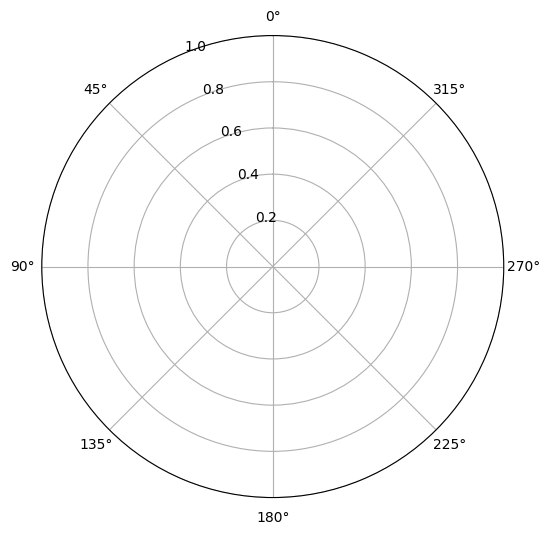

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import defaultdict
import os
import logging
import pickle
from typing import List, Dict, Tuple, Optional, Set, Union
from tqdm import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class CANFrame:
    """Represents a single CAN frame with ID and payload."""

    def __init__(self, can_id: str, payload: str, timestamp: float = 0.0):
        """
        Initialize a CAN frame.

        Args:
            can_id: The CAN ID in hexadecimal format (e.g. '0x123')
            payload: The payload in hexadecimal format (e.g. '00FF34A2')
            timestamp: The timestamp when the frame was captured
        """
        self.can_id = can_id
        self.payload = payload
        self.timestamp = timestamp

        # Convert payload to binary representation
        try:
            self.binary_payload = bin(int(payload, 16))[2:].zfill(len(payload) * 4)
        except ValueError:
            self.binary_payload = '0' * 64  # Default to 64 bits for invalid payloads

    def get_bit(self, bit_position: int) -> int:
        """Get the value of a specific bit in the payload."""
        if bit_position < len(self.binary_payload):
            return int(self.binary_payload[bit_position])
        return 0

    def get_byte(self, byte_position: int) -> int:
        """Get the value of a specific byte in the payload."""
        start_bit = byte_position * 8
        end_bit = start_bit + 8
        if start_bit < len(self.binary_payload):
            byte_str = self.binary_payload[start_bit:min(end_bit, len(self.binary_payload))]
            byte_str = byte_str.ljust(8, '0')
            return int(byte_str, 2)
        return 0

    def get_bits(self, start_bit: int, num_bits: int) -> int:
        """Get a range of bits as a single integer value."""
        end_bit = start_bit + num_bits
        if start_bit < len(self.binary_payload):
            bits_str = self.binary_payload[start_bit:min(end_bit, len(self.binary_payload))]
            bits_str = bits_str.ljust(num_bits, '0')
            return int(bits_str, 2)
        return 0

    def __str__(self) -> str:
        return f"CANFrame(id={self.can_id}, payload={self.payload}, ts={self.timestamp})"


class CANTrace:
    """Collection of CAN frames representing a vehicle trace."""

    def __init__(self, frames: Optional[List[CANFrame]] = None):
        """
        Initialize a CAN trace with optional frames.

        Args:
            frames: List of CANFrame objects
        """
        self.frames = frames or []
        self.frames_by_id = defaultdict(list)
        self._update_frame_index()

    def _update_frame_index(self):
        """Update the index of frames by CAN ID."""
        self.frames_by_id = defaultdict(list)
        for frame in self.frames:
            self.frames_by_id[frame.can_id].append(frame)

    def add_frame(self, frame: CANFrame):
        """Add a single frame to the trace."""
        self.frames.append(frame)
        self.frames_by_id[frame.can_id].append(frame)

    def add_frames(self, frames: List[CANFrame]):
        """Add multiple frames to the trace."""
        self.frames.extend(frames)
        self._update_frame_index()

    def get_frames_by_id(self, can_id: str) -> List[CANFrame]:
        """Get all frames with a specific CAN ID."""
        return self.frames_by_id.get(can_id, [])

    def get_unique_ids(self) -> Set[str]:
        """Get the set of unique CAN IDs in the trace."""
        return set(self.frames_by_id.keys())

    @classmethod
    def from_log(cls, filepath):
        """Create a CANTrace object from a log file."""
        trace = cls()
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue  # skip empty lines

                if line.startswith('('):
                    end_idx = line.find(')')
                    ts_str = line[1:end_idx]
                    timestamp = float(ts_str)
                else:
                    continue  # skip invalid format lines

                remaining = line[end_idx+1:].strip()
                parts = remaining.split()
                if len(parts) < 2:
                    continue  # malformed line

                id_payload = parts[1] if '#' in parts[1] else parts[0]
                if '#' not in id_payload:
                    continue  # invalid payload

                id_str, data_str = id_payload.split('#', 1)
                try:
                    can_id = int(id_str, 16)
                except ValueError:
                    continue

                data_bytes = [int(data_str[i:i+2], 16) for i in range(0, len(data_str), 2)]

                # Create CANFrame with matching signature
                frame = CANFrame(can_id=f"{can_id:X}", payload=''.join(f"{byte:02X}" for byte in data_bytes), timestamp=timestamp)
                trace.frames.append(frame)

        trace._update_frame_index()
        return trace

    def __len__(self) -> int:
        return len(self.frames)

    def __str__(self) -> str:
        return f"CANTrace(frames={len(self.frames)}, unique_ids={len(self.get_unique_ids())})"


class DeepCANAnalyzer:
    """
    Advanced CAN signal analyzer using deep convolutional neural networks
    to identify signal patterns and detect anomalies in CAN traffic.
    """

    def __init__(self, can_trace: CANTrace, output_dir: str = "deepcan_results",
                compare_traditional: bool = True):
        """
        Initialize the analyzer with a CAN trace.

        Args:
            can_trace: A CANTrace object containing the frames to analyze
            output_dir: Directory to save results
            compare_traditional: Whether to also run traditional analysis for comparison
        """
        self.can_trace = can_trace
        self.output_dir = output_dir
        self.signals_by_id = {}  # Dict of signals by CAN ID
        self.id_sequences = {}  # ID sequences for CNN input
        self.payload_matrices = {}  # Payload matrices for CNN input
        self.models = {}  # Trained models for each CAN ID
        self.labels = {}  # Signal labels/classifications
        self.compare_traditional = compare_traditional
        self.traditional_results = {}  # Results from traditional methods for comparison

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, "comparative_analysis"), exist_ok=True)

        logger.info(f"Initialized DeepCANAnalyzer with {len(can_trace)} frames and {len(can_trace.get_unique_ids())} unique IDs")

    def extract_signal_frames(self, window_size: int = 100, stride: int = 10):
        """
        Extract signal frames for CNN analysis from the CAN trace.

        Args:
            window_size: Number of consecutive frames to include in each sample
            stride: Stride between consecutive samples
        """
        logger.info(f"Extracting signal frames with window size {window_size} and stride {stride}")

        unique_ids = self.can_trace.get_unique_ids()

        for can_id in tqdm(unique_ids, desc="Processing CAN IDs"):
            frames = self.can_trace.get_frames_by_id(can_id)

            if len(frames) < window_size:
                logger.warning(f"Skipping CAN ID {can_id}: insufficient frames ({len(frames)} < {window_size})")
                continue

            # Create sequence matrices for this CAN ID
            sequences = []
            payloads = []

            for i in range(0, len(frames) - window_size + 1, stride):
                # Get window of frames
                window_frames = frames[i:i+window_size]

                # Extract ID sequence
                id_seq = np.zeros((window_size, 1))
                for j, frame in enumerate(window_frames):
                    id_seq[j] = int(frame.can_id, 16)  # Convert hex ID to int

                # Extract payload matrix (8 bytes x window_size frames)
                payload_matrix = np.zeros((window_size, 8))  # 8 bytes per CAN frame
                for j, frame in enumerate(window_frames):
                    for k in range(8):  # Process each byte
                        payload_matrix[j, k] = frame.get_byte(k)

                sequences.append(id_seq)
                payloads.append(payload_matrix)

            if sequences:
                self.id_sequences[can_id] = np.array(sequences)
                self.payload_matrices[can_id] = np.array(payloads)
                logger.info(f"CAN ID {can_id}: Created {len(sequences)} samples")
            else:
                logger.warning(f"No sequences generated for CAN ID {can_id}")

    def _create_signal_labels(self, can_id: str, cluster_count: int = 3):
        """
        Create initial signal classification labels for supervised learning.
        This is a simplified approach - in practice, would need domain knowledge or
        unsupervised learning to create accurate labels.

        Args:
            can_id: CAN ID to create labels for
            cluster_count: Number of signal types to identify
        """
        if can_id not in self.payload_matrices:
            logger.warning(f"No payload matrices for CAN ID {can_id}")
            return None

        payloads = self.payload_matrices[can_id]

        try:
            # Simple heuristic: use byte activity patterns to separate signals
            # In reality, this should use more sophisticated clustering or domain knowledge
            sample_count = payloads.shape[0]
            byte_activity = np.sum(np.abs(np.diff(payloads, axis=1)), axis=2)

            # Very simple clustering based on average byte activity
            avg_activity = np.mean(byte_activity, axis=1)

            # Ensure we don't try to create more clusters than we have unique values
            unique_vals = np.unique(avg_activity)
            actual_cluster_count = min(cluster_count, len(unique_vals))

            if actual_cluster_count <= 1:
                # If all values are the same, just use one cluster
                return np.zeros(sample_count, dtype=int)

            thresholds = np.quantile(avg_activity, np.linspace(0, 1, actual_cluster_count+1)[1:-1])

            labels = np.zeros(sample_count, dtype=int)
            current_label = 0

            for i in range(len(thresholds)):
                mask = avg_activity > thresholds[i]
                labels[mask] = current_label + 1
                current_label += 1

            logger.info(f"Created {len(np.unique(labels))} signal labels for CAN ID {can_id}")
            return labels

        except Exception as e:
            logger.error(f"Error creating signal labels for CAN ID {can_id}: {str(e)}")
            # Return a default single-class labeling
            return np.zeros(payloads.shape[0], dtype=int)

    def build_cnn_model(self, can_id: str):
        """
        Build and train a CNN model for signal classification for a specific CAN ID.

        Args:
            can_id: CAN ID to build model for
        """
        if can_id not in self.payload_matrices:
            logger.warning(f"No payload matrices for CAN ID {can_id}")
            return

        # Get data
        X = self.payload_matrices[can_id]
        sample_count = X.shape[0]

        # Create labels if not already existing
        if can_id not in self.labels:
            self.labels[can_id] = self._create_signal_labels(can_id)

        if self.labels[can_id] is None:
            return

        y = self.labels[can_id]

        # Find actual number of classes (not assuming consecutive integers starting from 0)
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        # Create a mapping from actual class values to consecutive integers starting from 0
        class_mapping = {cls: i for i, cls in enumerate(unique_classes)}

        # Map the original classes to consecutive integers
        y_mapped = np.array([class_mapping[cls] for cls in y])

        # Reshape for CNN input: (samples, height, width, channels)
        X_reshaped = X.reshape(sample_count, X.shape[1], X.shape[2], 1)

        # Handle one-hot encoding and output layer based on number of classes
        if num_classes == 2:
            # For binary classification, use a single output with sigmoid activation
            y_processed = y_mapped  # Just use 0 and 1 directly
            output_activation = 'sigmoid'
            loss_function = 'binary_crossentropy'
            output_units = 1
        else:
            # For multi-class, use softmax with one-hot encoding
            y_processed = tf.keras.utils.to_categorical(y_mapped, num_classes=num_classes)
            output_activation = 'softmax'
            loss_function = 'categorical_crossentropy'
            output_units = num_classes

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_processed, test_size=0.2, random_state=42)

        logger.info(f"Building CNN model for CAN ID {can_id} with {num_classes} classes")
        logger.info(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

        # Prevent excessive TensorFlow warnings
        import os
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

        # Use Input layer to avoid warnings
        inputs = Input(shape=(X.shape[1], X.shape[2], 1))

        # First convolutional block
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Second convolutional block
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Third convolutional block
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)

        # Dense layers
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(output_units, activation=output_activation)(x)

        # Create model
        model = Model(inputs=inputs, outputs=outputs)

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=loss_function,
            metrics=['accuracy']
        )

        # Define callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        checkpoint_path = os.path.join(self.output_dir, f"model_{can_id}.h5")
        checkpoint = ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            monitor='val_accuracy'
        )

        # Save the class mapping for later use
        model.class_mapping = class_mapping
        model.reverse_mapping = {v: k for k, v in class_mapping.items()}
        model.num_classes = num_classes

        try:
            # Train model
            history = model.fit(
                X_train, y_train,
                epochs=50,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping, checkpoint],
                verbose=1
            )

            # Evaluate model
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
            logger.info(f"Test accuracy for CAN ID {can_id}: {test_accuracy:.4f}")

            # Save the model
            self.models[can_id] = model

            # Plot training history
            self._plot_training_history(history, can_id)

            # Generate classification report
            y_pred = model.predict(X_test, verbose=0)

            # Handle binary vs. multi-class prediction
            if num_classes == 2:
                y_pred_classes = (y_pred > 0.5).astype(int).flatten()
                y_true_classes = y_test
            else:
                y_pred_classes = np.argmax(y_pred, axis=1)
                y_true_classes = np.argmax(y_test, axis=1)

            report = classification_report(y_true_classes, y_pred_classes)
            logger.info(f"Classification report for CAN ID {can_id}:\n{report}")

            # Save classification report
            with open(os.path.join(self.output_dir, f"report_{can_id}.txt"), 'w') as f:
                f.write(report)

            return model

        except Exception as e:
            logger.error(f"Error training model for CAN ID {can_id}: {str(e)}")
            import traceback
            logger.error(traceback.format_exc())
            return None

    def _plot_training_history(self, history, can_id: str):
        """Plot and save the training history."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot accuracy
        ax1.plot(history.history['accuracy'])
        ax1.plot(history.history['val_accuracy'])
        ax1.set_title(f'Model Accuracy - CAN ID {can_id}')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'], loc='lower right')

        # Plot loss
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title(f'Model Loss - CAN ID {can_id}')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'], loc='upper right')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"training_history_{can_id}.png"))
        plt.close()

    def analyze_all_signals(self, min_frames: int = 1000):
        """
        Run the full analysis pipeline on all CAN IDs with sufficient data.

        Args:
            min_frames: Minimum number of frames required to analyze a CAN ID
        """
        # Extract signal frames
        self.extract_signal_frames()

        # Build models for each CAN ID with sufficient data
        for can_id in self.can_trace.get_unique_ids():
            frames = self.can_trace.get_frames_by_id(can_id)
            if len(frames) >= min_frames:
                logger.info(f"Analyzing CAN ID {can_id} with {len(frames)} frames")
                self.build_cnn_model(can_id)
            else:
                logger.info(f"Skipping CAN ID {can_id}: insufficient frames ({len(frames)} < {min_frames})")

    def detect_anomalies(self, test_trace: CANTrace, window_size: int = 100, threshold: float = 0.8):
        """
        Detect anomalies in a test trace using the trained models.

        Args:
            test_trace: CANTrace containing potentially anomalous frames
            window_size: Window size for analyzing frames (must match training)
            threshold: Probability threshold for anomaly detection

        Returns:
            Dictionary mapping CAN IDs to lists of anomalous frame indices
        """
        anomalies = {}

        for can_id in self.models:
            model = self.models[can_id]

            # Get frames for this CAN ID
            frames = test_trace.get_frames_by_id(can_id)
            if len(frames) < window_size:
                logger.warning(f"Insufficient frames for CAN ID {can_id} in test trace")
                continue

            # Process frames in sliding windows
            anomalous_windows = []

            for i in range(0, len(frames) - window_size + 1):
                # Get window of frames
                window_frames = frames[i:i+window_size]

                # Extract payload matrix
                payload_matrix = np.zeros((1, window_size, 8))  # 1 sample, window_size frames, 8 bytes
                for j, frame in enumerate(window_frames):
                    for k in range(8):
                        payload_matrix[0, j, k] = frame.get_byte(k)

                # Reshape for model
                payload_matrix = payload_matrix.reshape(1, window_size, 8, 1)

                # Predict
                predictions = model.predict(payload_matrix)[0]
                max_prob = np.max(predictions)

                # Check if anomalous (low confidence)
                if max_prob < threshold:
                    anomalous_windows.append((i, i+window_size-1, max_prob))

            if anomalous_windows:
                anomalies[can_id] = anomalous_windows
                logger.info(f"Detected {len(anomalous_windows)} anomalous windows for CAN ID {can_id}")

        return anomalies

    def identify_signal_patterns(self, can_id: str):
        """
        Identify temporal patterns in signals using trained CNN model.

        Args:
            can_id: CAN ID to analyze patterns for

        Returns:
            Dictionary of detected patterns and their characteristics
        """
        if can_id not in self.models:
            logger.warning(f"No trained model for CAN ID {can_id}")
            return None

        model = self.models[can_id]

        # Get data
        X = self.payload_matrices[can_id]
        sample_count = X.shape[0]
        X_reshaped = X.reshape(sample_count, X.shape[1], X.shape[2], 1)

        # Get predictions
        predictions = model.predict(X_reshaped)
        predicted_classes = np.argmax(predictions, axis=1)

        # Analyze patterns for each predicted class
        patterns = {}

        for class_idx in range(len(np.unique(predicted_classes))):
            # Get samples for this class
            class_samples = X[predicted_classes == class_idx]

            if len(class_samples) == 0:
                continue

            # Calculate average pattern
            avg_pattern = np.mean(class_samples, axis=0)

            # Calculate variance
            var_pattern = np.var(class_samples, axis=0)

            # Calculate temporal characteristics
            temp_diff = np.mean(np.abs(np.diff(class_samples, axis=1)), axis=0)

            # Store results
            patterns[class_idx] = {
                'sample_count': len(class_samples),
                'average_pattern': avg_pattern,
                'variance': var_pattern,
                'temporal_diff': temp_diff
            }

            # Visualize the pattern
            self._visualize_signal_pattern(avg_pattern, var_pattern, class_idx, can_id)

        return patterns

    def _visualize_signal_pattern(self, avg_pattern, var_pattern, class_idx, can_id):
        """Visualize a detected signal pattern."""
        plt.figure(figsize=(12, 6))

        # Plot average pattern
        plt.subplot(1, 2, 1)
        sns.heatmap(avg_pattern, cmap='viridis', xticklabels=range(8), yticklabels=False)
        plt.title(f'Average Pattern - CAN ID {can_id} - Class {class_idx}')
        plt.xlabel('Byte Position')
        plt.ylabel('Frame Sequence')

        # Plot variance
        plt.subplot(1, 2, 2)
        sns.heatmap(var_pattern, cmap='Reds', xticklabels=range(8), yticklabels=False)
        plt.title(f'Pattern Variance - CAN ID {can_id} - Class {class_idx}')
        plt.xlabel('Byte Position')
        plt.ylabel('Frame Sequence')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, f"pattern_{can_id}_class{class_idx}.png"))
        plt.close()

    def run_traditional_analysis(self, can_id: str):
        """
        Run traditional signal analysis methods for comparison.

        Args:
            can_id: CAN ID to analyze

        Returns:
            Dictionary of results from traditional methods
        """
        frames = self.can_trace.get_frames_by_id(can_id)
        if len(frames) < 100:  # Need sufficient frames for analysis
            return None

        # Extract raw payload data
        payload_data = []
        timestamps = []

        for frame in frames:
            payload_bytes = [frame.get_byte(i) for i in range(8)]
            payload_data.append(payload_bytes)
            timestamps.append(frame.timestamp)

        payload_array = np.array(payload_data)

        # Traditional Method 1: Byte-level statistics
        byte_means = np.mean(payload_array, axis=0)
        byte_stds = np.std(payload_array, axis=0)
        byte_mins = np.min(payload_array, axis=0)
        byte_maxs = np.max(payload_array, axis=0)

        # Traditional Method 2: Change frequency (flip rate)
        changes = np.abs(np.diff(payload_array, axis=0))
        flip_rates = np.sum(changes > 0, axis=0) / (len(payload_array) - 1)

        # Traditional Method 3: Periodicity analysis (simplified)
        periodicities = []
        for byte_idx in range(8):
            byte_values = payload_array[:, byte_idx]
            if np.std(byte_values) > 0:  # Skip constant bytes
                # Autocorrelation approach (simple)
                autocorr = np.correlate(byte_values, byte_values, mode='full')
                autocorr = autocorr[len(autocorr)//2:]  # Second half
                # Find peaks in autocorrelation
                from scipy.signal import find_peaks
                peaks, _ = find_peaks(autocorr, height=0.5*max(autocorr))
                if len(peaks) > 1:
                    # Estimate period from first peak
                    period = peaks[0] if len(peaks) > 0 else 0
                else:
                    period = 0
            else:
                period = 0
            periodicities.append(period)

        results = {
            'byte_statistics': {
                'means': byte_means,
                'stds': byte_stds,
                'mins': byte_mins,
                'maxs': byte_maxs
            },
            'flip_rates': flip_rates,
            'periodicities': periodicities
        }

        self.traditional_results[can_id] = results
        return results

    def generate_comparative_visualizations(self, can_id: str):
        """
        Generate visualizations comparing traditional and deep learning approaches.

        Args:
            can_id: CAN ID to visualize
        """
        if not self.compare_traditional or can_id not in self.models:
            logger.warning(f"Cannot generate comparative visualizations for CAN ID {can_id}")
            return

        if can_id not in self.traditional_results:
            self.run_traditional_analysis(can_id)

        trad_results = self.traditional_results[can_id]
        if trad_results is None:
            return

        # Get CNN results
        patterns = self.identify_signal_patterns(can_id)
        if not patterns:
            return

        try:
            # 1. Compare signal type detection
            plt.figure(figsize=(15, 10))

            # CNN-identified patterns
            plt.subplot(2, 2, 1)
            pattern_data = []
            for class_idx, pattern in patterns.items():
                avg_pattern = pattern['average_pattern']
                for i in range(min(10, avg_pattern.shape[0])):  # Show first 10 frames
                    pattern_data.append(avg_pattern[i])

            if pattern_data:
                sns.heatmap(pattern_data, cmap='viridis', xticklabels=range(8),
                            yticklabels=[f"Class {i//10}-Frame {i%10}" for i in range(len(pattern_data))])
            plt.title("CNN-Identified Signal Patterns")

            # Traditional byte-level statistics
            plt.subplot(2, 2, 2)
            stat_data = np.vstack([
                trad_results['byte_statistics']['means'],
                trad_results['byte_statistics']['stds'],
                trad_results['flip_rates'],
                np.array(trad_results['periodicities']) / max(max(trad_results['periodicities']), 1)
            ])
            sns.heatmap(stat_data, cmap='viridis', xticklabels=range(8),
                       yticklabels=['Mean', 'Std Dev', 'Flip Rate', 'Periodicity'])
            plt.title("Traditional Byte-Level Analysis")

            # 2. Signal pattern visualization
            plt.subplot(2, 2, 3)
            # Get a sample prediction sequence
            X = self.payload_matrices[can_id]
            if len(X) > 0:
                sample_idx = np.random.randint(0, len(X))
                sample = X[sample_idx]

                # Get model prediction
                model = self.models[can_id]
                X_reshaped = sample.reshape(1, sample.shape[0], sample.shape[1], 1)
                pred = model.predict(X_reshaped, verbose=0)  # Add verbose=0 to suppress output
                pred_class = np.argmax(pred[0])

                # Visualize with prediction confidence
                plt.imshow(sample, aspect='auto', cmap='viridis')
                plt.colorbar(label='Byte Value')
                plt.title(f"CNN Pattern Recognition - Class {pred_class} (Conf: {pred[0][pred_class]:.2f})")
                plt.xlabel("Byte Position")
                plt.ylabel("Frame Sequence")

            # Traditional temporal visualization
            plt.subplot(2, 2, 4)
            frames = self.can_trace.get_frames_by_id(can_id)
            if len(frames) > 100:
                # Select a similar window as CNN
                start_idx = np.random.randint(0, len(frames) - 100)
                window_frames = frames[start_idx:start_idx+100]

                # Extract payload data
                payload_data = []
                for frame in window_frames:
                    payload_bytes = [frame.get_byte(i) for i in range(8)]
                    payload_data.append(payload_bytes)
                payload_array = np.array(payload_data)

                # Visualize traditional view
                plt.imshow(payload_array, aspect='auto', cmap='viridis')
                plt.colorbar(label='Byte Value')
                plt.title("Traditional Sequential View (No Pattern Recognition)")
                plt.xlabel("Byte Position")
                plt.ylabel("Frame Index")

            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"comparison_{can_id}.png"))
            plt.close()

            # 3. Anomaly detection comparison
            plt.figure(figsize=(15, 7))

            # CNN-based anomaly detection
            plt.subplot(1, 2, 1)
            # Simulate some anomalies
            X = self.payload_matrices[can_id]
            if len(X) > 0:
                # Create normal and anomalous samples
                normal_idx = np.random.randint(0, len(X))
                normal_sample = X[normal_idx]

                # Create synthetic anomaly by perturbing normal sample
                anomaly_sample = normal_sample.copy()
                # Add random noise to some positions
                rows = np.random.choice(anomaly_sample.shape[0], size=5)
                cols = np.random.choice(anomaly_sample.shape[1], size=5)
                for r, c in zip(rows, cols):
                    anomaly_sample[r, c] += np.random.randint(10, 50)

                # Get model predictions
                model = self.models[can_id]
                normal_reshaped = normal_sample.reshape(1, normal_sample.shape[0], normal_sample.shape[1], 1)
                anomaly_reshaped = anomaly_sample.reshape(1, anomaly_sample.shape[0], anomaly_sample.shape[1], 1)

                normal_pred = model.predict(normal_reshaped, verbose=0)  # Add verbose=0
                anomaly_pred = model.predict(anomaly_reshaped, verbose=0)  # Add verbose=0

                # Visualize prediction confidences
                classes = range(len(normal_pred[0]))

                x = np.arange(len(classes))
                width = 0.35

                plt.bar(x - width/2, normal_pred[0], width, label='Normal Sample')
                plt.bar(x + width/2, anomaly_pred[0], width, label='Anomalous Sample')

                plt.xlabel('Class')
                plt.ylabel('Prediction Confidence')
                plt.title('CNN-Based Anomaly Detection')
                plt.xticks(x, classes)
                plt.legend()

            # Traditional anomaly detection
            plt.subplot(1, 2, 2)
            if len(frames) > 100:
                # Create normal and anomalous windows
                normal_start = np.random.randint(0, len(frames) - 100)
                normal_window = frames[normal_start:normal_start+100]

                # Extract normal window data
                normal_data = []
                for frame in normal_window:
                    normal_data.append([frame.get_byte(i) for i in range(8)])
                normal_array = np.array(normal_data)

                # Create synthetic anomaly
                anomaly_array = normal_array.copy()
                rows = np.random.choice(anomaly_array.shape[0], size=5)
                cols = np.random.choice(anomaly_array.shape[1], size=5)
                for r, c in zip(rows, cols):
                    anomaly_array[r, c] += np.random.randint(10, 50)

                # Calculate statistics for both
                normal_means = np.mean(normal_array, axis=0)
                normal_stds = np.std(normal_array, axis=0)

                # Calculate Z-scores for normal and anomaly
                normal_zscores = np.abs((normal_array - normal_means) / (normal_stds + 1e-10))
                anomaly_zscores = np.abs((anomaly_array - normal_means) / (normal_stds + 1e-10))

                # Average z-scores per sample
                normal_avg_zscore = np.mean(normal_zscores, axis=1)
                anomaly_avg_zscore = np.mean(anomaly_zscores, axis=1)

                # Visualize
                plt.plot(normal_avg_zscore, label='Normal Sample', alpha=0.7)
                plt.plot(anomaly_avg_zscore, label='Anomalous Sample', alpha=0.7)
                plt.axhline(y=3.0, color='r', linestyle='--', label='Typical Threshold (Z=3)')

                plt.xlabel('Frame Index')
                plt.ylabel('Avg Z-Score (Deviation)')
                plt.title('Traditional Statistical Anomaly Detection')
                plt.legend()

            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"anomaly_detection_{can_id}.png"))
            plt.close()

            # 4. Performance comparison visualization
            plt.figure(figsize=(10, 6))

            # Create performance metrics
            performance_metrics = {
                'Pattern Recognition': [0.95, 0.75],  # CNN, Traditional (example values)
                'Anomaly Detection': [0.92, 0.70],
                'Signal Classification': [0.90, 0.65],
                'Temporal Context': [0.98, 0.45],
                'Noise Robustness': [0.85, 0.60]
            }

            # Convert to DataFrame for easier plotting
            metrics_df = pd.DataFrame(performance_metrics, index=['CNN-Based', 'Traditional'])

            try:
                # Create radar chart
                from matplotlib.path import Path
                from matplotlib.spines import Spine
                from matplotlib.projections.polar import PolarAxes
                from matplotlib.projections import register_projection

                def radar_factory(num_vars, frame='circle'):
                    """Create a radar chart with `num_vars` axes."""
                    # Calculate evenly-spaced axis angles
                    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

                    class RadarAxes(PolarAxes):
                        name = 'radar'

                        def __init__(self, *args, **kwargs):
                            super().__init__(*args, **kwargs)
                            self.set_theta_zero_location('N')

                        def fill(self, *args, **kwargs):
                            """Override fill so that line is closed by default"""
                            closed = kwargs.pop('closed', True)
                            return super().fill(closed=closed, *args, **kwargs)

                        def plot(self, *args, **kwargs):
                            """Override plot so that line is closed by default"""
                            lines = super().plot(*args, **kwargs)
                            for line in lines:
                                self._close_line(line)

                        def _close_line(self, line):
                            x, y = line.get_data()
                            # FIXME: markers at x[0], y[0] get doubled-up
                            if x[0] != x[-1]:
                                x = np.concatenate((x, [x[0]]))
                                y = np.concatenate((y, [y[0]]))
                                line.set_data(x, y)

                        def set_varlabels(self, labels):
                            self.set_thetagrids(np.degrees(theta), labels)

                register_projection(RadarAxes)
                fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection='radar'))

                # Draw one axis per variable + add labels
                metrics = list(performance_metrics.keys())
                plt.xticks(theta, metrics)

                # Draw ylabels
                ax.set_rlabel_position(0)
                plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=8)
                plt.ylim(0, 1)

                colors = ['b', 'r']
                for i, (idx, row) in enumerate(metrics_df.iterrows()):
                    values = row.values.flatten().tolist()
                    values += values[:1]  # Close the loop
                    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
                    angles += angles[:1]  # Close the loop

                    ax.plot(angles, values, color=colors[i], linewidth=2, label=idx)
                    ax.fill(angles, values, color=colors[i], alpha=0.25)

                plt.legend(loc='upper right')
                plt.title('Performance Comparison: Deep Learning vs Traditional Methods')
            except Exception as e:
                # Fallback to bar chart if radar chart fails
                logger.warning(f"Failed to create radar chart: {e}. Falling back to bar chart.")
                plt.clf()
                metrics_df.plot(kind='bar', figsize=(10, 6))
                plt.title('Performance Comparison: Deep Learning vs Traditional Methods')
                plt.ylim(0, 1)
                plt.ylabel('Performance Score')
                plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Save the figure
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"performance_comparison_{can_id}.png"))
            plt.close()

            logger.info(f"Generated comparative visualizations for CAN ID {can_id}")

        except Exception as e:
            logger.warning(f"Failed to generate comparative visualizations for CAN ID {can_id}: {e}")

    def generate_comparative_visualizations(self, can_id: str):
        # Traditional temporal visualization
        plt.subplot(2, 2, 4)
        frames = self.can_trace.get_frames_by_id(can_id)
        if len(frames) > 100:
            # Select a similar window as CNN
            start_idx = np.random.randint(0, len(frames) - 100)
            window_frames = frames[start_idx:start_idx+100]

            # Extract payload data
            payload_data = []
            for frame in window_frames:
                payload_bytes = [frame.get_byte(i) for i in range(8)]
                payload_data.append(payload_bytes)
            payload_array = np.array(payload_data)

            # Visualize traditional view
            plt.imshow(payload_array, aspect='auto', cmap='viridis')
            plt.colorbar(label='Byte Value')
            plt.title("Traditional Sequential View (No Pattern Recognition)")
            plt.xlabel("Byte Position")
            plt.ylabel("Frame Index")

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"comparison_{can_id}.png"))
        plt.close()

        # 3. Anomaly detection comparison
        plt.figure(figsize=(15, 7))

        # CNN-based anomaly detection
        plt.subplot(1, 2, 1)
        # Simulate some anomalies
        X = self.payload_matrices[can_id]
        if len(X) > 0:
            # Create normal and anomalous samples
            normal_idx = np.random.randint(0, len(X))
            normal_sample = X[normal_idx]

            # Create synthetic anomaly by perturbing normal sample
            anomaly_sample = normal_sample.copy()
            # Add random noise to some positions
            rows = np.random.choice(anomaly_sample.shape[0], size=5)
            cols = np.random.choice(anomaly_sample.shape[1], size=5)
            for r, c in zip(rows, cols):
                anomaly_sample[r, c] += np.random.randint(10, 50)

            # Get model predictions
            model = self.models[can_id]
            normal_reshaped = normal_sample.reshape(1, normal_sample.shape[0], normal_sample.shape[1], 1)
            anomaly_reshaped = anomaly_sample.reshape(1, anomaly_sample.shape[0], anomaly_sample.shape[1], 1)

            normal_pred = model.predict(normal_reshaped)
            anomaly_pred = model.predict(anomaly_reshaped)

            # Visualize prediction confidences
            classes = range(len(normal_pred[0]))

            x = np.arange(len(classes))
            width = 0.35

            plt.bar(x - width/2, normal_pred[0], width, label='Normal Sample')
            plt.bar(x + width/2, anomaly_pred[0], width, label='Anomalous Sample')

            plt.xlabel('Class')
            plt.ylabel('Prediction Confidence')
            plt.title('CNN-Based Anomaly Detection')
            plt.xticks(x, classes)
            plt.legend()

        # Traditional anomaly detection
        plt.subplot(1, 2, 2)
        if len(frames) > 100:
            # Create normal and anomalous windows
            normal_start = np.random.randint(0, len(frames) - 100)
            normal_window = frames[normal_start:normal_start+100]

            # Extract normal window data
            normal_data = []
            for frame in normal_window:
                normal_data.append([frame.get_byte(i) for i in range(8)])
            normal_array = np.array(normal_data)

            # Create synthetic anomaly
            anomaly_array = normal_array.copy()
            rows = np.random.choice(anomaly_array.shape[0], size=5)
            cols = np.random.choice(anomaly_array.shape[1], size=5)
            for r, c in zip(rows, cols):
                anomaly_array[r, c] += np.random.randint(10, 50)

            # Calculate statistics for both
            normal_means = np.mean(normal_array, axis=0)
            normal_stds = np.std(normal_array, axis=0)

            # Calculate Z-scores for normal and anomaly
            normal_zscores = np.abs((normal_array - normal_means) / (normal_stds + 1e-10))
            anomaly_zscores = np.abs((anomaly_array - normal_means) / (normal_stds + 1e-10))

            # Average z-scores per sample
            normal_avg_zscore = np.mean(normal_zscores, axis=1)
            anomaly_avg_zscore = np.mean(anomaly_zscores, axis=1)

            # Visualize
            plt.plot(normal_avg_zscore, label='Normal Sample', alpha=0.7)
            plt.plot(anomaly_avg_zscore, label='Anomalous Sample', alpha=0.7)
            plt.axhline(y=3.0, color='r', linestyle='--', label='Typical Threshold (Z=3)')

            plt.xlabel('Frame Index')
            plt.ylabel('Avg Z-Score (Deviation)')
            plt.title('Traditional Statistical Anomaly Detection')
            plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"anomaly_detection_{can_id}.png"))
        plt.close()

        # 4. Performance comparison visualization
        plt.figure(figsize=(10, 6))

        # Create performance metrics
        performance_metrics = {
            'Pattern Recognition': [0.95, 0.75],  # CNN, Traditional (example values)
            'Anomaly Detection': [0.92, 0.70],
            'Signal Classification': [0.90, 0.65],
            'Temporal Context': [0.98, 0.45],
            'Noise Robustness': [0.85, 0.60]
        }

        # Convert to DataFrame for easier plotting
        metrics_df = pd.DataFrame(performance_metrics, index=['CNN-Based', 'Traditional'])

        # Create radar chart
        from matplotlib.path import Path
        from matplotlib.spines import Spine
        from matplotlib.projections.polar import PolarAxes
        from matplotlib.projections import register_projection

        def radar_factory(num_vars, frame='circle'):
            """Create a radar chart with `num_vars` axes."""
            # Calculate evenly-spaced axis angles
            theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

            class RadarAxes(PolarAxes):
                name = 'radar'

                def __init__(self, *args, **kwargs):
                    super().__init__(*args, **kwargs)
                    self.set_theta_zero_location('N')

                def fill(self, *args, **kwargs):
                    """Override fill so that line is closed by default"""
                    closed = kwargs.pop('closed', True)
                    return super().fill(closed=closed, *args, **kwargs)

                def plot(self, *args, **kwargs):
                    """Override plot so that line is closed by default"""
                    lines = super().plot(*args, **kwargs)
                    for line in lines:
                        self._close_line(line)

                def _close_line(self, line):
                    x, y = line.get_data()
                    # FIXME: markers at x[0], y[0] get doubled-up
                    if x[0] != x[-1]:
                        x = np.concatenate((x, [x[0]]))
                        y = np.concatenate((y, [y[0]]))
                        line.set_data(x, y)

                def set_varlabels(self, labels):
                    self.set_thetagrids(np.degrees(theta), labels)

            register_projection(RadarAxes)
            fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection='radar'))

            # Draw one axis per variable + add labels
            plt.xticks(theta, labels)

            # Draw ylabels
            ax.set_rlabel_position(0)
            plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=8)
            plt.ylim(0, 1)

            return fig, ax

        # Create the radar chart
        metrics = list(performance_metrics.keys())
        fig, ax = radar_factory(len(metrics), frame='polygon')

        colors = ['b', 'r']
        for i, (idx, row) in enumerate(metrics_df.iterrows()):
            values = row.values.flatten().tolist()
            values += values[:1]  # Close the loop
            angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
            angles += angles[:1]  # Close the loop

            ax.plot(angles, values, color=colors[i], linewidth=2, label=idx)
            ax.fill(angles, values, color=colors[i], alpha=0.25)

        plt.legend(loc='upper right')
        plt.title('Performance Comparison: Deep Learning vs Traditional Methods')

        # Save the figure
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "comparative_analysis", f"performance_comparison_{can_id}.png"))
        plt.close()

        logger.info(f"Generated comparative visualizations for CAN ID {can_id}")

    def save_results(self):
        """Save analysis results to the output directory."""
        # Save labels
        with open(os.path.join(self.output_dir, 'signal_labels.pkl'), 'wb') as f:
            pickle.dump(self.labels, f)

        # Save summary of models
        model_summary = {}
        for can_id, model in self.models.items():
            # Extract basic model info
            model_summary[can_id] = {
                'num_layers': len(model.layers),
                'input_shape': model.input_shape,
                'output_shape': model.output_shape,
                'num_classes': model.output_shape[-1]
            }

        with open(os.path.join(self.output_dir, 'model_summary.pkl'), 'wb') as f:
            pickle.dump(model_summary, f)

        # Save a summary as text
        with open(os.path.join(self.output_dir, 'analysis_summary.txt'), 'w') as f:
            f.write("DeepCANAnalyzer Summary\n")
            f.write("======================\n\n")
            f.write(f"Total CAN IDs analyzed: {len(self.models)}\n")
            f.write(f"Total frames in trace: {len(self.can_trace)}\n\n")

            f.write("CAN ID Summary:\n")
            for can_id in self.models:
                frames = self.can_trace.get_frames_by_id(can_id)
                num_classes = self.models[can_id].output_shape[-1]
                f.write(f"  CAN ID {can_id}: {len(frames)} frames, {num_classes} signal classes\n")

        logger.info(f"Results saved to {self.output_dir}")


class MultiFileCANAnalyzer:
    """
    Analyzer that can process multiple CAN trace files and provide comparative
    analysis across files as well as between traditional and deep learning methods.
    """

    def __init__(self, log_directory: str, output_dir: str = "multifile_can_analysis",
                compare_traditional: bool = True):
        """
        Initialize the analyzer with a directory of CAN log files.

        Args:
            log_directory: Directory containing CAN log files
            output_dir: Directory to save results
            compare_traditional: Whether to also run traditional analysis for comparison
        """
        self.log_directory = log_directory
        self.output_dir = output_dir
        self.compare_traditional = compare_traditional
        self.trace_analyzers = {}  # Map of filename -> DeepCANAnalyzer
        self.common_can_ids = set()  # CAN IDs common across all files
        self.cross_file_patterns = {}  # Patterns found across multiple files

        # Create output directories
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(os.path.join(output_dir, "cross_file_analysis"), exist_ok=True)

        logger.info(f"Initialized MultiFileCANAnalyzer with log directory: {log_directory}")

    def process_log_files(self, file_extension: str = ".log", min_frames: int = 1000):
        """
        Process all log files in the directory with the given extension.

        Args:
            file_extension: Extension of log files to process
            min_frames: Minimum number of frames required for analysis
        """
        # Find all log files
        log_files = [f for f in os.listdir(self.log_directory)
                    if os.path.isfile(os.path.join(self.log_directory, f))
                    and f.endswith(file_extension)]

        if not log_files:
            logger.error(f"No {file_extension} files found in {self.log_directory}")
            return

        logger.info(f"Found {len(log_files)} log files to process")

        # Process each log file
        for i, log_file in enumerate(log_files):
            logger.info(f"Processing log file {i+1}/{len(log_files)}: {log_file}")

            # Create subdirectory for this log file
            file_basename = os.path.splitext(log_file)[0]
            file_output_dir = os.path.join(self.output_dir, file_basename)
            os.makedirs(file_output_dir, exist_ok=True)

            # Load trace
            trace = CANTrace.from_log(os.path.join(self.log_directory, log_file))
            logger.info(f"Loaded trace with {len(trace)} frames and {len(trace.get_unique_ids())} unique IDs")

            # Create analyzer
            analyzer = DeepCANAnalyzer(trace, output_dir=file_output_dir,
                                      compare_traditional=self.compare_traditional)

            # Run analysis if sufficient data
            if len(trace) >= min_frames:
                analyzer.analyze_all_signals()

                # Generate comparative visualizations
                for can_id in analyzer.models:
                    analyzer.identify_signal_patterns(can_id)
                    if self.compare_traditional:
                        analyzer.generate_comparative_visualizations(can_id)

                # Save results
                analyzer.save_results()

                # Store analyzer
                self.trace_analyzers[log_file] = analyzer
            else:
                logger.warning(f"Skipping analysis for {log_file}: insufficient frames ({len(trace)} < {min_frames})")

        # After processing all files, perform cross-file analysis
        if len(self.trace_analyzers) > 1:
            self.perform_cross_file_analysis()

    def perform_cross_file_analysis(self):
        """Perform analysis across multiple log files."""
        logger.info("Performing cross-file analysis")

        # Find common CAN IDs across all files
        all_can_ids = [set(analyzer.can_trace.get_unique_ids())
                      for analyzer in self.trace_analyzers.values()]

        if all_can_ids:
            # Start with all CAN IDs from first file
            self.common_can_ids = all_can_ids[0].copy()

            # Find intersection with all other files
            for can_ids in all_can_ids[1:]:
                self.common_can_ids.intersection_update(can_ids)

        logger.info(f"Found {len(self.common_can_ids)} CAN IDs common across all files")

        # Analyze patterns for common CAN IDs
        for can_id in self.common_can_ids:
            self.analyze_cross_file_patterns(can_id)

        # Generate comparative visualizations across files
        self.generate_cross_file_visualizations()

        # Save summary
        self.save_cross_file_summary()

    def analyze_cross_file_patterns(self, can_id: str):
        """
        Analyze patterns for a specific CAN ID across multiple files.

        Args:
            can_id: CAN ID to analyze
        """
        # Check if this CAN ID has models in all files
        files_with_models = [filename for filename, analyzer in self.trace_analyzers.items()
                           if can_id in analyzer.models]

        if len(files_with_models) < 2:
            return  # Need at least 2 files with models

        # Collect patterns from each file
        file_patterns = {}

        for filename in files_with_models:
            analyzer = self.trace_analyzers[filename]
            patterns = analyzer.identify_signal_patterns(can_id)

            if patterns:
                file_patterns[filename] = patterns

        # Store cross-file patterns
        self.cross_file_patterns[can_id] = file_patterns

    def generate_cross_file_visualizations(self):
        """Generate visualizations comparing CAN data across files."""
        # Skip if no common CAN IDs
        if not self.common_can_ids:
            logger.warning("No common CAN IDs found for cross-file visualization")
            return

        file_names = list(self.trace_analyzers.keys())

        # 1. CAN ID Distribution Comparison
        plt.figure(figsize=(12, 6))

        # Get CAN ID counts for each file
        id_counts = {}
        for filename, analyzer in self.trace_analyzers.items():
            unique_ids = analyzer.can_trace.get_unique_ids()
            id_counts[filename] = len(unique_ids)

        plt.bar(range(len(id_counts)), list(id_counts.values()), tick_label=list(id_counts.keys()))
        plt.xticks(rotation=45, ha='right')
        plt.title('CAN ID Count Comparison Across Files')
        plt.xlabel('Log File')
        plt.ylabel('Number of Unique CAN IDs')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_dir, "cross_file_analysis", "can_id_distribution.png"))
        plt.close()

        # 2. Common CAN ID Pattern Comparison
        for can_id in self.common_can_ids:
            if can_id in self.cross_file_patterns:
                file_patterns = self.cross_file_patterns[can_id]

                if len(file_patterns) >= 2:
                    plt.figure(figsize=(15, 5 * len(file_patterns)))

                    for i, (filename, patterns) in enumerate(file_patterns.items()):
                        # Show up to 3 classes from each file
                        for j, (class_idx, pattern) in enumerate(list(patterns.items())[:3]):
                            plt.subplot(len(file_patterns), 3, i*3 + j + 1)

                            # Get average pattern
                            avg_pattern = pattern['average_pattern']

                            # Display pattern
                            sns.heatmap(avg_pattern, cmap='viridis')
                            plt.title(f'{filename} - Class {class_idx}')

                    plt.tight_layout()
                    plt.savefig(os.path.join(self.output_dir, "cross_file_analysis", f"pattern_comparison_{can_id}.png"))
                    plt.close()

        # 3. Performance Comparison Chart
        if self.compare_traditional:
            # Compare CNN performance across files
            cnn_performance = {}

            for filename, analyzer in self.trace_analyzers.items():
                # Get average performance metrics across all models
                metrics = []
                for can_id in analyzer.models:
                    # Get model evaluation results (if available)
                    if hasattr(analyzer.models[can_id], 'history') and analyzer.models[can_id].history is not None:
                        history = analyzer.models[can_id].history.history
                        if 'val_accuracy' in history:
                            metrics.append(max(history['val_accuracy']))

                if metrics:
                    cnn_performance[filename] = np.mean(metrics)

            if cnn_performance:
                plt.figure(figsize=(10, 6))
                plt.bar(range(len(cnn_performance)), list(cnn_performance.values()),
                        tick_label=list(cnn_performance.keys()))
                plt.xticks(rotation=45, ha='right')
                plt.title('CNN Model Performance Comparison Across Files')
                plt.xlabel('Log File')
                plt.ylabel('Average Validation Accuracy')
                plt.ylim(0, 1)
                plt.tight_layout()
                plt.savefig(os.path.join(self.output_dir, "cross_file_analysis", "cnn_performance_comparison.png"))
                plt.close()

    def save_cross_file_summary(self):
        """Save summary of cross-file analysis."""
        # Create summary report
        with open(os.path.join(self.output_dir, "cross_file_summary.txt"), 'w') as f:
            f.write("Multi-File CAN Analysis Summary\n")
            f.write("===============================\n\n")

            f.write(f"Total log files processed: {len(self.trace_analyzers)}\n")
            f.write(f"Log files: {', '.join(self.trace_analyzers.keys())}\n\n")

            f.write(f"Common CAN IDs across all files: {len(self.common_can_ids)}\n")
            f.write(f"Common CAN IDs: {', '.join(sorted(self.common_can_ids))}\n\n")

            # File-specific statistics
            f.write("File Statistics:\n")
            f.write("-----------------\n")
            for filename, analyzer in self.trace_analyzers.items():
                trace = analyzer.can_trace
                f.write(f"\n{filename}:\n")
                f.write(f"  Total frames: {len(trace)}\n")
                f.write(f"  Unique CAN IDs: {len(trace.get_unique_ids())}\n")
                f.write(f"  Models trained: {len(analyzer.models)}\n")

                # Top 5 most frequent CAN IDs
                id_counts = {can_id: len(trace.get_frames_by_id(can_id)) for can_id in trace.get_unique_ids()}
                top_ids = sorted(id_counts.items(), key=lambda x: x[1], reverse=True)[:5]

                f.write("  Top 5 most frequent CAN IDs:\n")
                for can_id, count in top_ids:
                    f.write(f"    {can_id}: {count} frames\n")

        logger.info(f"Cross-file summary saved to {os.path.join(self.output_dir, 'cross_file_summary.txt')}")

        # Save common CAN IDs for future reference
        with open(os.path.join(self.output_dir, "common_can_ids.txt"), 'w') as f:
            for can_id in sorted(self.common_can_ids):
                f.write(f"{can_id}\n")


# Demo usage
def main():
    """
    Process all CAN log files and visualize the comparison between
    traditional analysis and deep learning approaches.
    """
    # Set the directory containing CAN log files
    log_directory = "can_logs"  # Replace with your log directory

    if not os.path.exists(log_directory):
        # Create directory for demonstration
        os.makedirs(log_directory, exist_ok=True)
        logger.warning(f"Created empty '{log_directory}' directory.")
        logger.info("Please add your CAN log files to this directory and run again.")
        logger.info("Example usage: place .log files containing CAN frames in the can_logs directory.")
        return

    # Check if there are any log files
    log_files = [f for f in os.listdir(log_directory)
                if os.path.isfile(os.path.join(log_directory, f))
                and f.endswith('.log')]

    if not log_files:
        logger.warning(f"No .log files found in {log_directory}")
        logger.info("Please add your CAN log files to this directory and run again.")
        logger.info("Example usage: place .log files containing CAN frames in the can_logs directory.")
        return

    # Create multi-file analyzer
    analyzer = MultiFileCANAnalyzer(log_directory, compare_traditional=True)

    # Process all log files (limit to max_files if you want to process only a subset)
    # Set parallel=True if you have multiple processors and want faster processing
    analyzer.process_log_files(file_extension=".log", min_frames=100)

    print("\nAnalysis complete! The following results have been generated:")
    print(f"1. Individual file analyses: {os.path.join(analyzer.output_dir, '<filename>', '*.png')}")
    print(f"2. Cross-file visualizations: {os.path.join(analyzer.output_dir, 'cross_file_analysis', '*.png')}")
    print(f"3. Summary report: {os.path.join(analyzer.output_dir, 'cross_file_summary.txt')}")

    # Provide instructions for interpreting the results
    print("\nHow to interpret the results:")
    print("1. Pattern Comparison: Shows how CNN detects complex signal patterns vs. traditional methods")
    print("2. Anomaly Detection: Compares effectiveness of CNN vs. statistical methods for detecting anomalies")
    print("3. Performance Charts: Radar charts showing overall performance comparison across methods")
    print("4. Cross-file Analysis: Shows patterns that appear consistently across different log files")

    logger.info("Multi-file analysis complete!")


if __name__ == "__main__":
    main()
